# Correlations between cost of removal in FBA models and evolutionary rate

This notebook looks at the correlations between the cost of a gene deletion event in the flux balance model and the evolutionary rate of that gene. We look at different methods of calculating that cost. The usual method is referred to as 'gene-loss cost'. The alternative metric we investiagate is called 'function-loss cost'. It makes two key changes: (1) isoenzymes mediating the same reaction are assumed to be completely non-redundant instead of the usual assumption that they are completely redundant (2) the cost of knocking out enzymes mediating multiple reactions is calculated as the sum of the costs of knocking out each single reaction, instead of the cost of simultaneously knocking out each interaction in the model.

In [1]:
import os
import sys
from warnings import filterwarnings
sys.path.append('../flux_balance_analysis')
import cPickle as pickle
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import wilcoxon
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import ranksums
import cobra
from cobra.flux_analysis import single_gene_deletion, single_reaction_deletion
from enzyme import enzyme
from fba_utils import *
from single_knockouts import single_knockout_loss_costs

"""Load FBA model, knockout costs and evolutionary data."""
plt.style.use('../flux_balance_analysis/paper.mplstyle')
modelPath = '../data/external/yeast_7.6/yeast_7.6.xml'
modelName = modelPath.split('/')[-1][:-4]
modelDir = '../models/' + modelName
figDir = '../figures/' + modelName
if not os.path.exists(figDir):
    os.makedirs(figDir)
filterwarnings('ignore', 'charge of s_[0-9][0-9][0-9][0-9] is not a number ()')
filterwarnings('ignore', 'uppercase AND/OR found in rule ')
model = cobra.io.read_sbml_model(modelPath)
genes = [enzyme(g.id) for g in model.genes]
rules = [r.gene_reaction_rule for r in model.reactions if r.gene_reaction_rule != '']
geneMap = {gene.name: gene for gene in genes}
for rule in rules:
    genesInRule = set(rule.replace('and', '').replace('or', '').replace('(', '').replace(')', '').split())
    for geneName in genesInRule:
        geneMap[geneName].reactionRules.append(rule)
with open('../data/processed/dnds_rank_scerevisiae.tsv', 'r') as f:
    dndsRank = {l.split()[0]: int(float(l.split()[1])) for l in f.readlines()}
for gene in genes:
    if gene.name in dndsRank:
        gene.dndsRank = dndsRank[gene.name]
    else:
        gene.dndsRank = np.nan
print len([g for g in genes if np.isnan(g.dndsRank)]),
print 'enzymes with no orthologs in other yeast species.'
with open(os.path.join(modelDir, 'blocked_genes.txt'), 'r') as f:
    blockedGeneNames = [l.strip() for l in f.readlines()]
for blockedGene in blockedGeneNames:
    geneMap[blockedGene].blocked = True
with open(os.path.join(modelDir, 'gene_loss_costs.tsv'), 'r') as f:
    lines = f.readlines()
    minimalMedia = [tuple(m.split(' AND ')) for m in lines[0].strip().split('\t')[1:]]
    for line in lines[1:]:
        geneMap[line.split('\t')[0]].geneLossCosts = np.array([float(i.strip()) for i in line.split('\t')[1:]])
with open(os.path.join(modelDir, 'function_loss_costs.tsv'), 'r') as f:
    for line in f.readlines()[1:]:
        geneMap[line.split('\t')[0]].functionLossCosts = np.array([float(i.strip()) for i in line.split('\t')[1:]])
nMediaWithGrowth = genes[0].geneLossCosts.shape[0]
print nMediaWithGrowth, 'minimal media with loss costs'
if not all([g.functionLossCosts.shape[0] == nMediaWithGrowth 
            and g.geneLossCosts.shape[0] == nMediaWithGrowth
            for g in genes]):
    raise UserWarning('Should be function and gene loss costs for the same number of media for all genes')

13 enzymes with no orthologs in other yeast species.
1479 minimal media with loss costs


In [2]:
# inspect the genes and rules data
print len(genes), 'total genes'
print len(model.reactions), 'reations in model'
print len(genes[0].geneLossCosts), 'conditions'
print 'there are', len(rules), 'gene to reaction rules'
print len([i for i in rules if 'or' in i]), 'rules containing an or'
print len([i for i in rules if 'and' in i]), 'rules containing an and'
maxGeneNameLength = max([len(i.name) for i in genes])
print len([i for i in rules if len(i) <= maxGeneNameLength]),
print 'rules that are just one gene'
print len([gene for gene in genes if gene.number_reactions()==1]), 'genes in only 1 rule'
print len([gene for gene in genes if gene.is_multifunctional()]), 'genes in multiple rules'
print max([gene.number_reactions() for gene in genes]), 'is highest number of rules a single gene is involved in'
print len([gene for gene in genes if gene.is_simple_single_function()]),
print 'genes involved in only one simple rule'
print len([gene for gene in genes if gene.is_multifunctional() 
                                      and all([rule == gene.name for rule in gene.reactionRules])]),
print 'genes involved in only multiple simple rules'
print len([gene for gene in genes if gene.is_isoenzyme()]),
print 'isoenzymes'
print len([gene for gene in genes if gene.is_isoenzyme() and gene.is_multifunctional()]),
print 'multifunctional isoenzymes'
print len([gene for gene in genes if (not gene.is_isoenzyme()) and gene.is_multifunctional()]),
print 'multifunctional non-isoenzymes'
print len([gene for gene in genes if gene.old_and_new_costs_identical()]),
print 'genes have identical costs in old and new model'

909 total genes
3493 reations in model
1479 conditions
there are 2302 gene to reaction rules
445 rules containing an or
198 rules containing an and
1701 rules that are just one gene
542 genes in only 1 rule
367 genes in multiple rules
192 is highest number of rules a single gene is involved in
285 genes involved in only one simple rule
144 genes involved in only multiple simple rules
407 isoenzymes
178 multifunctional isoenzymes
189 multifunctional non-isoenzymes
654 genes have identical costs in old and new model


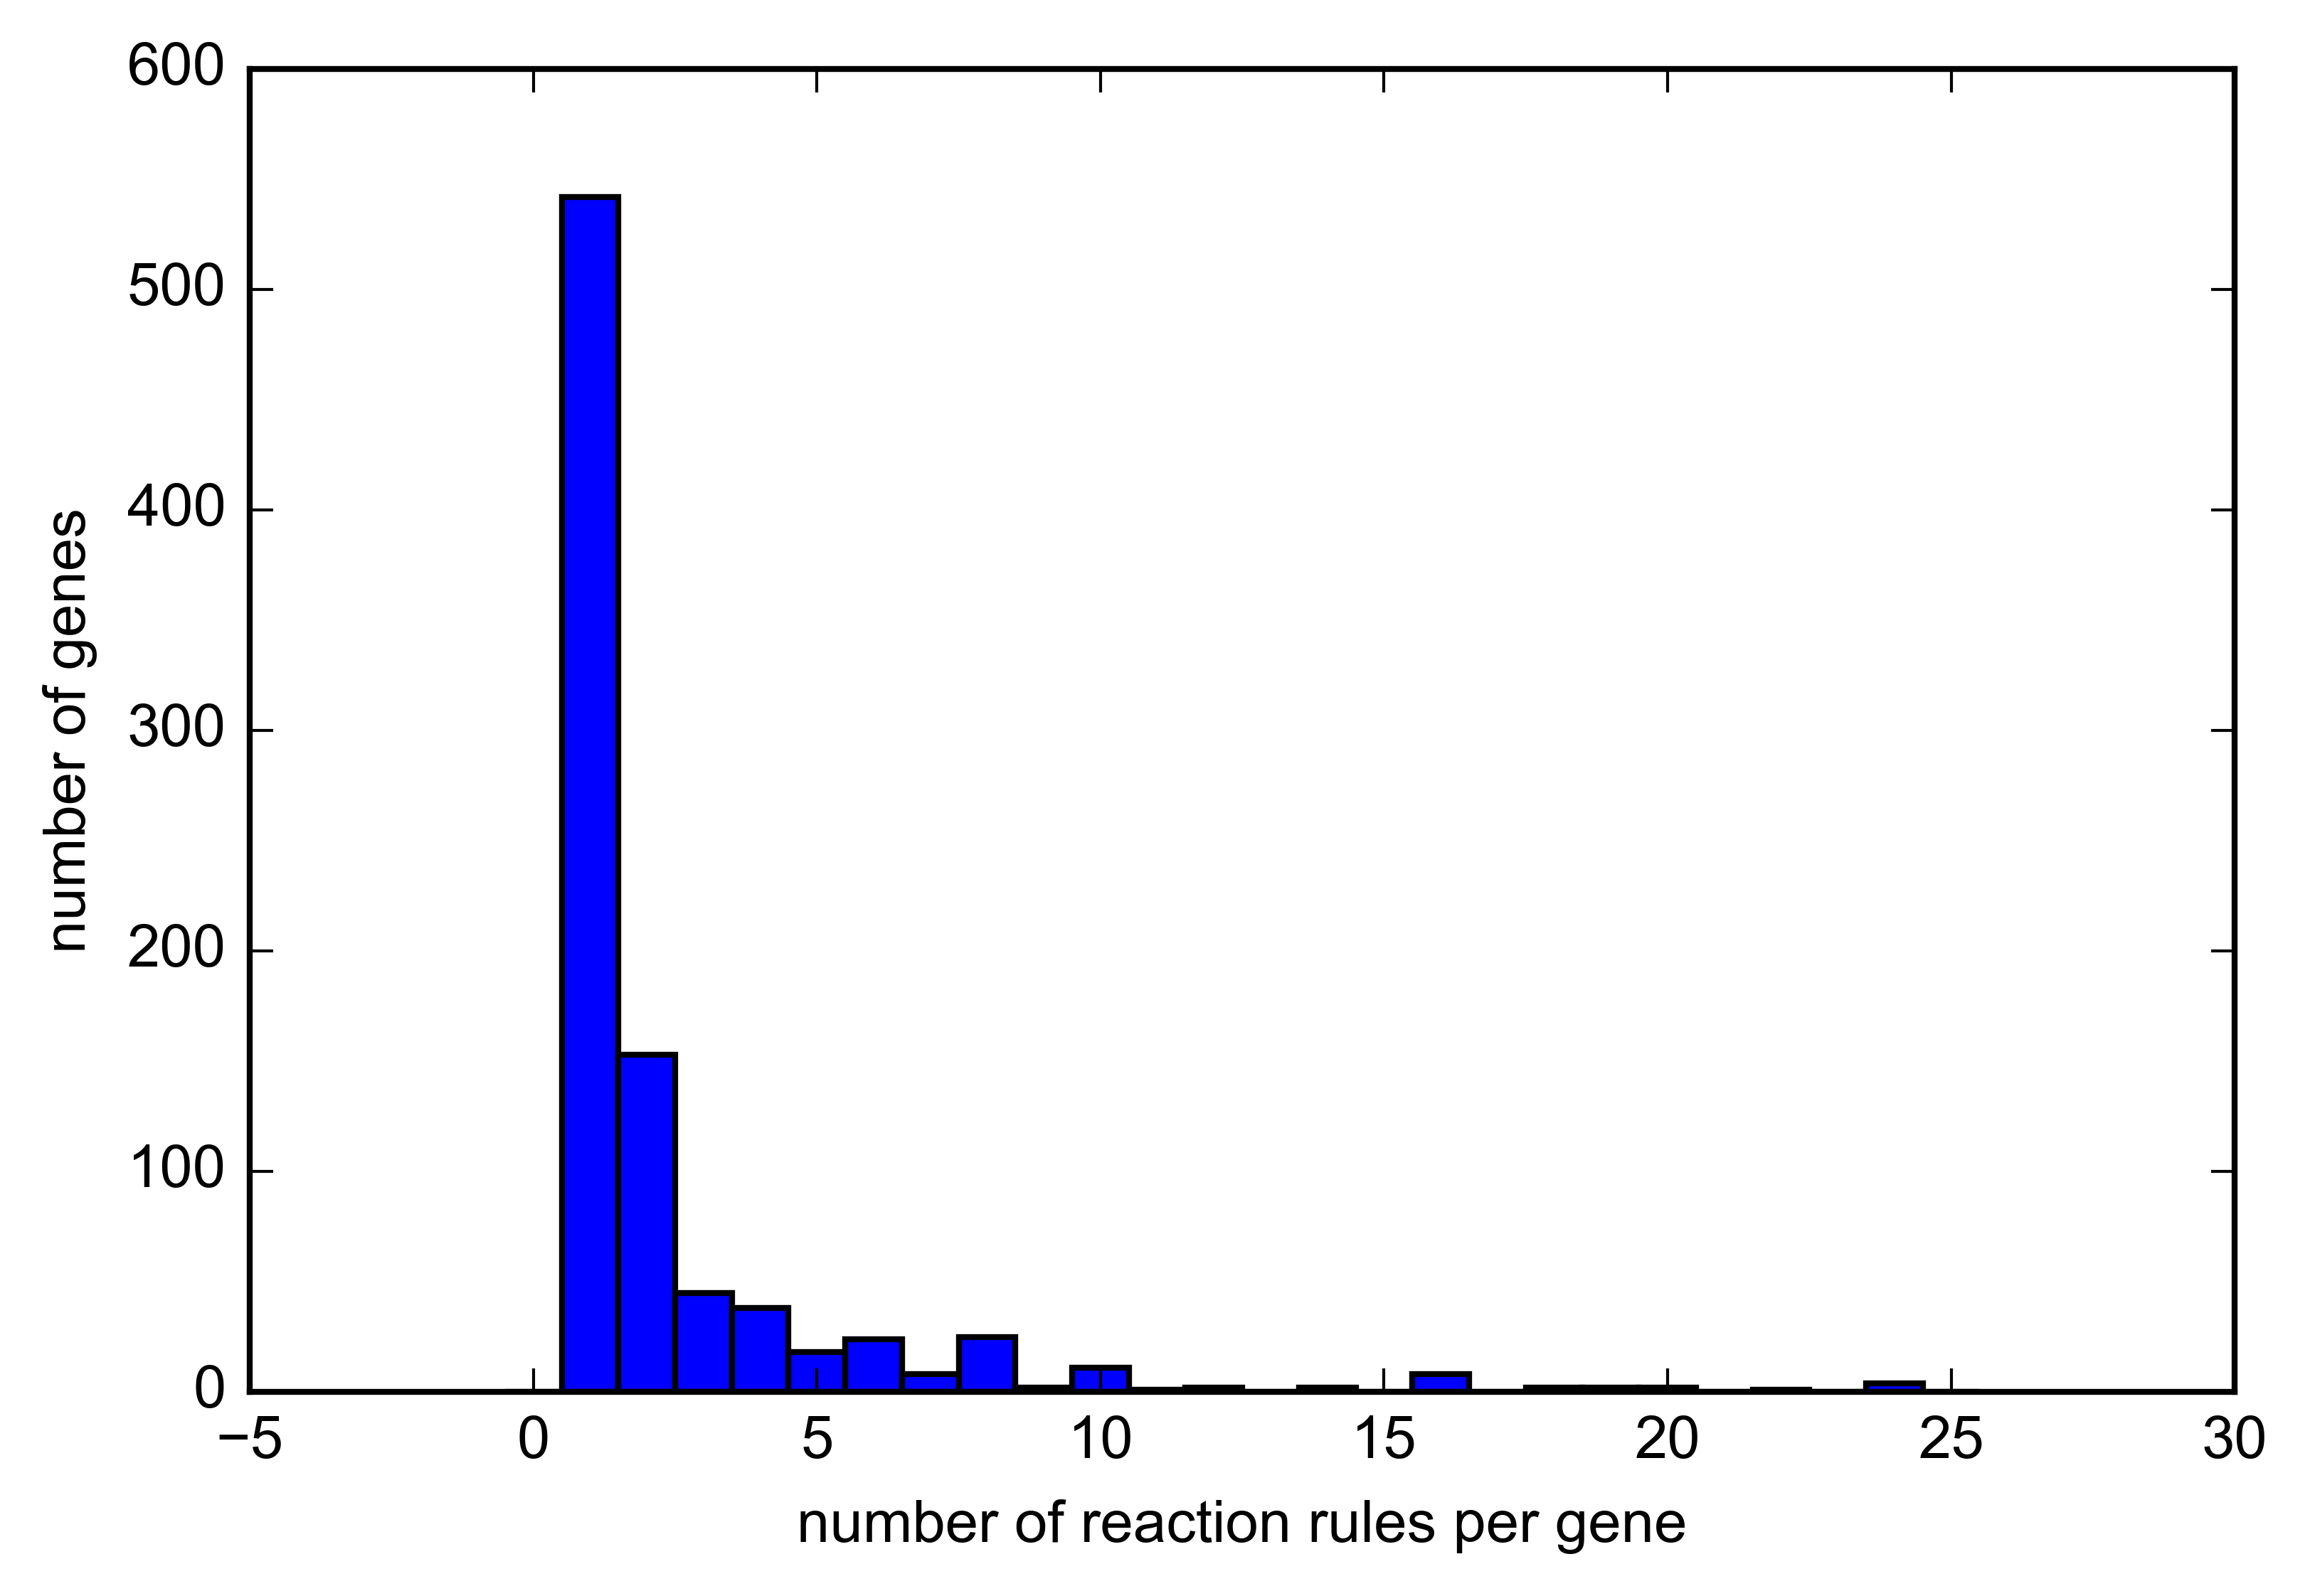

In [3]:
plt.hist([gene.number_reactions() for gene in genes], bins=26, range=(-0.5, 25.5))
plt.xlabel('number of reaction rules per gene')
plt.ylabel('number of genes')
plt.show()

In [4]:
print len(genes), 'genes'
print len([g for g in genes if g.is_simple_single_function()]), 'simple one reaction - one enzyme genes'
print len([g for g in genes if g.is_isoenzyme()]), 'isoenzymes'
print len([g for g in genes if g.is_multifunctional()]), 'multi-functional enzymes'
print len([g for g in genes if g.is_multifunctional() and g.is_isoenzyme()]), 'multi-functional isoenzymes'

909 genes
285 simple one reaction - one enzyme genes
407 isoenzymes
367 multi-functional enzymes
178 multi-functional isoenzymes


In [5]:
nConditions = len(genes[0].geneLossCosts)
print 'there are', nConditions, 'conditions'
rhosGLCWithBlocked = [spearmanr([gene.geneLossCosts[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
           for i in range(nConditions)]
rhosFLCWithBlocked = [spearmanr([gene.functionLossCosts[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
           for i in range(nConditions)]
# removed blocked genes
genes = [g for g in genes if not g.blocked]
rhosGLC = [spearmanr([gene.geneLossCosts[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
           for i in range(nConditions)]
rhosFLC = [spearmanr([gene.functionLossCosts[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
           for i in range(nConditions)]
print ('Using gene-loss cost, Spearmans correlation with dN/dS between: '
       '%.3f and %.3f') % (min(rhosGLC), max(rhosGLC))
print ('Using function-loss cost, Spearmans correlation with dN/dS between: '
       '%.3f and %.3f') % (min(rhosFLC), max(rhosFLC))

there are 1479 conditions
Using gene-loss cost, Spearmans correlation with dN/dS between: -0.284 and -0.031
Using function-loss cost, Spearmans correlation with dN/dS between: -0.362 and -0.087


In [6]:
"""Calculate the correlations for a variety of subsets of the genes, 
in order to better understand what's going on."""
rhosHybrid1 = [spearmanr([gene.hybrid_cost_1()[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
               for i in range(nConditions)]
rhosHybrid2 = [spearmanr([gene.hybrid_cost_2()[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
               for i in range(nConditions)]
rhosGLCNoIso = [spearmanr([gene.geneLossCosts[i] for gene in genes if not gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes if not gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
rhosFLCNoIso = [spearmanr([gene.functionLossCosts[i] for gene in genes if not gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes if not gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
rhosGLCNoMulti = [spearmanr([gene.geneLossCosts[i] for gene in genes if not gene.is_multifunctional()], 
                     [gene.dndsRank for gene in genes if not gene.is_multifunctional()])[0] 
                for i in range(nConditions)]
rhosFLCNoMulti = [spearmanr([gene.functionLossCosts[i] for gene in genes if not gene.is_multifunctional()], 
                     [gene.dndsRank for gene in genes if not gene.is_multifunctional()])[0] 
                for i in range(nConditions)]
rhosGLCIso = [spearmanr([gene.geneLossCosts[i] for gene in genes if gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes if gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
rhosFLCIso = [spearmanr([gene.functionLossCosts[i] for gene in genes if gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes if gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
rhosGLCMulti = [spearmanr([gene.geneLossCosts[i] for gene in genes if gene.is_multifunctional()], 
                     [gene.dndsRank for gene in genes if gene.is_multifunctional()])[0] 
                for i in range(nConditions)]
rhosFLCMulti = [spearmanr([gene.functionLossCosts[i] for gene in genes if gene.is_multifunctional()], 
                     [gene.dndsRank for gene in genes if gene.is_multifunctional()])[0] 
                for i in range(nConditions)]

rhosGLCMultiNonIso = [spearmanr([gene.geneLossCosts[i] for gene in genes 
                                 if gene.is_multifunctional() and not gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes 
                      if gene.is_multifunctional() and not gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
rhosFLCMultiNonIso = [spearmanr([gene.functionLossCosts[i] for gene in genes
                      if gene.is_multifunctional() and not gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes 
                      if gene.is_multifunctional() and not gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
slowEvolvingIsozymes = []
fastEvolvingIsozymes = []
for r in model.reactions:
    if 'or' in r.gene_reaction_rule and not 'and' in r.gene_name_reaction_rule:
        fastEvolvingIsozymes.append(max(r.genes, key=lambda x: geneMap[x.id].dndsRank).id)
        slowEvolvingIsozymes.append(min(r.genes, key=lambda x: geneMap[x.id].dndsRank).id)
rhosGLCFastIso = [spearmanr([gene.geneLossCosts[i] for gene in genes if gene.name in fastEvolvingIsozymes], 
                     [gene.dndsRank for gene in genes if gene.name in fastEvolvingIsozymes])[0] 
           for i in range(nConditions)]
rhosFLCFastIso = [spearmanr([gene.functionLossCosts[i] for gene in genes if gene.name in fastEvolvingIsozymes], 
                     [gene.dndsRank for gene in genes if gene.name in fastEvolvingIsozymes])[0] 
                     for i in range(nConditions)]
rhosGLCSlowIso = [spearmanr([gene.geneLossCosts[i] for gene in genes if gene.name in slowEvolvingIsozymes], 
                     [gene.dndsRank for gene in genes if gene.name in slowEvolvingIsozymes])[0] 
           for i in range(nConditions)]
rhosFLCSlowIso = [spearmanr([gene.functionLossCosts[i] for gene in genes if gene.name in slowEvolvingIsozymes], 
                     [gene.dndsRank for gene in genes if gene.name in slowEvolvingIsozymes])[0] 
                     for i in range(nConditions)]

In [7]:
def correlation_histograms(ax, rhosA, rhosB, text=None, drawLegend=False,
                           drawXlabel=True, drawYlabel=True, colorA='#d95f02', 
                           colorB='#66c2a5'):
    """Draw histograms of two distributions of the cost/evolution-rate correlations.
    
    Histograms are normalized to unit area. Each entry is a simulated minimal media.
    
    Args:
        ax (axis): Matplotlib axis.
        rhosA/rhosB (list(float)): correlation values.
        text (str): label to write on figure.
        drawLegend/drawXlabel/drawYlabel (bool): switches.
        colorA/colorB (str): hex code of colors to use.
    
    """
    nBins = 100
    rng = (-0.6, 0.4)
    weights = np.ones(len(rhosA)) / float(len(rhosA)) 
    ax.hist(rhosA, bins=nBins, range=rng, color=colorA, weights=weights,
             label='Gene-loss cost')
    if len(rhosB) > 0:
        ax.hist(rhosB, bins=nBins, range=rng, color=colorB, weights=weights,
             label='Function-loss cost')
    if drawYlabel:
        ax.set_ylabel('Relative frequency')
    ax.set_ylim((0.,0.16))
    ax.set_yticks([0.05,0.15])
    if drawXlabel:
        ax.set_xlabel(r"Spearman's correlation coefficient ($\rho$)", 
                      fontsize=12)
    if drawLegend:
        ax.legend()
    if text is not None:
        ax.text(-0.07, 0.10, text, fontweight='bold', fontsize=16)
    if len(rhosA) == len(rhosB):
        print 'p-value: %.2e' % wilcoxon(rhosA, rhosB)[1]

p-value: 1.84e-240


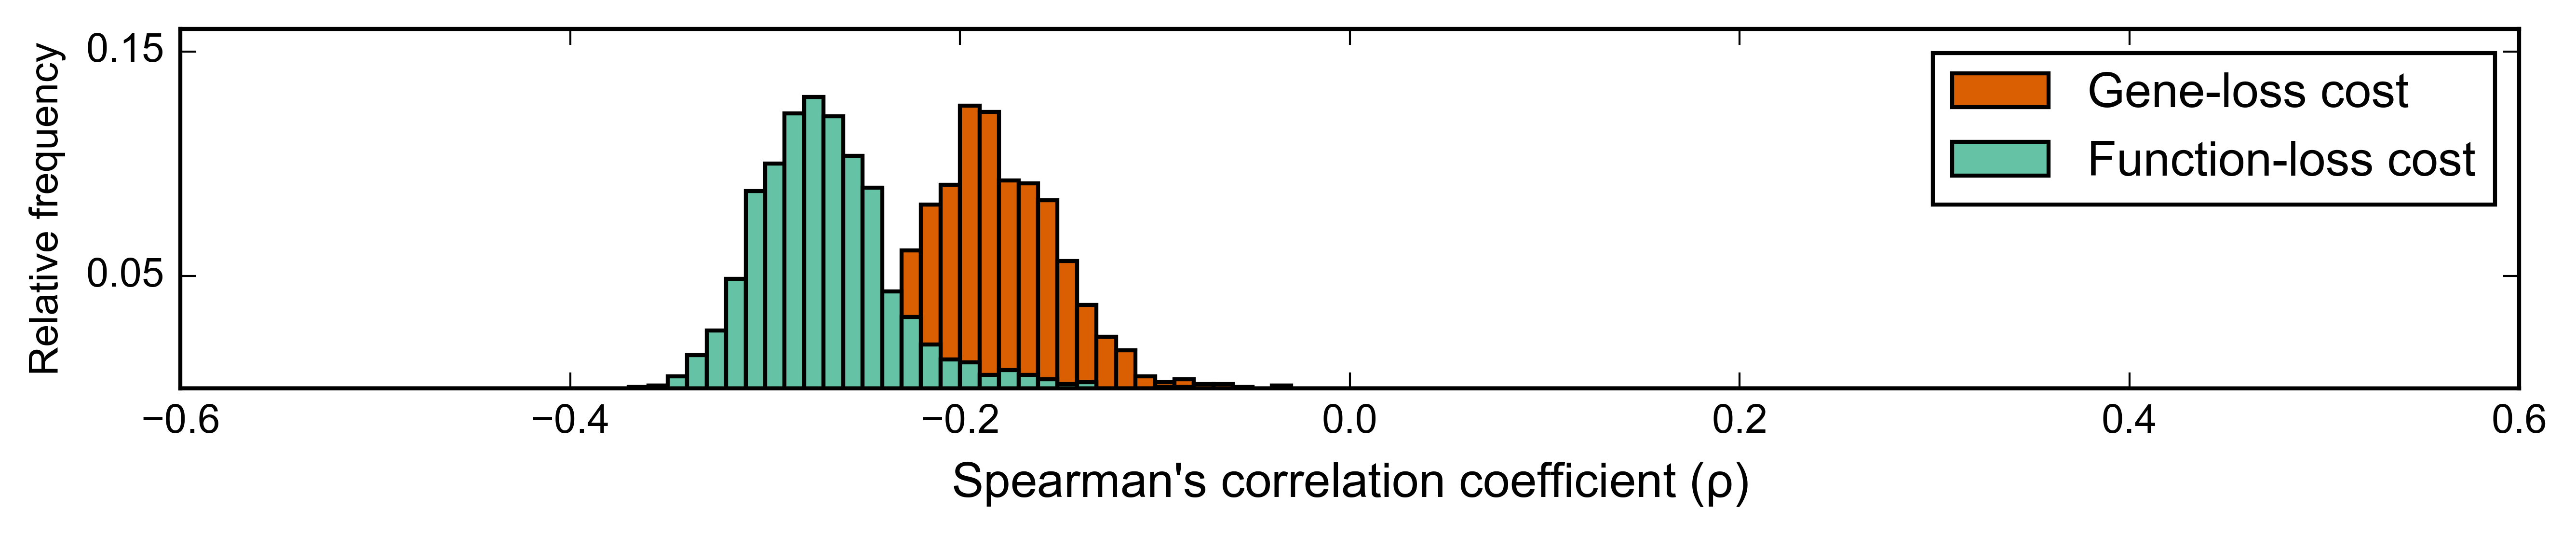

mean rho using gene-loss cost: -0.1852
mean rho using function-loss cost: -0.2699


In [8]:
"""Compare function-loss cost and gene-loss cost."""
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLC, rhosFLC, drawLegend=True)
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'spearmans_correlation_distributions_GLC_vs_FLC.pdf'))
plt.show()
print 'mean rho using gene-loss cost: %.4f' % np.mean(rhosGLC)
print 'mean rho using function-loss cost: %.4f' % np.mean(rhosFLC)

We observe that function-loss cost has a stronger negative correlation with evolutionary rate than gene-loss cost. The next step is to try and understand which subsets of the enzymes are driving this difference.  

p-value: 1.84e-240
p-value: 6.78e-134
p-value: 2.70e-243
p-value: 1.59e-190


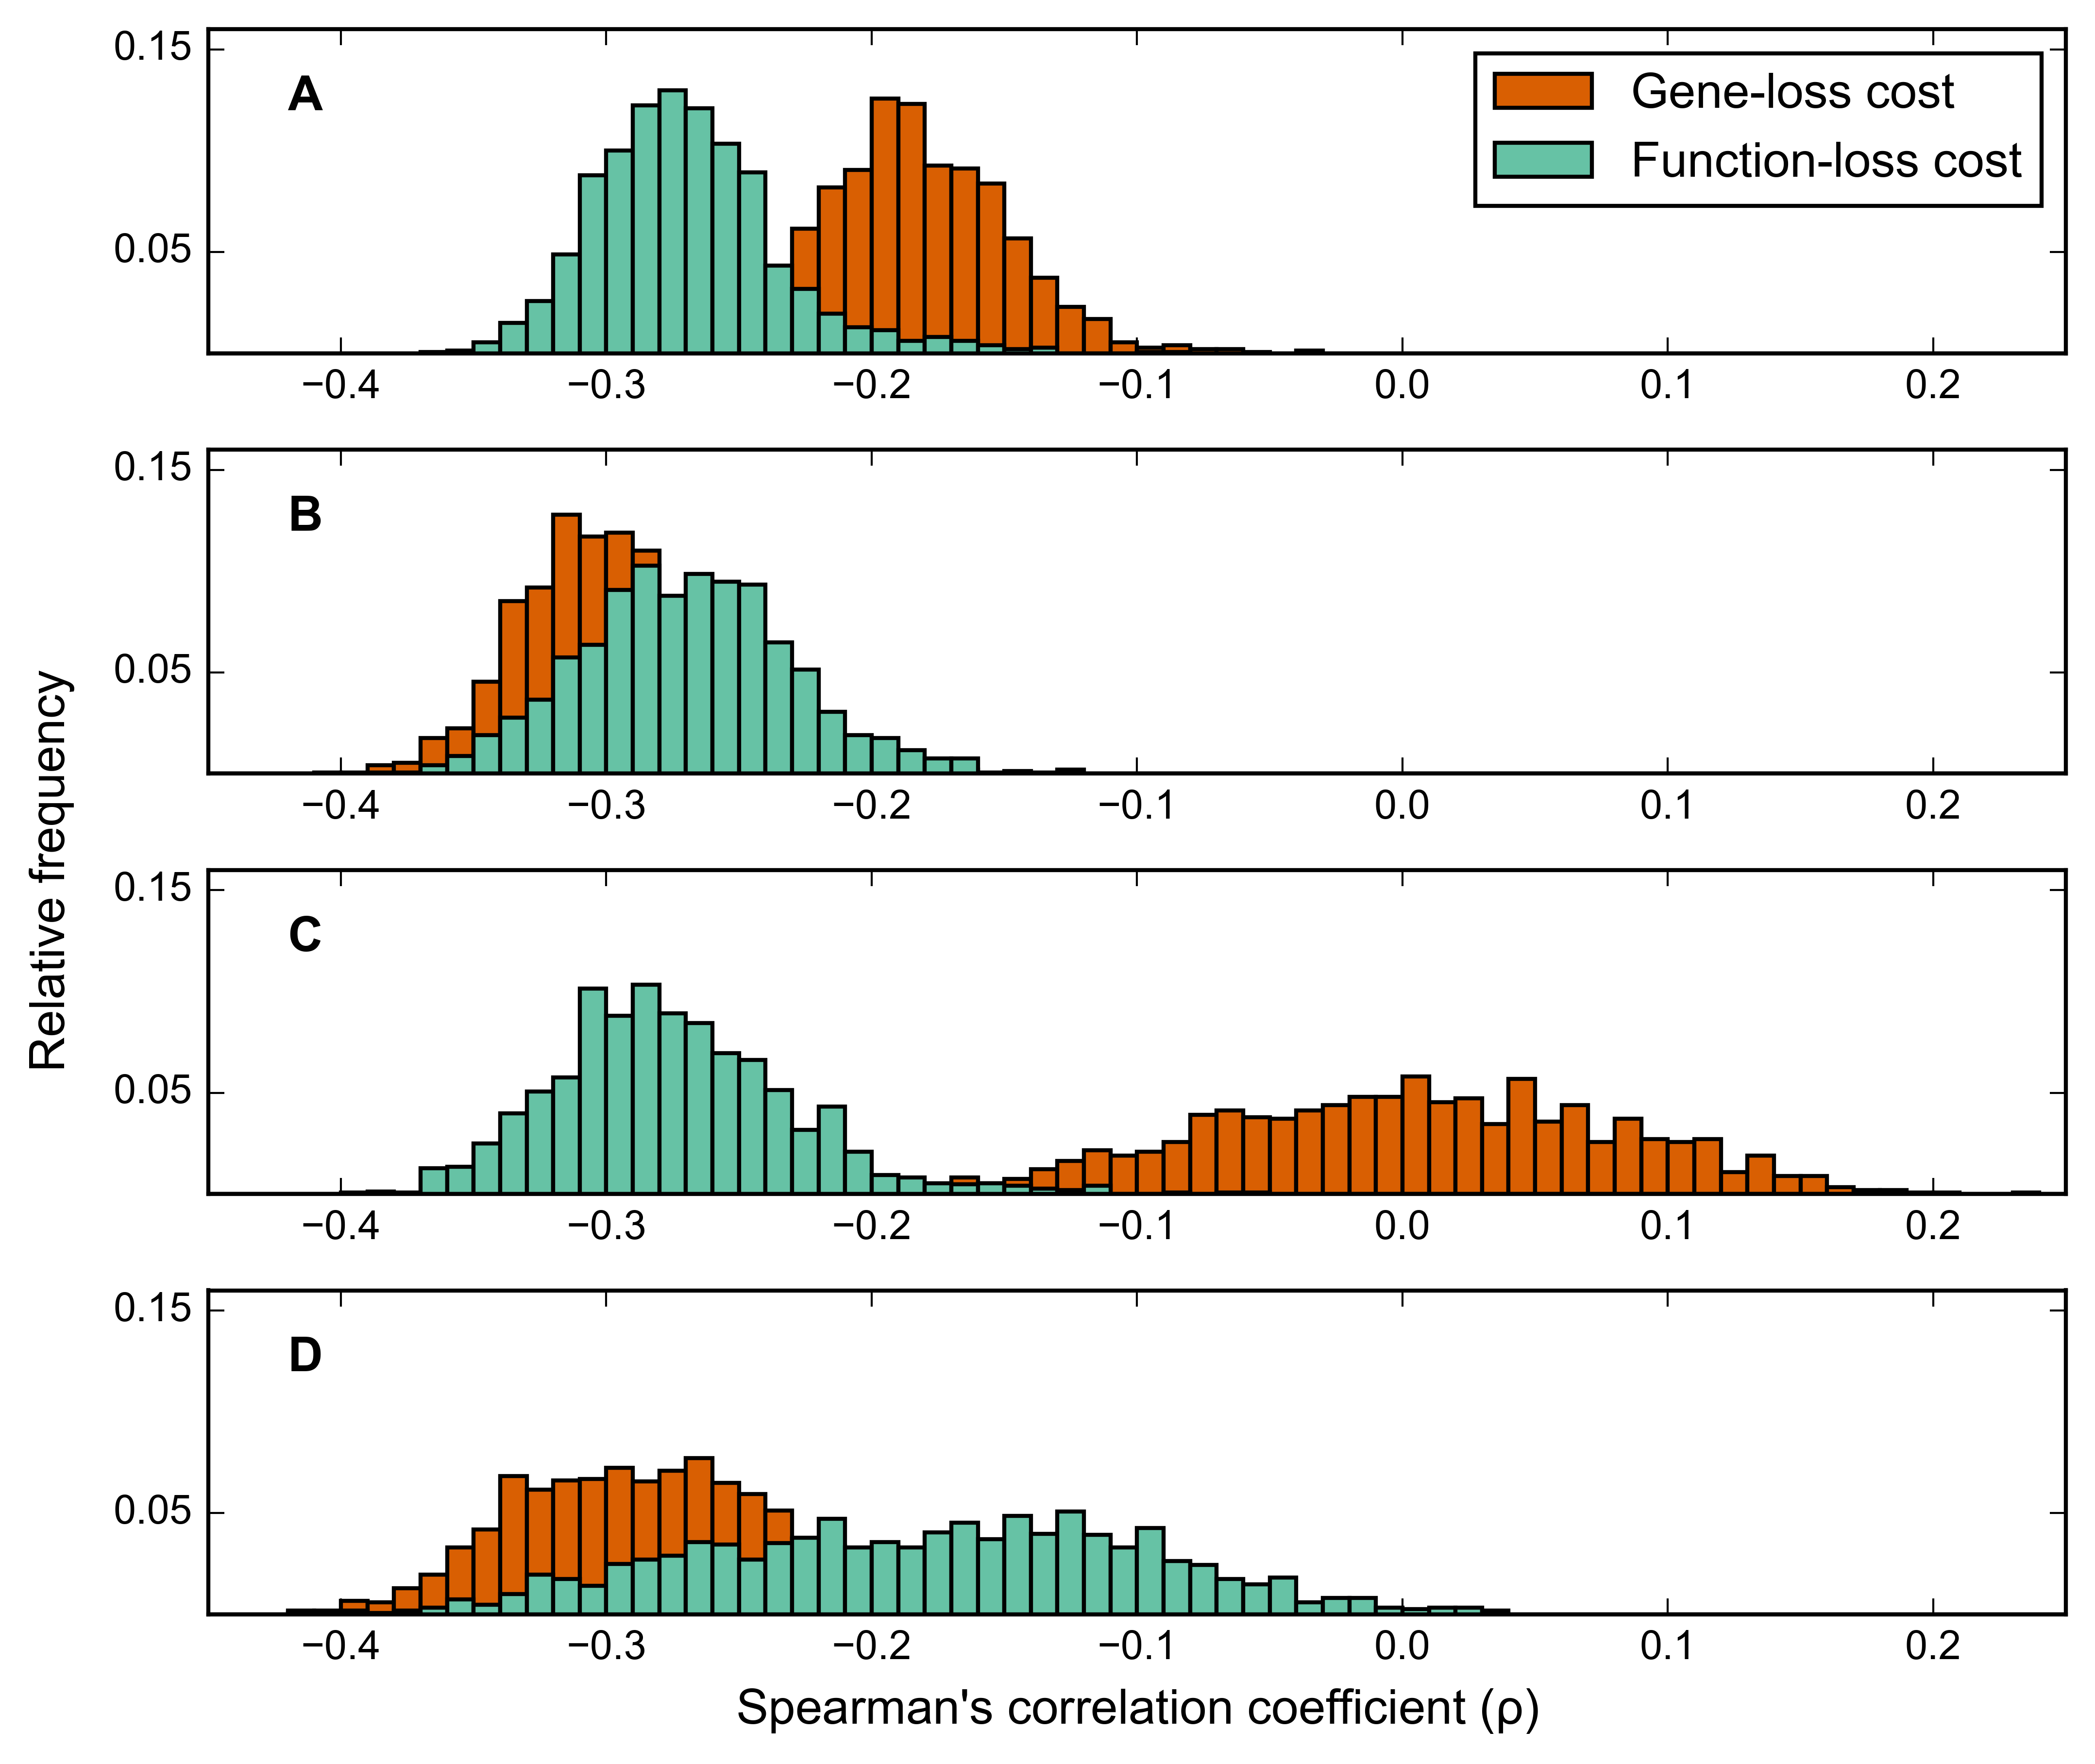

In [9]:
"""Figure 2"""
fig, ax = plt.subplots(4, 1)
fig.set_size_inches(7., 6.2)
correlation_histograms(ax[0], rhosGLC, rhosFLC, drawLegend=True, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[1], rhosGLCNoIso, rhosFLCNoIso, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[2], rhosGLCIso, rhosFLCIso, drawXlabel=False, 
                       drawYlabel=False)
correlation_histograms(ax[3], rhosGLCMultiNonIso, rhosFLCMultiNonIso, drawYlabel=False)
xmin = -0.45
ax[0].text(xmin + 0.03, 0.12, 'A', fontweight='bold', fontsize=12)
ax[1].text(xmin + 0.03, 0.12, 'B', fontweight='bold', fontsize=12)
ax[2].text(xmin + 0.03, 0.12, 'C', fontweight='bold', fontsize=12)
ax[3].text(xmin + 0.03, 0.12, 'D', fontweight='bold', fontsize=12)
for subAxes in ax:
    subAxes.set_xlim((xmin, 0.25))
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'figure2.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'figure2.svg'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'figure2.eps'), bbox_inches='tight')
plt.show()

We can see that the difference in the strength of the anticorrelations between function-loss and gene-loss costs (**A**) is driven by the difference in treatment of isoenzymes. Since removing the isoenzymes (**B**) reduces the difference and looking at only the isoenzymes (**C**) shows an excentuated difference. Looking at the multifunctional enzymes, which are not also isoenzymes (**D**) shows that the function-loss approach, of summing the costs of removing the individual interactions, results in weaker correlations between the cost and evolutionary rate than the gene-loss approach of simultaneously deleting all reactions.

In [10]:
"""Look at the average correlations for different cost versions and enzyme subsets."""
print 'mean rho for GLC: %.4f' % np.mean(rhosGLC)
print 'mean rho for FLC: %.4f' % np.mean(rhosGLC)
print 'mean rho for GLC no isoenzymes: %.4f' % np.mean(rhosGLCNoIso)
print 'mean rho for FLC no isoenzymes: %.4f' % np.mean(rhosFLCNoIso)
print 'mean rho for GLC only isoenzymes: %.4f' % np.mean(rhosGLCIso)
print 'mean rho for FLC only isoenzymes: %.4f' % np.mean(rhosFLCIso)
print 'mean rho for GLC only multifunctional, non-isoenzymes: %.4f' % np.mean(rhosGLCMultiNonIso)
print 'mean rho for FLC only multifunctoinal, non-isoenzymes: %.4f' % np.mean(rhosFLCMultiNonIso)
print 'mean rho for GLC for fast evolving isoenzymes: %.2f' % np.mean(rhosGLCFastIso)
print 'mean rho for GLC for slow evolving isoenzymes: %.2f' % np.mean(rhosGLCSlowIso)
print 'mean rho for FLC for fast evolving isoenzymes: %.2f' % np.mean(rhosFLCFastIso)
print 'mean rho for FLC for slow evolving isoenzymes: %.2f' % np.mean(rhosFLCSlowIso)

mean rho for GLC: -0.1852
mean rho for FLC: -0.1852
mean rho for GLC no isoenzymes: -0.2991
mean rho for FLC no isoenzymes: -0.2697
mean rho for GLC only isoenzymes: 0.0031
mean rho for FLC only isoenzymes: -0.2749
mean rho for GLC only multifunctional, non-isoenzymes: -0.2825
mean rho for FLC only multifunctoinal, non-isoenzymes: -0.1808
mean rho for GLC for fast evolving isoenzymes: 0.00
mean rho for GLC for slow evolving isoenzymes: 0.02
mean rho for FLC for fast evolving isoenzymes: -0.30
mean rho for FLC for slow evolving isoenzymes: -0.38


p-value: 2.76e-242
p-value: 2.92e-243


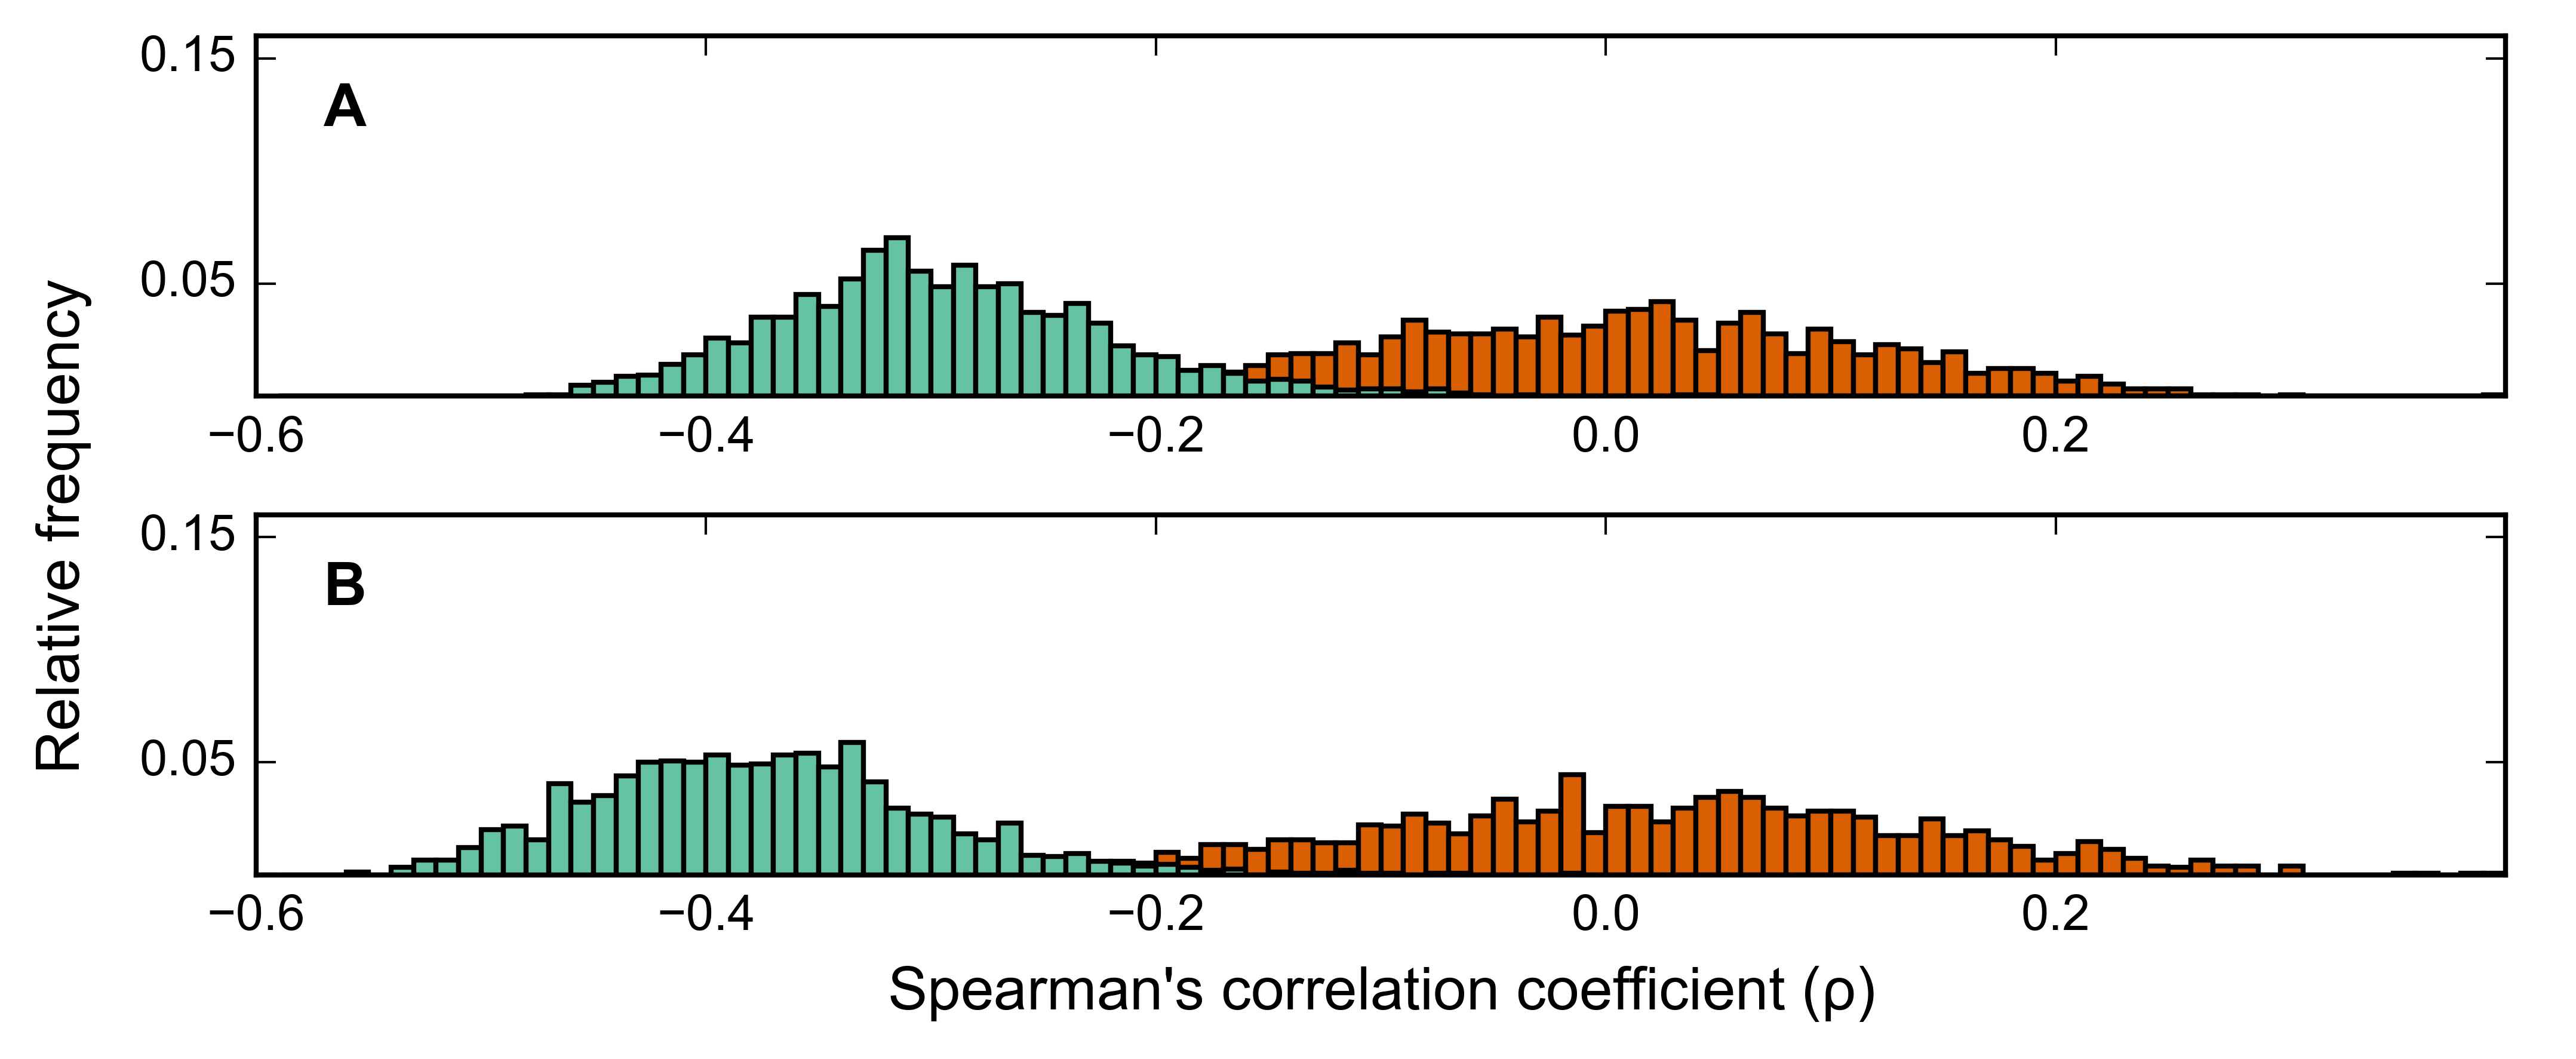

In [11]:
"""Figure 3"""
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(7., 3.1)
correlation_histograms(ax[0], rhosGLCFastIso, rhosFLCFastIso, drawXlabel=False, 
                       drawYlabel=False)
correlation_histograms(ax[1], rhosGLCSlowIso, rhosFLCSlowIso, drawYlabel=False)
ax[0].text(-0.57, 0.12, 'A', fontweight='bold', fontsize=12)
ax[1].text(-0.57, 0.12, 'B', fontweight='bold', fontsize=12)
for subAxes in ax:
    subAxes.set_xlim((-0.60001, 0.4))
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'Figure3.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'Figure3.eps'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'Figure3.svg'), bbox_inches='tight')
plt.show()

In [12]:
print ('Test for difference in average between green distributions in Fig2A and Fig3B'
       ': p-value = %.2e') % wilcoxon(rhosFLC, rhosFLCSlowIso)[1]
print ('Test for difference in average between green distributions in Fig3A and Fig3B'
       ': p-value = %.2e') % wilcoxon(rhosFLCFastIso, rhosFLCSlowIso)[1]

Test for difference in average between green distributions in Fig2A and Fig3B: p-value = 1.43e-236
Test for difference in average between green distributions in Fig3A and Fig3B: p-value = 3.52e-230


p-value: 1.84e-240


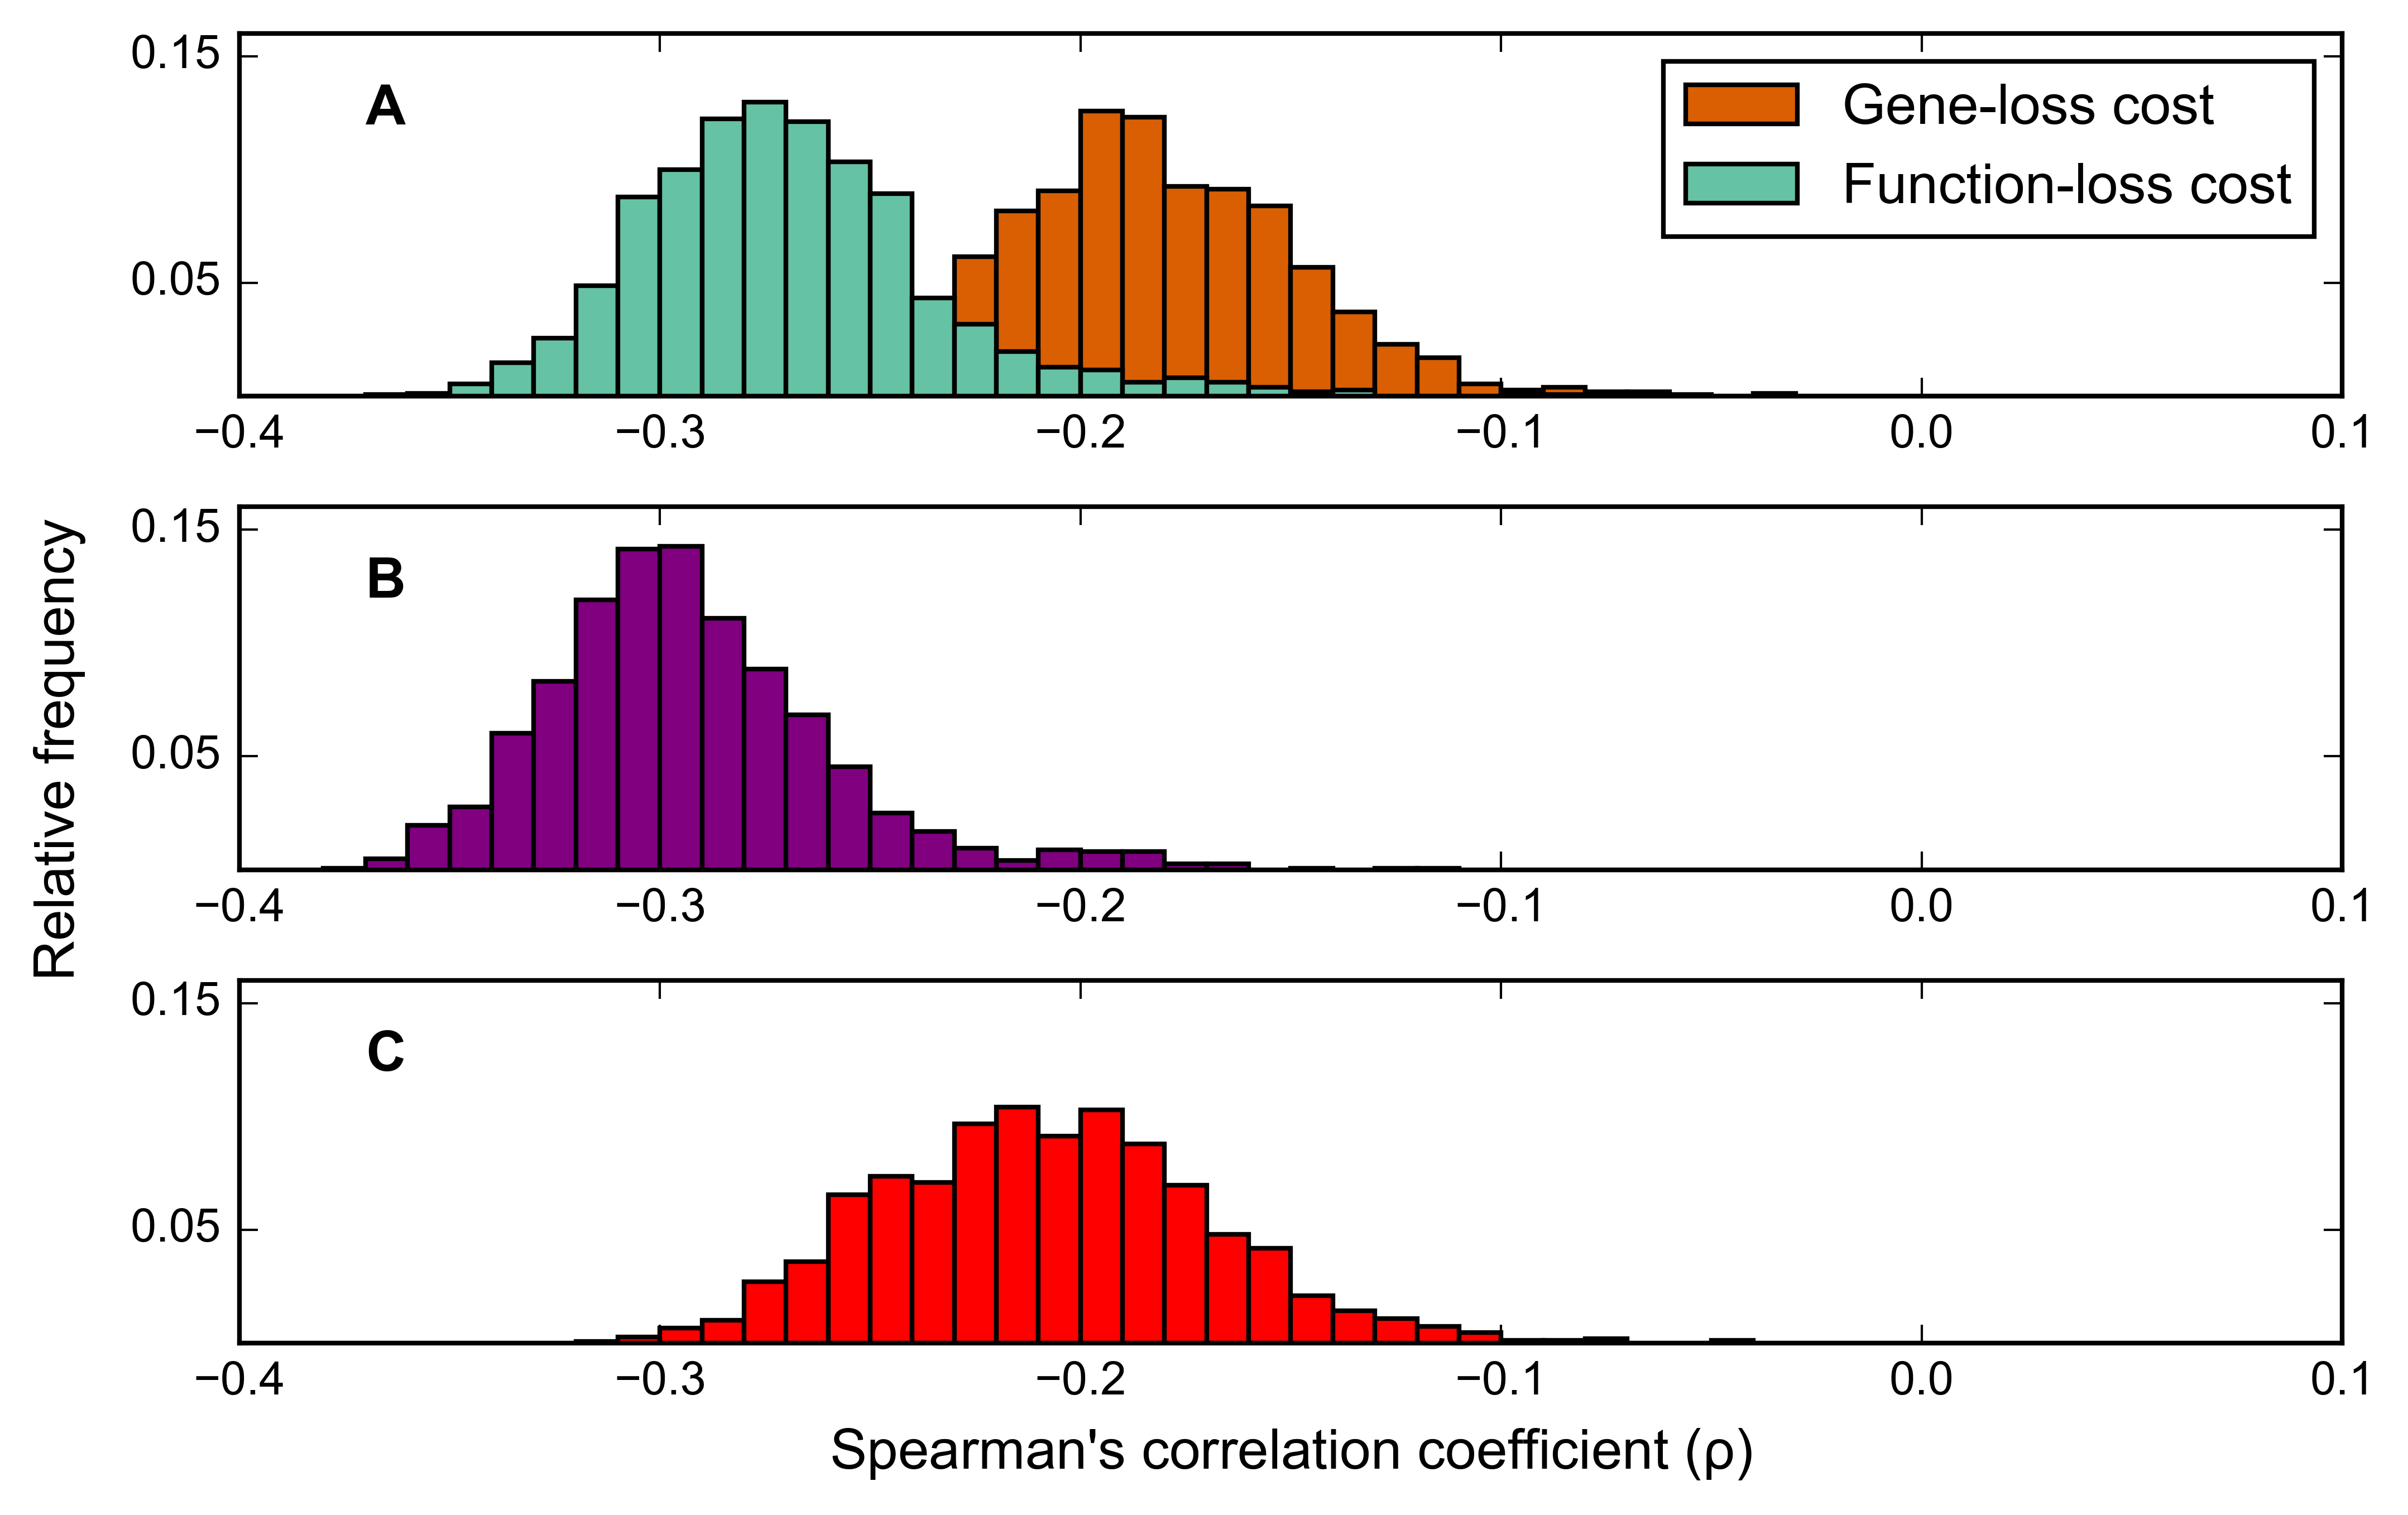

In [13]:
"""Figure S2"""
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(7., 4.67)
correlation_histograms(ax[0], rhosGLC, rhosFLC, drawLegend=True, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[1], rhosHybrid2, [], drawXlabel=False, 
                       drawYlabel=False, colorA='purple')
correlation_histograms(ax[2], rhosHybrid1, [], drawYlabel=False,
                       colorA='red')
ax[0].text(-0.37, 0.12, 'A', fontweight='bold', fontsize=12)
ax[1].text(-0.37, 0.12, 'B', fontweight='bold', fontsize=12)
ax[2].text(-0.37, 0.12, 'C', fontweight='bold', fontsize=12)
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=12)
for subAxes in ax:
    subAxes.set_xlim((-0.4, 0.1))
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'FigureS2.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'FigureS2.eps'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'FigureS2.svg'), bbox_inches='tight')
plt.show()

p-value: 1.84e-240
p-value: 5.42e-242


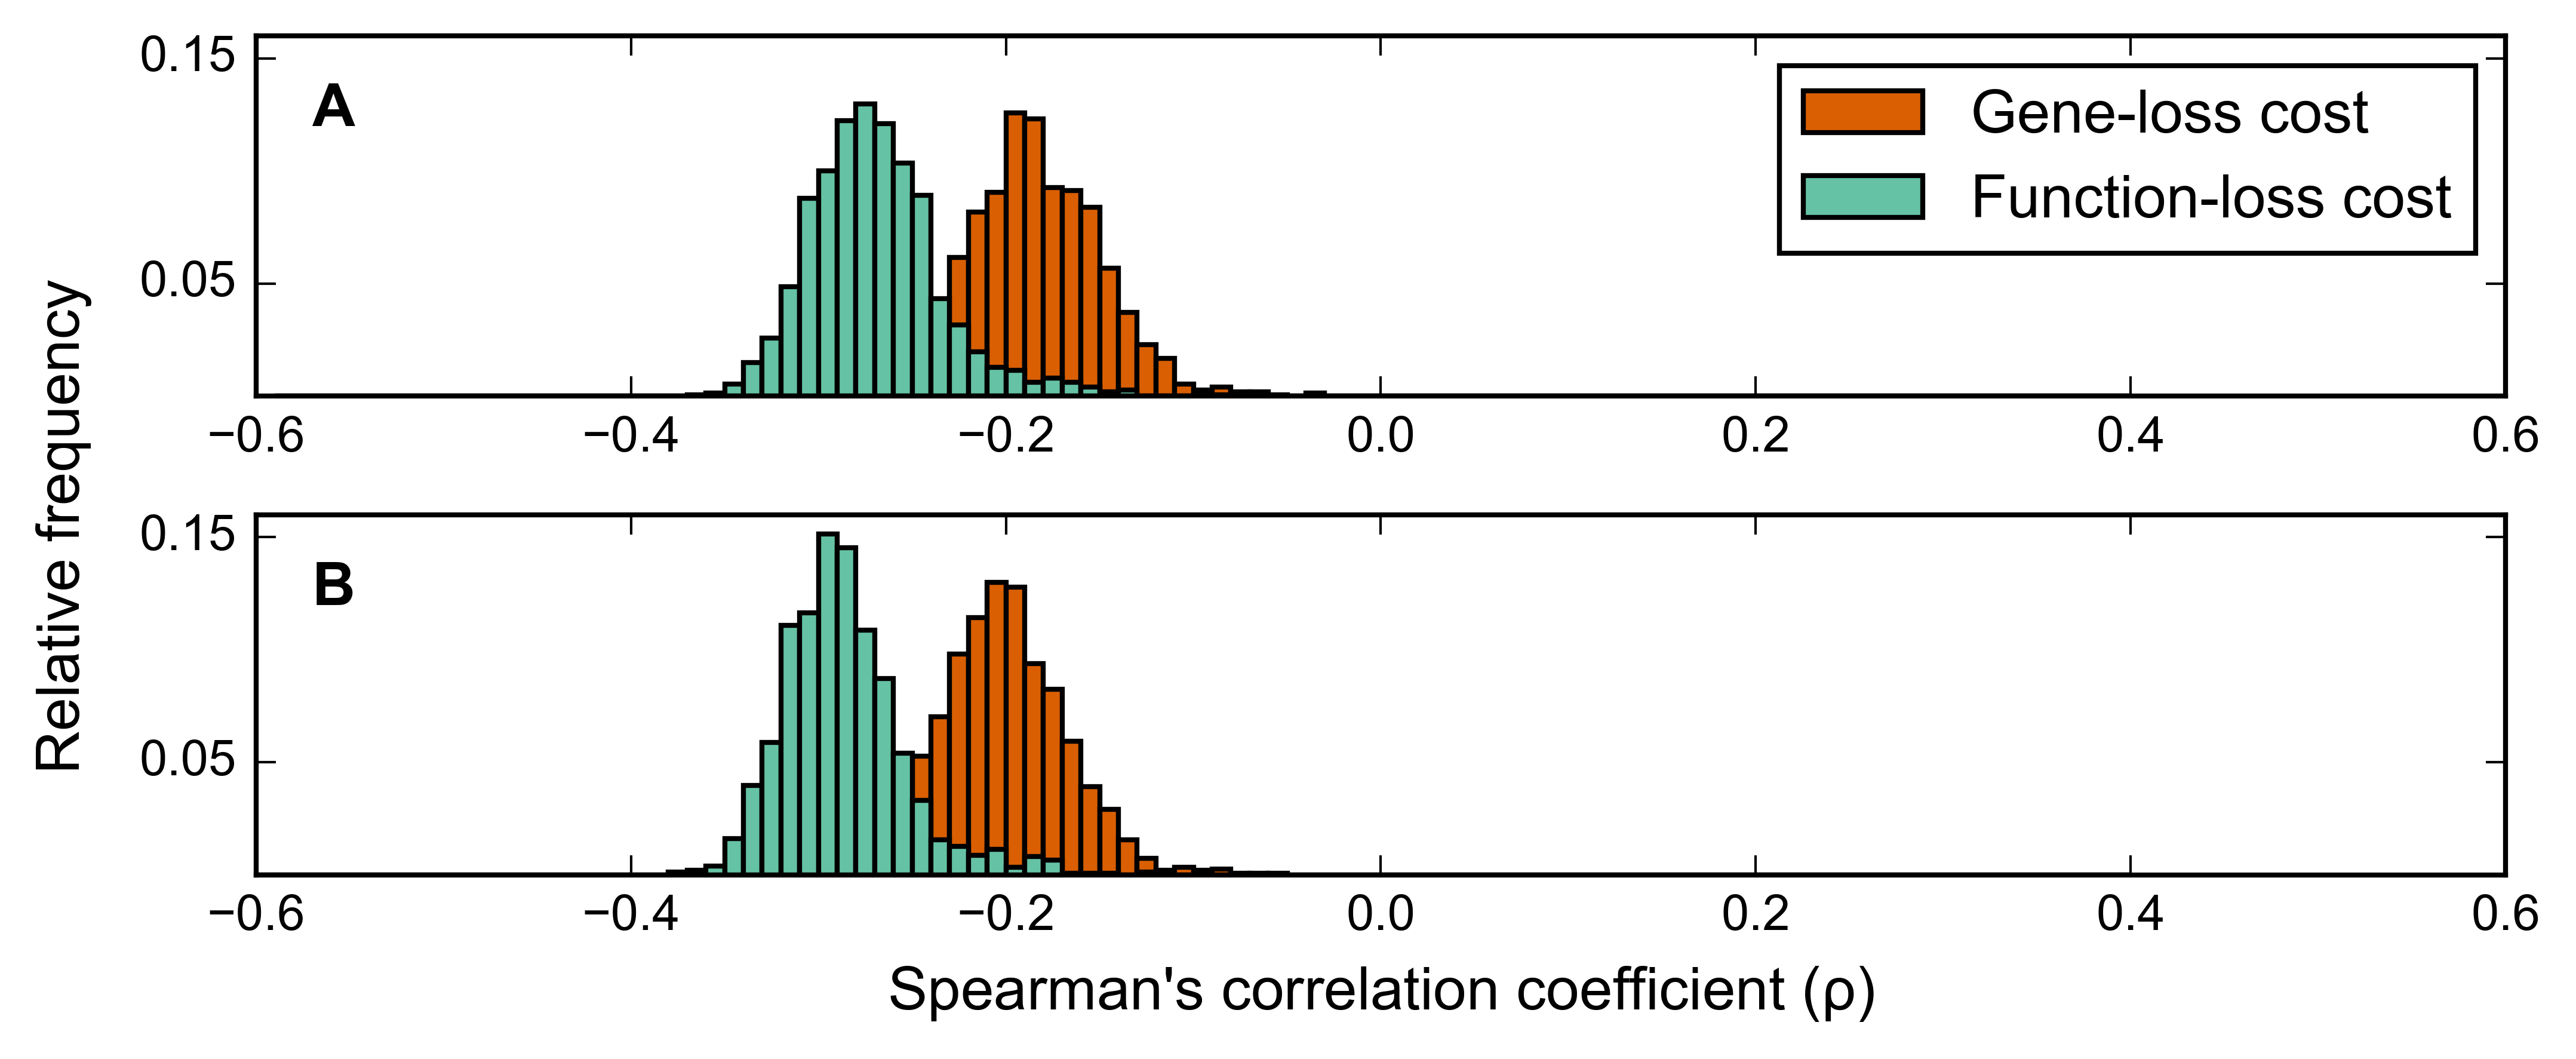

In [14]:
"""Figure S4 in the manuscript.

Testing to confirm that removing blocked reactions has a negligable effect.
"""
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(7, 3.1)
correlation_histograms(ax[0], rhosGLC, rhosFLC, drawLegend=True, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[1], rhosGLCWithBlocked, rhosFLCWithBlocked, drawYlabel=False)
ax[0].text(-0.57, 0.12, 'A', fontweight='bold', fontsize=12)
ax[1].text(-0.57, 0.12, 'B', fontweight='bold', fontsize=12)
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'FigureS4.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'FigureS4.eps'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'FigureS4.svg'), bbox_inches='tight')
plt.show()

p-value: 2.29e-240


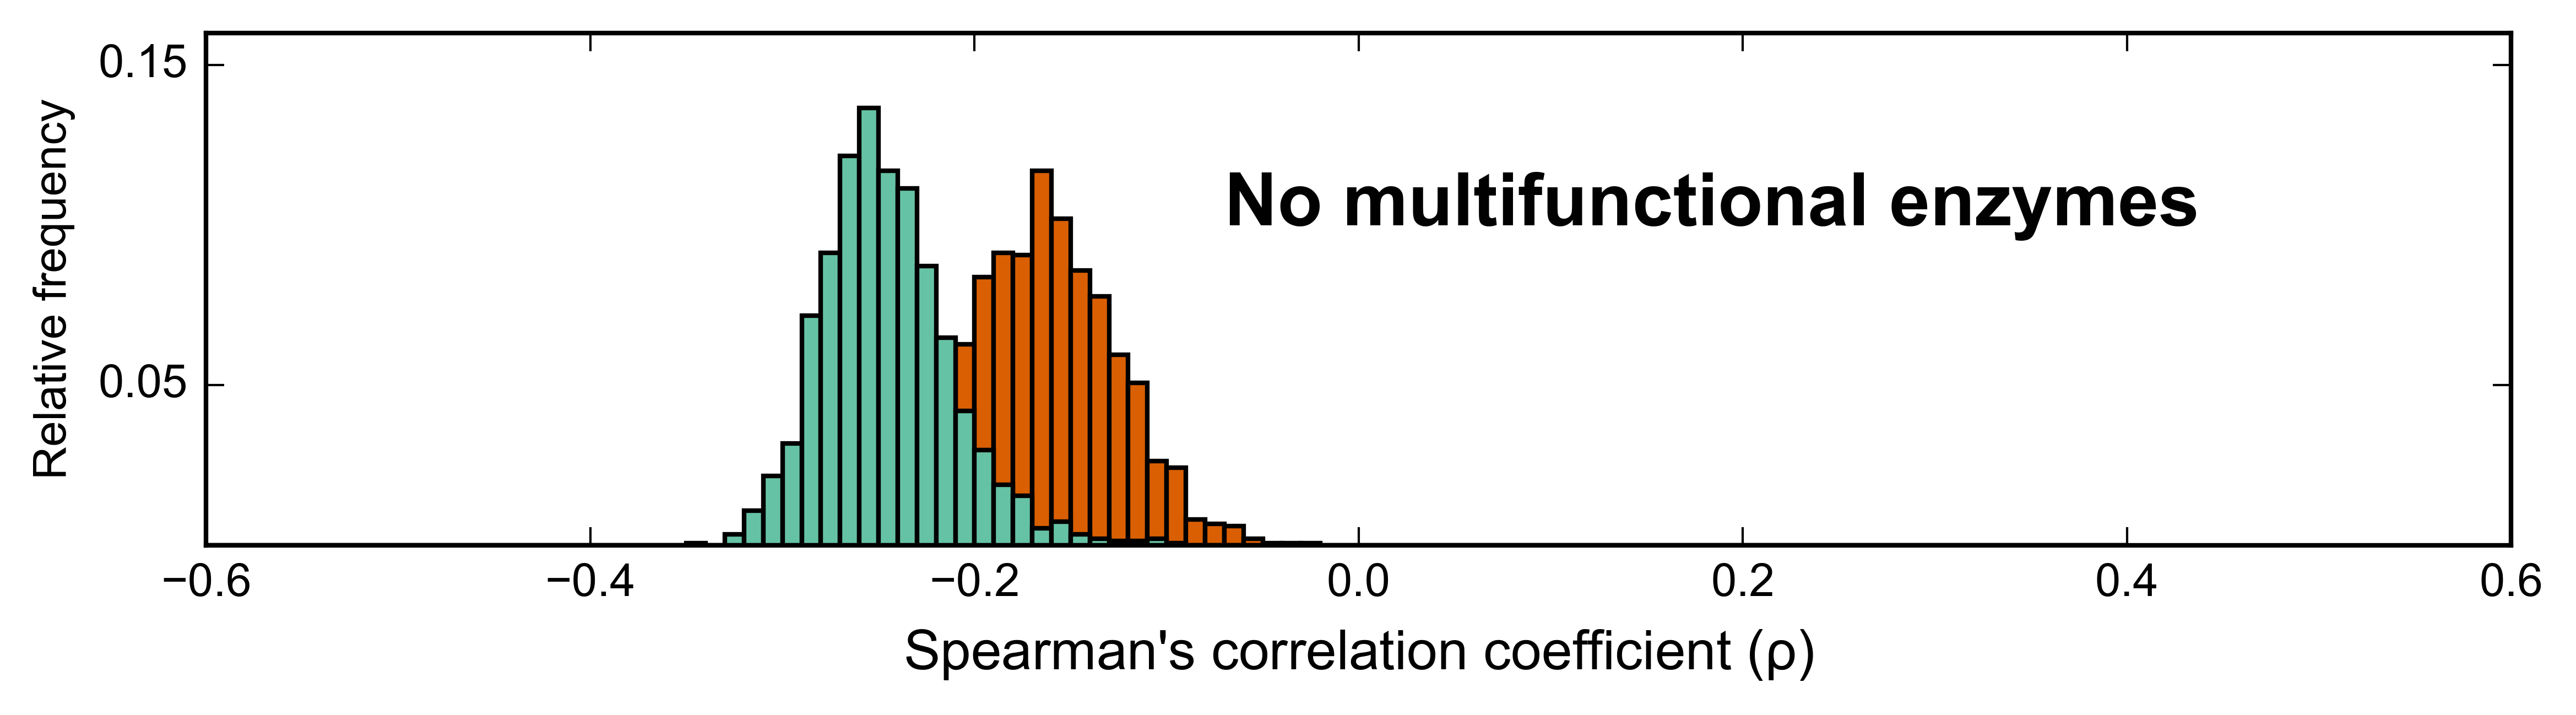

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLCNoMulti, rhosFLCNoMulti, 'No multifunctional enzymes')

p-value: 1.90e-102


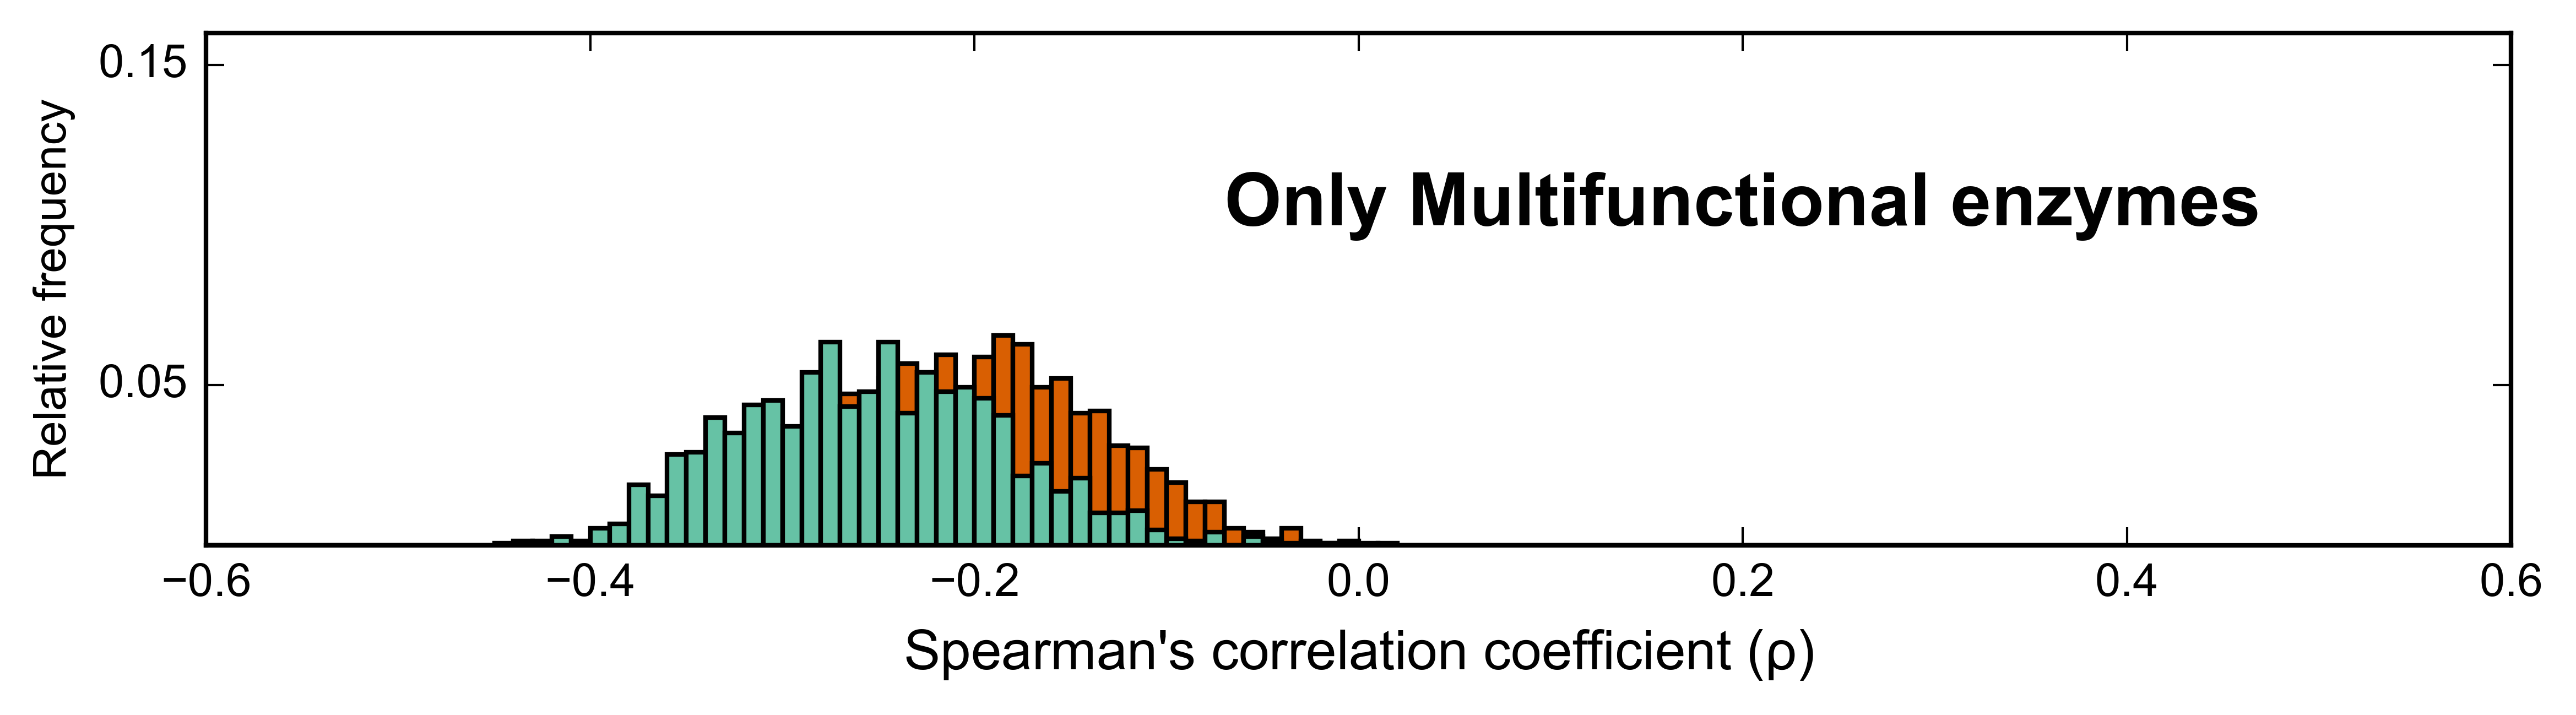

In [16]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLCMulti, rhosFLCMulti, 'Only Multifunctional enzymes')

p-value: 1.59e-190


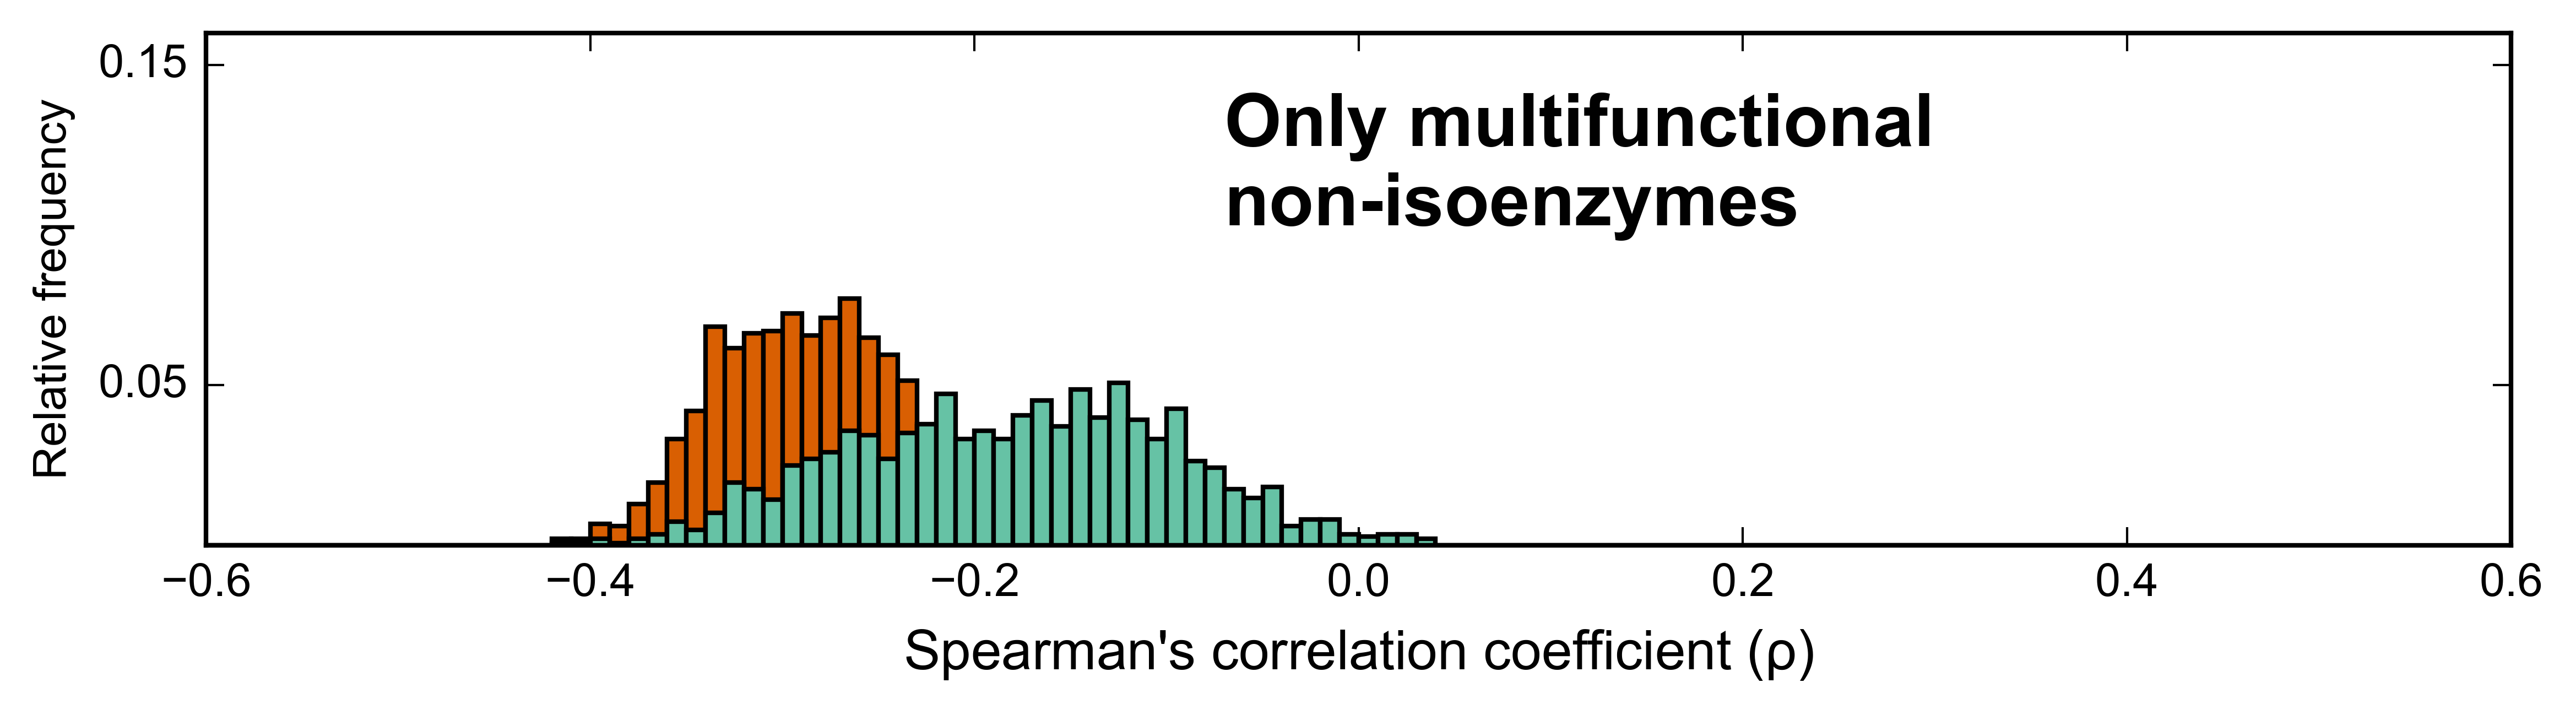

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLCMultiNonIso, rhosFLCMultiNonIso, 'Only multifunctional\nnon-isoenzymes')

p-value: 6.78e-134


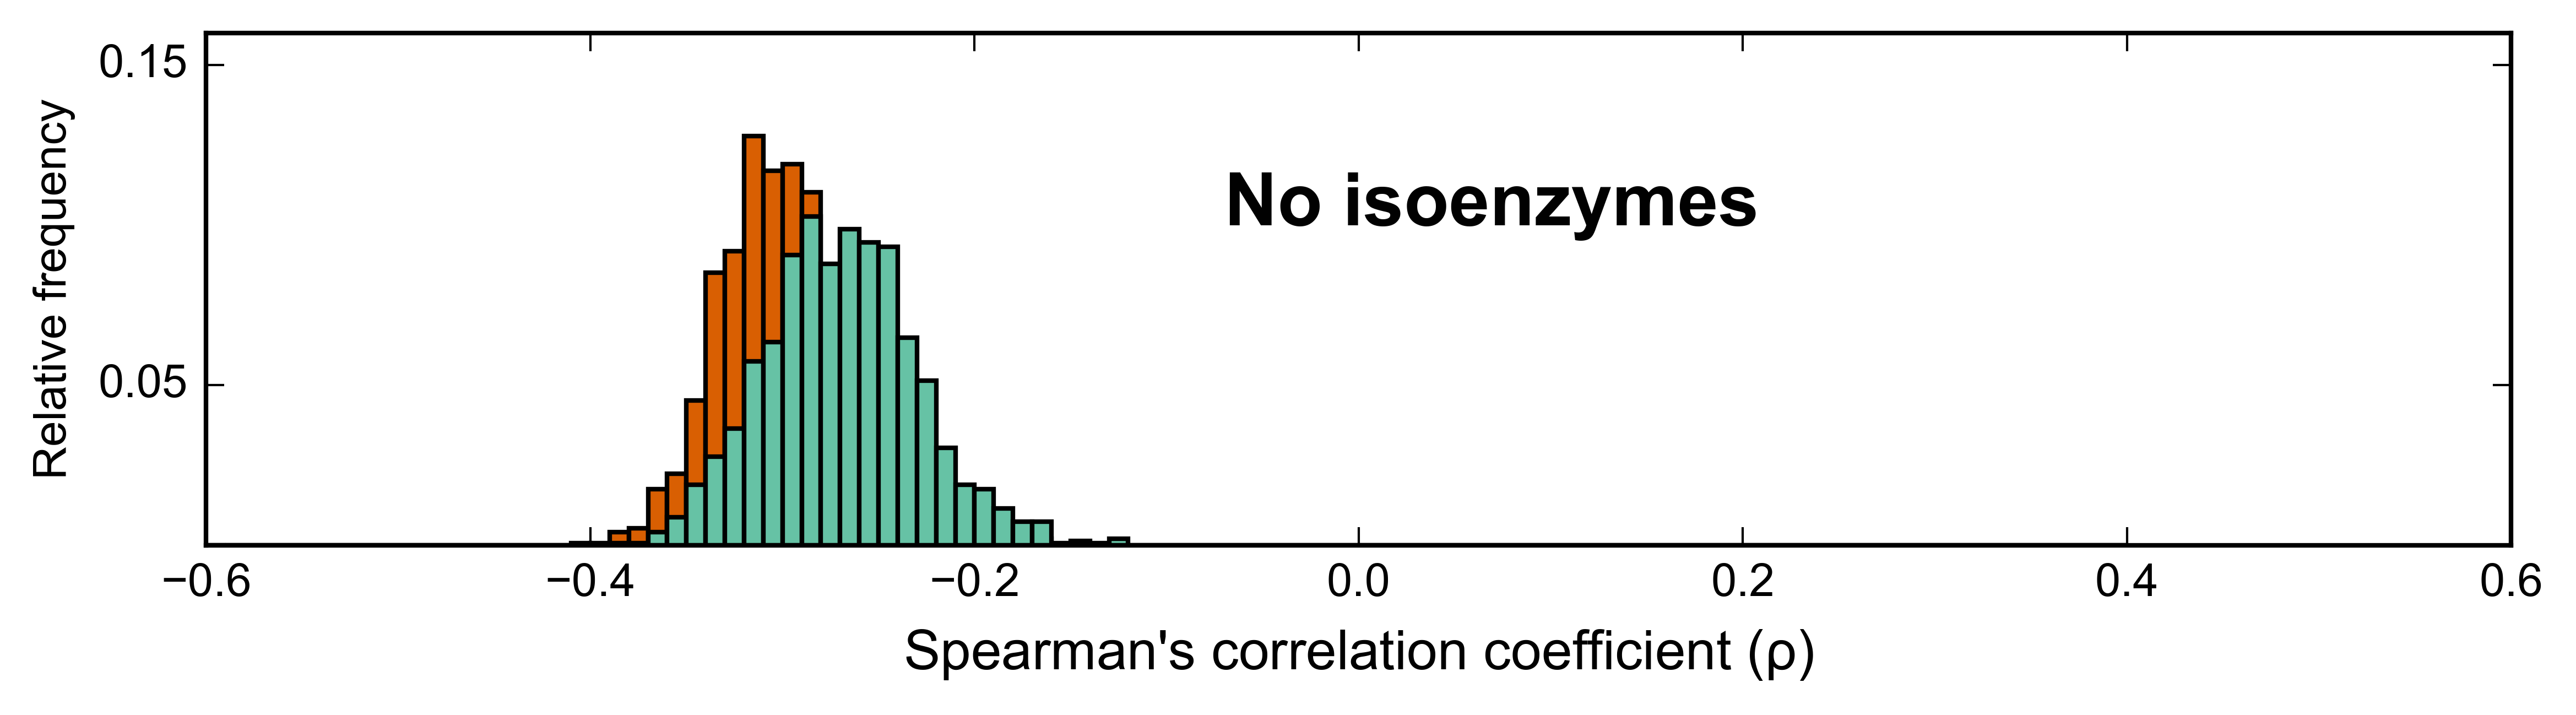

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLCNoIso, rhosFLCNoIso, 'No isoenzymes')

p-value: 2.70e-243


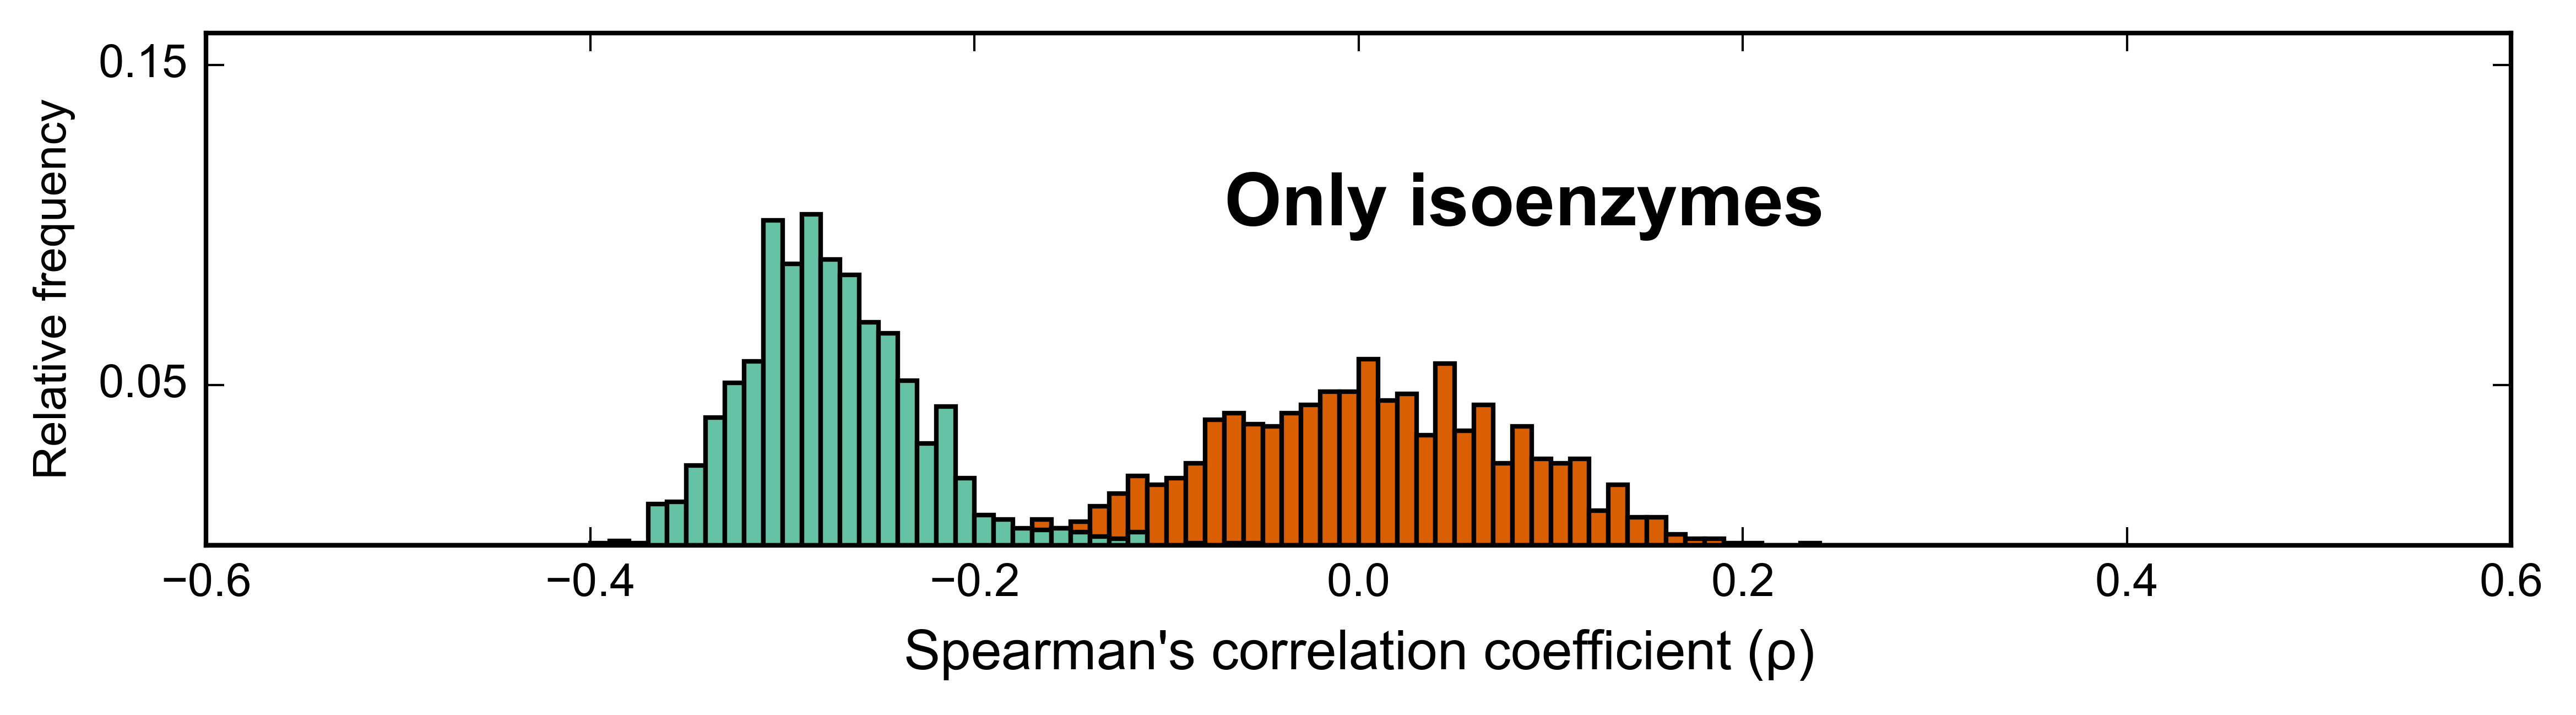

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLCIso, rhosFLCIso, 'Only isoenzymes')

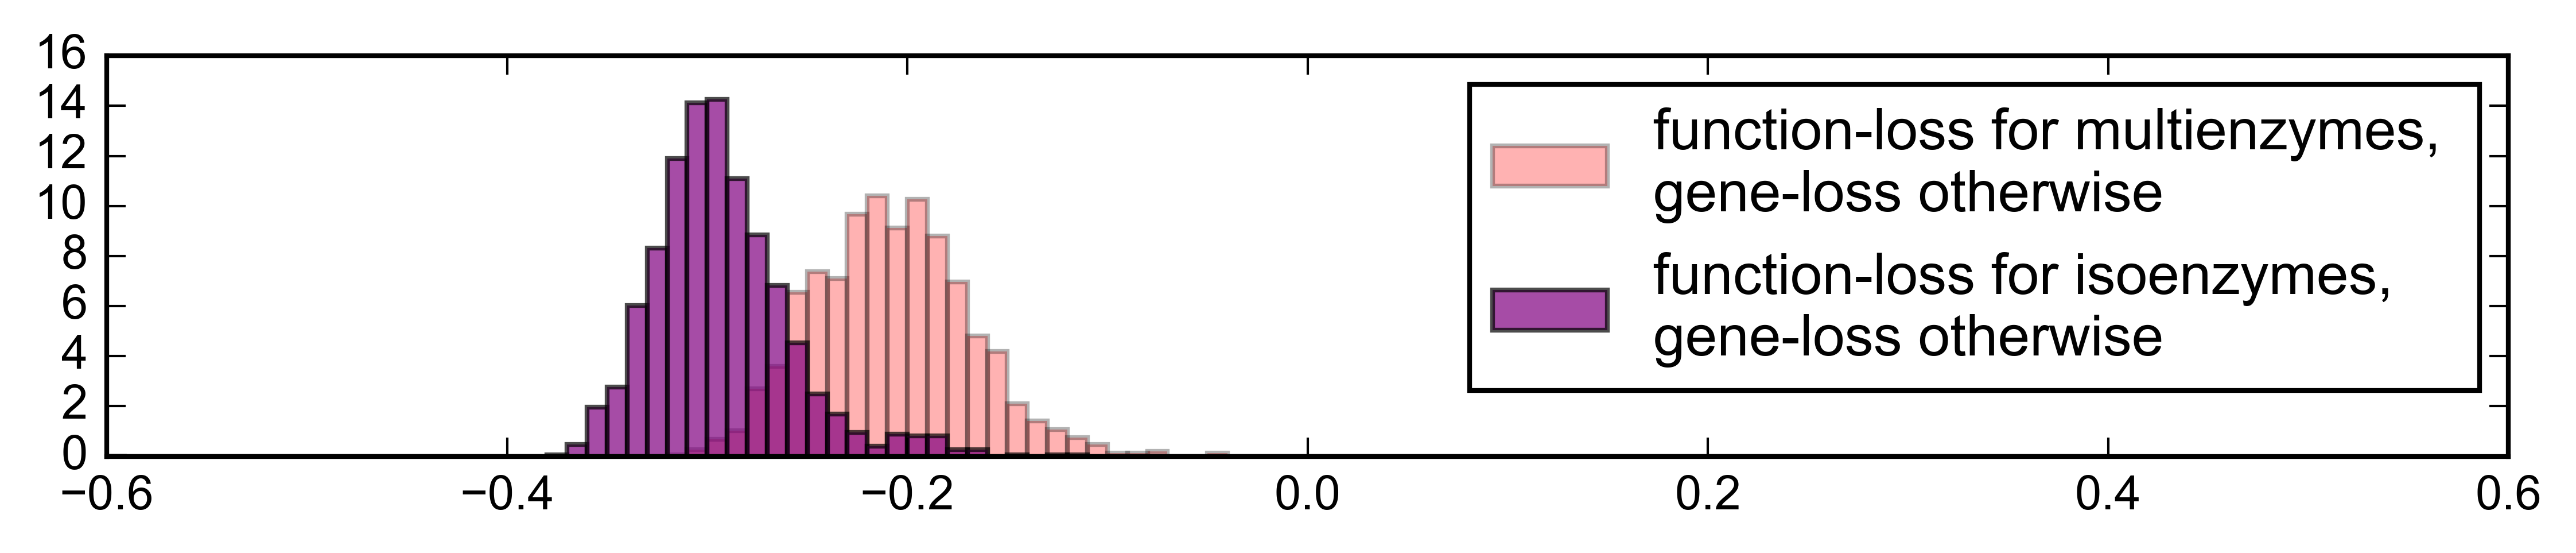

In [20]:
plt.figure(figsize=(9,1.5))
nBins = 100
rng = (-0.6, 0.4)
plt.hist(rhosHybrid1, bins=nBins, range=rng, color='red', normed=True, alpha=0.3,
         label='function-loss for multienzymes, \ngene-loss otherwise')
plt.hist(rhosHybrid2, bins=nBins, range=rng, color='purple', normed=True, alpha=0.7,
         label='function-loss for isoenzymes, \ngene-loss otherwise')
plt.legend()
plt.show()

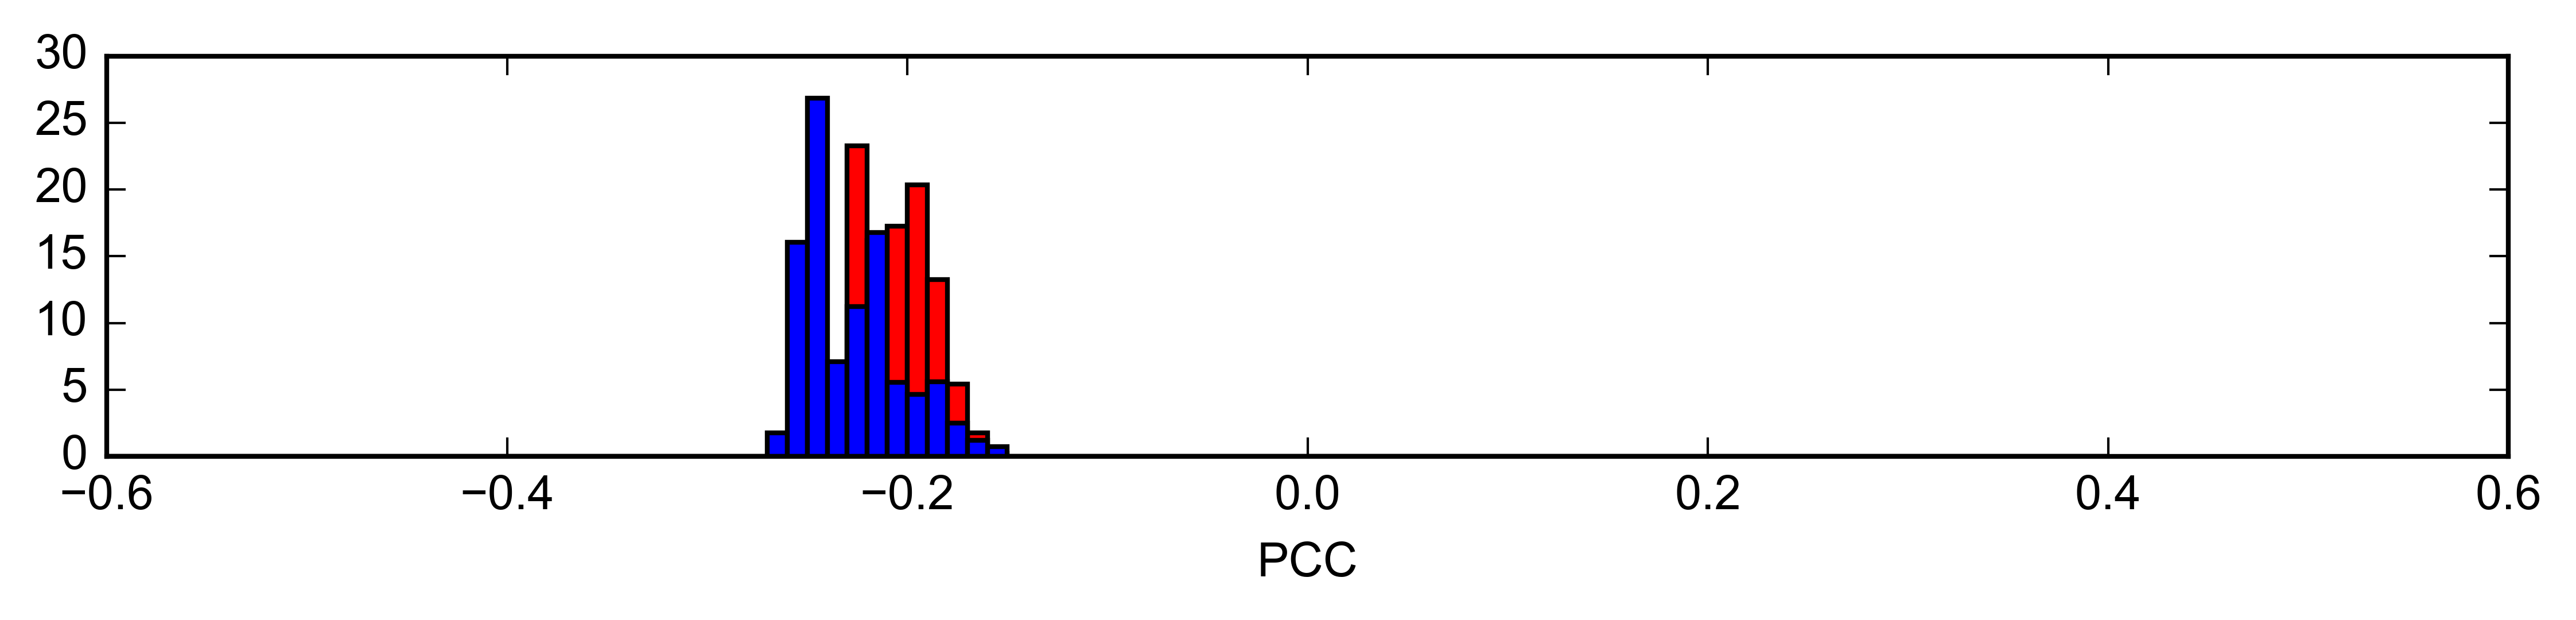

In [21]:
"""Check that we see similar results with PCC instead of Spearman's."""
genesOK = [g for g in genes if not np.isnan(g.dndsRank)]
rsOld = [pearsonr([gene.geneLossCosts[i] for gene in genesOK], 
                     [gene.dndsRank for gene in genesOK])[0] 
           for i in range(nConditions)]
rsNew = [pearsonr([gene.functionLossCosts[i] for gene in genesOK], 
                     [gene.dndsRank for gene in genesOK])[0] 
           for i in range(nConditions)]
plt.figure(figsize=(9,1.5))
plt.hist(rsOld, bins=nBins, range=rng, color='red', normed=True)
plt.hist(rsNew, bins=nBins, range=rng, color='blue', normed=True)
plt.xlabel('PCC')
plt.show()

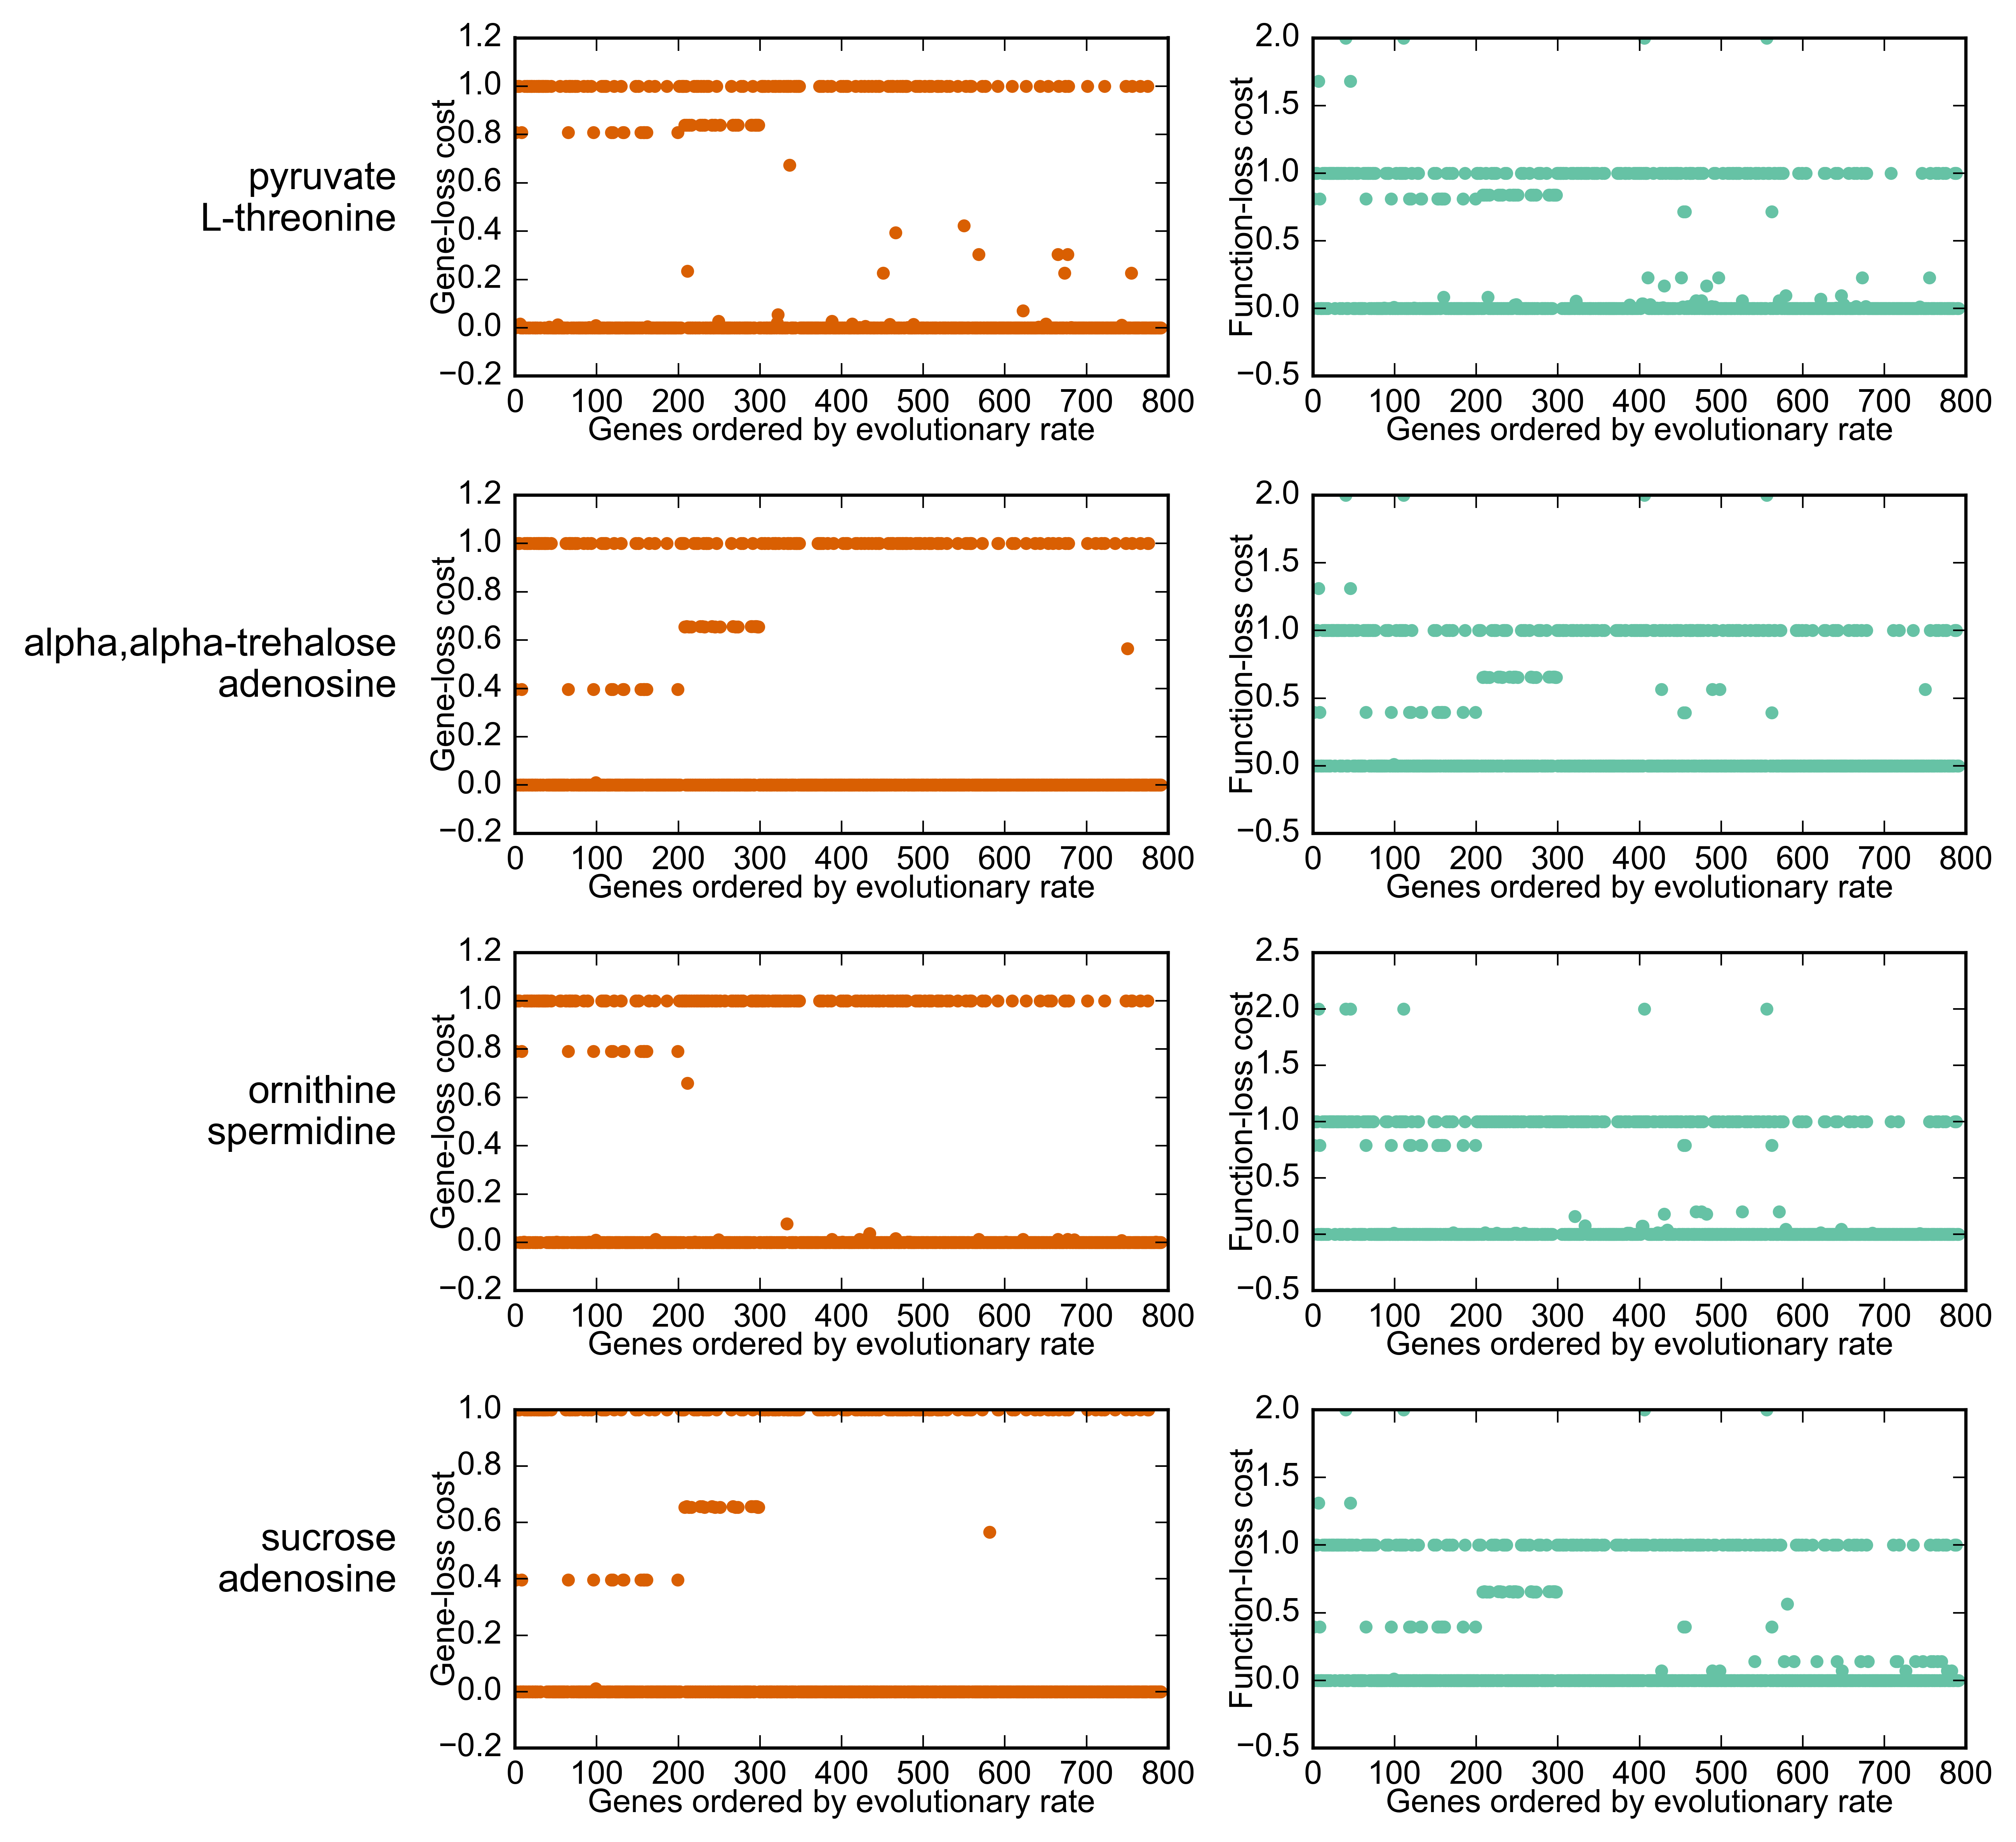

In [22]:
"""Figure S1"""


def plot_ranked_gene_loss_costs(ax, mediaIndex):
    ax.plot([g.geneLossCosts[mediaIndex] for g in sorted(genes, key=lambda x: x.dndsRank)],
             'o', color='#d95f02', markersize=4, markeredgewidth=0.)
    ax.set_ylabel('Gene-loss cost', labelpad=-7.)
    ax.set_xlabel('Genes ordered by evolutionary rate', 
                  labelpad=-0.5)

    
def plot_ranked_function_loss_costs(ax, mediaIndex):
    ax.plot([g.functionLossCosts[mediaIndex] for g in sorted(genes, key=lambda x: x.dndsRank)],
             'o', color='#66c2a5', markersize=4, markeredgewidth=0.)
    ax.set_ylabel('Function-loss cost', labelpad=-7.)
    ax.set_xlabel('Genes ordered by evolutionary rate',
                  labelpad=-0.5)
    
    
a = np.argmin(rhosGLC)
b = np.argmax(rhosGLC)
c = np.argmin(rhosFLC)
d = np.argmax(rhosFLC)
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(7, 8)
plot_ranked_gene_loss_costs(ax[0, 0], a)
plot_ranked_function_loss_costs(ax[0, 1], a)
plot_ranked_gene_loss_costs(ax[1, 0], b)
plot_ranked_function_loss_costs(ax[1, 1], b)
plot_ranked_gene_loss_costs(ax[2, 0], c)
plot_ranked_function_loss_costs(ax[2, 1], c)
plot_ranked_gene_loss_costs(ax[3, 0], d)
plot_ranked_function_loss_costs(ax[3, 1], d)
fig.text(0.0, 0.87, '\n'.join(minimalMedia[a]), fontsize=12, ha='right')
fig.text(0.0, 0.62, '\n'.join(minimalMedia[b]), fontsize=12, ha='right')
fig.text(0.0, 0.38, '\n'.join(minimalMedia[c]), fontsize=12, ha='right')
fig.text(0.0, 0.14, '\n'.join(minimalMedia[d]), fontsize=12, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'FigureS1.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'FigureS1.svg'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'FigureS1.eps'), bbox_inches='tight')
plt.show()

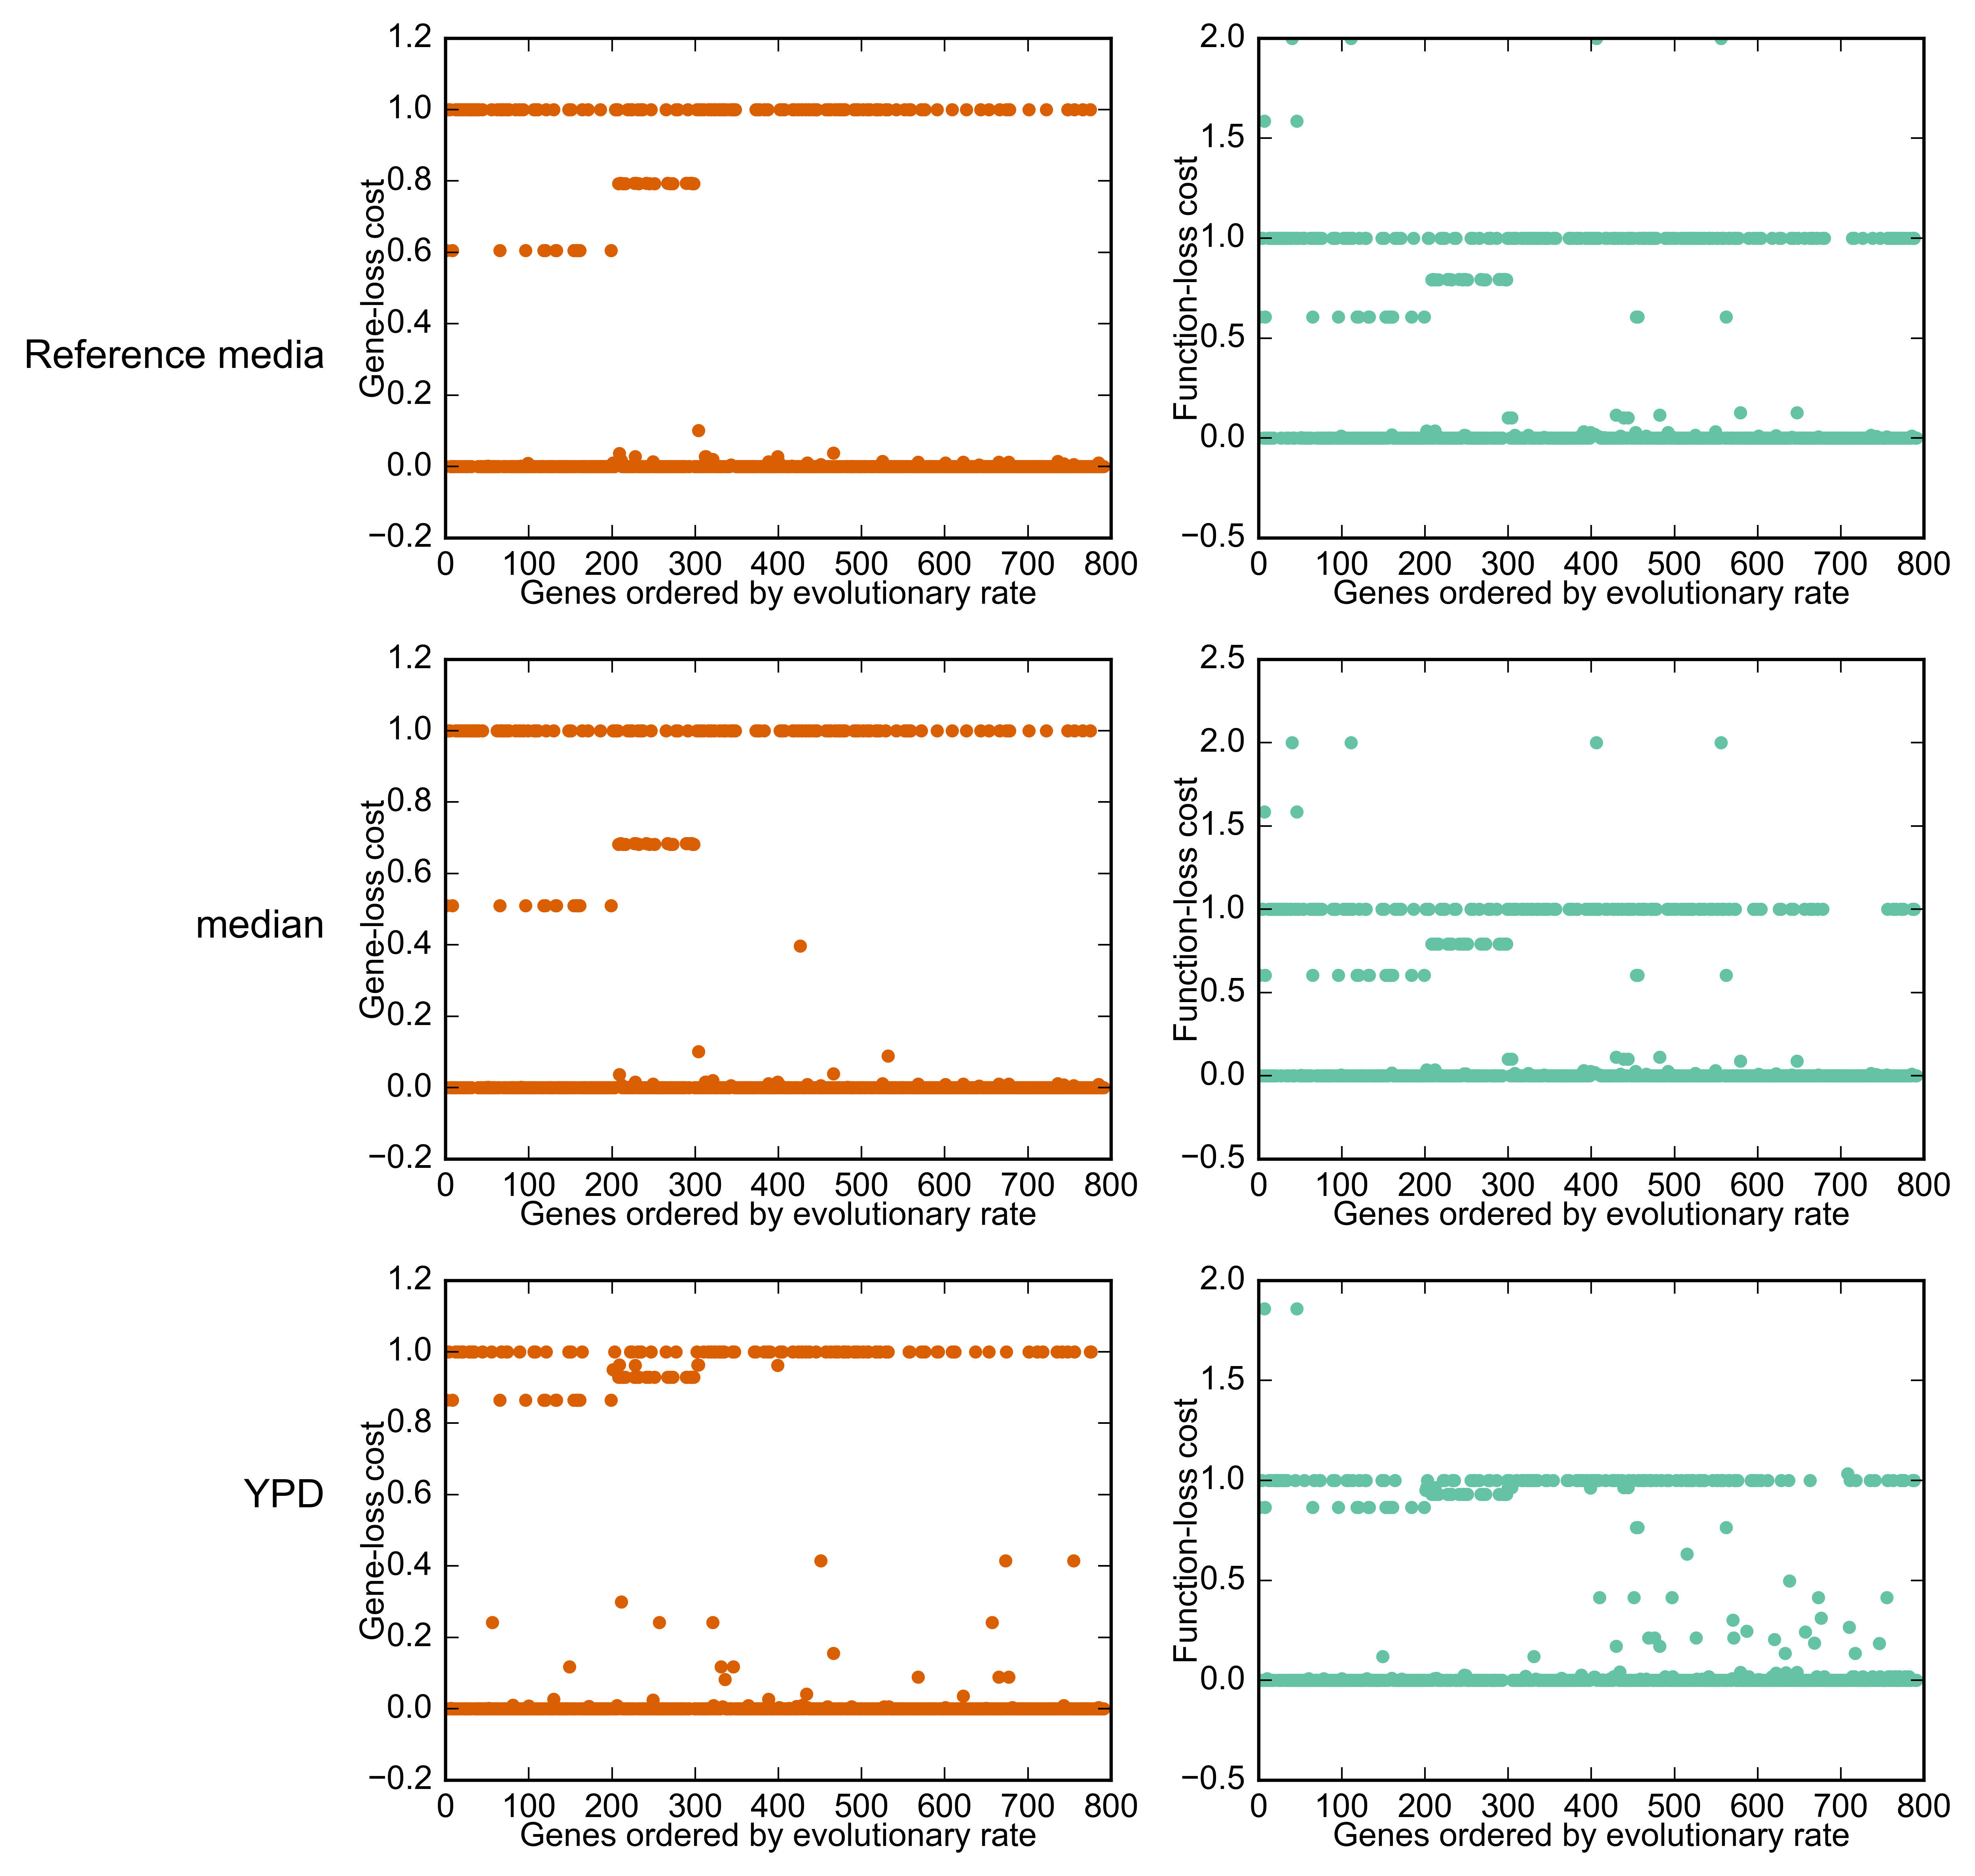

In [23]:
"""Figure S2"""
ypd = load_media(modelPath, 'ypd')
refIndex = minimalMedia.index(('D-glucose', 'ammonium'))
medianGLCindex = rhosGLC.index(np.median(rhosGLC))
medianFLCindex = rhosFLC.index(np.median(rhosFLC))
# now do the same for rich media
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(7, 8)
plot_ranked_gene_loss_costs(ax[0, 0], refIndex)
plot_ranked_function_loss_costs(ax[0, 1], refIndex)
plot_ranked_gene_loss_costs(ax[1, 0], medianGLCindex)
plot_ranked_function_loss_costs(ax[1, 1], medianFLCindex)
_didWtGrow, ypdGLC, ypdFLC = single_knockout_loss_costs(ypd)
ax[2, 0].plot([ypdGLC[g.name] for g in sorted(genes, key=lambda x: x.dndsRank)],
             'o', color='#d95f02', markersize=4, markeredgewidth=0.)
ax[2, 0].set_ylabel('Gene-loss cost', labelpad=-7.)
ax[2, 0].set_xlabel('Genes ordered by evolutionary rate', 
                  labelpad=-0.5)
ax[2, 1].plot([ypdFLC[g.name] for g in sorted(genes, key=lambda x: x.dndsRank)],
             'o', color='#66c2a5', markersize=4, markeredgewidth=0.)
ax[2, 1].set_ylabel('Function-loss cost', labelpad=-7.)
ax[2, 1].set_xlabel('Genes ordered by evolutionary rate', 
                  labelpad=-0.5)
fig.text(0.0, 0.8, 'Reference media', fontsize=12, ha='right')
fig.text(0.0, 0.5, 'median', fontsize=12, ha='right')
fig.text(0.0, 0.2, 'YPD', fontsize=12, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'FigureS2.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'FigureS2.svg'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'FigureS2.eps'), bbox_inches='tight')
plt.show()

p-value: 1.84e-240
p-value: 1.12e-08


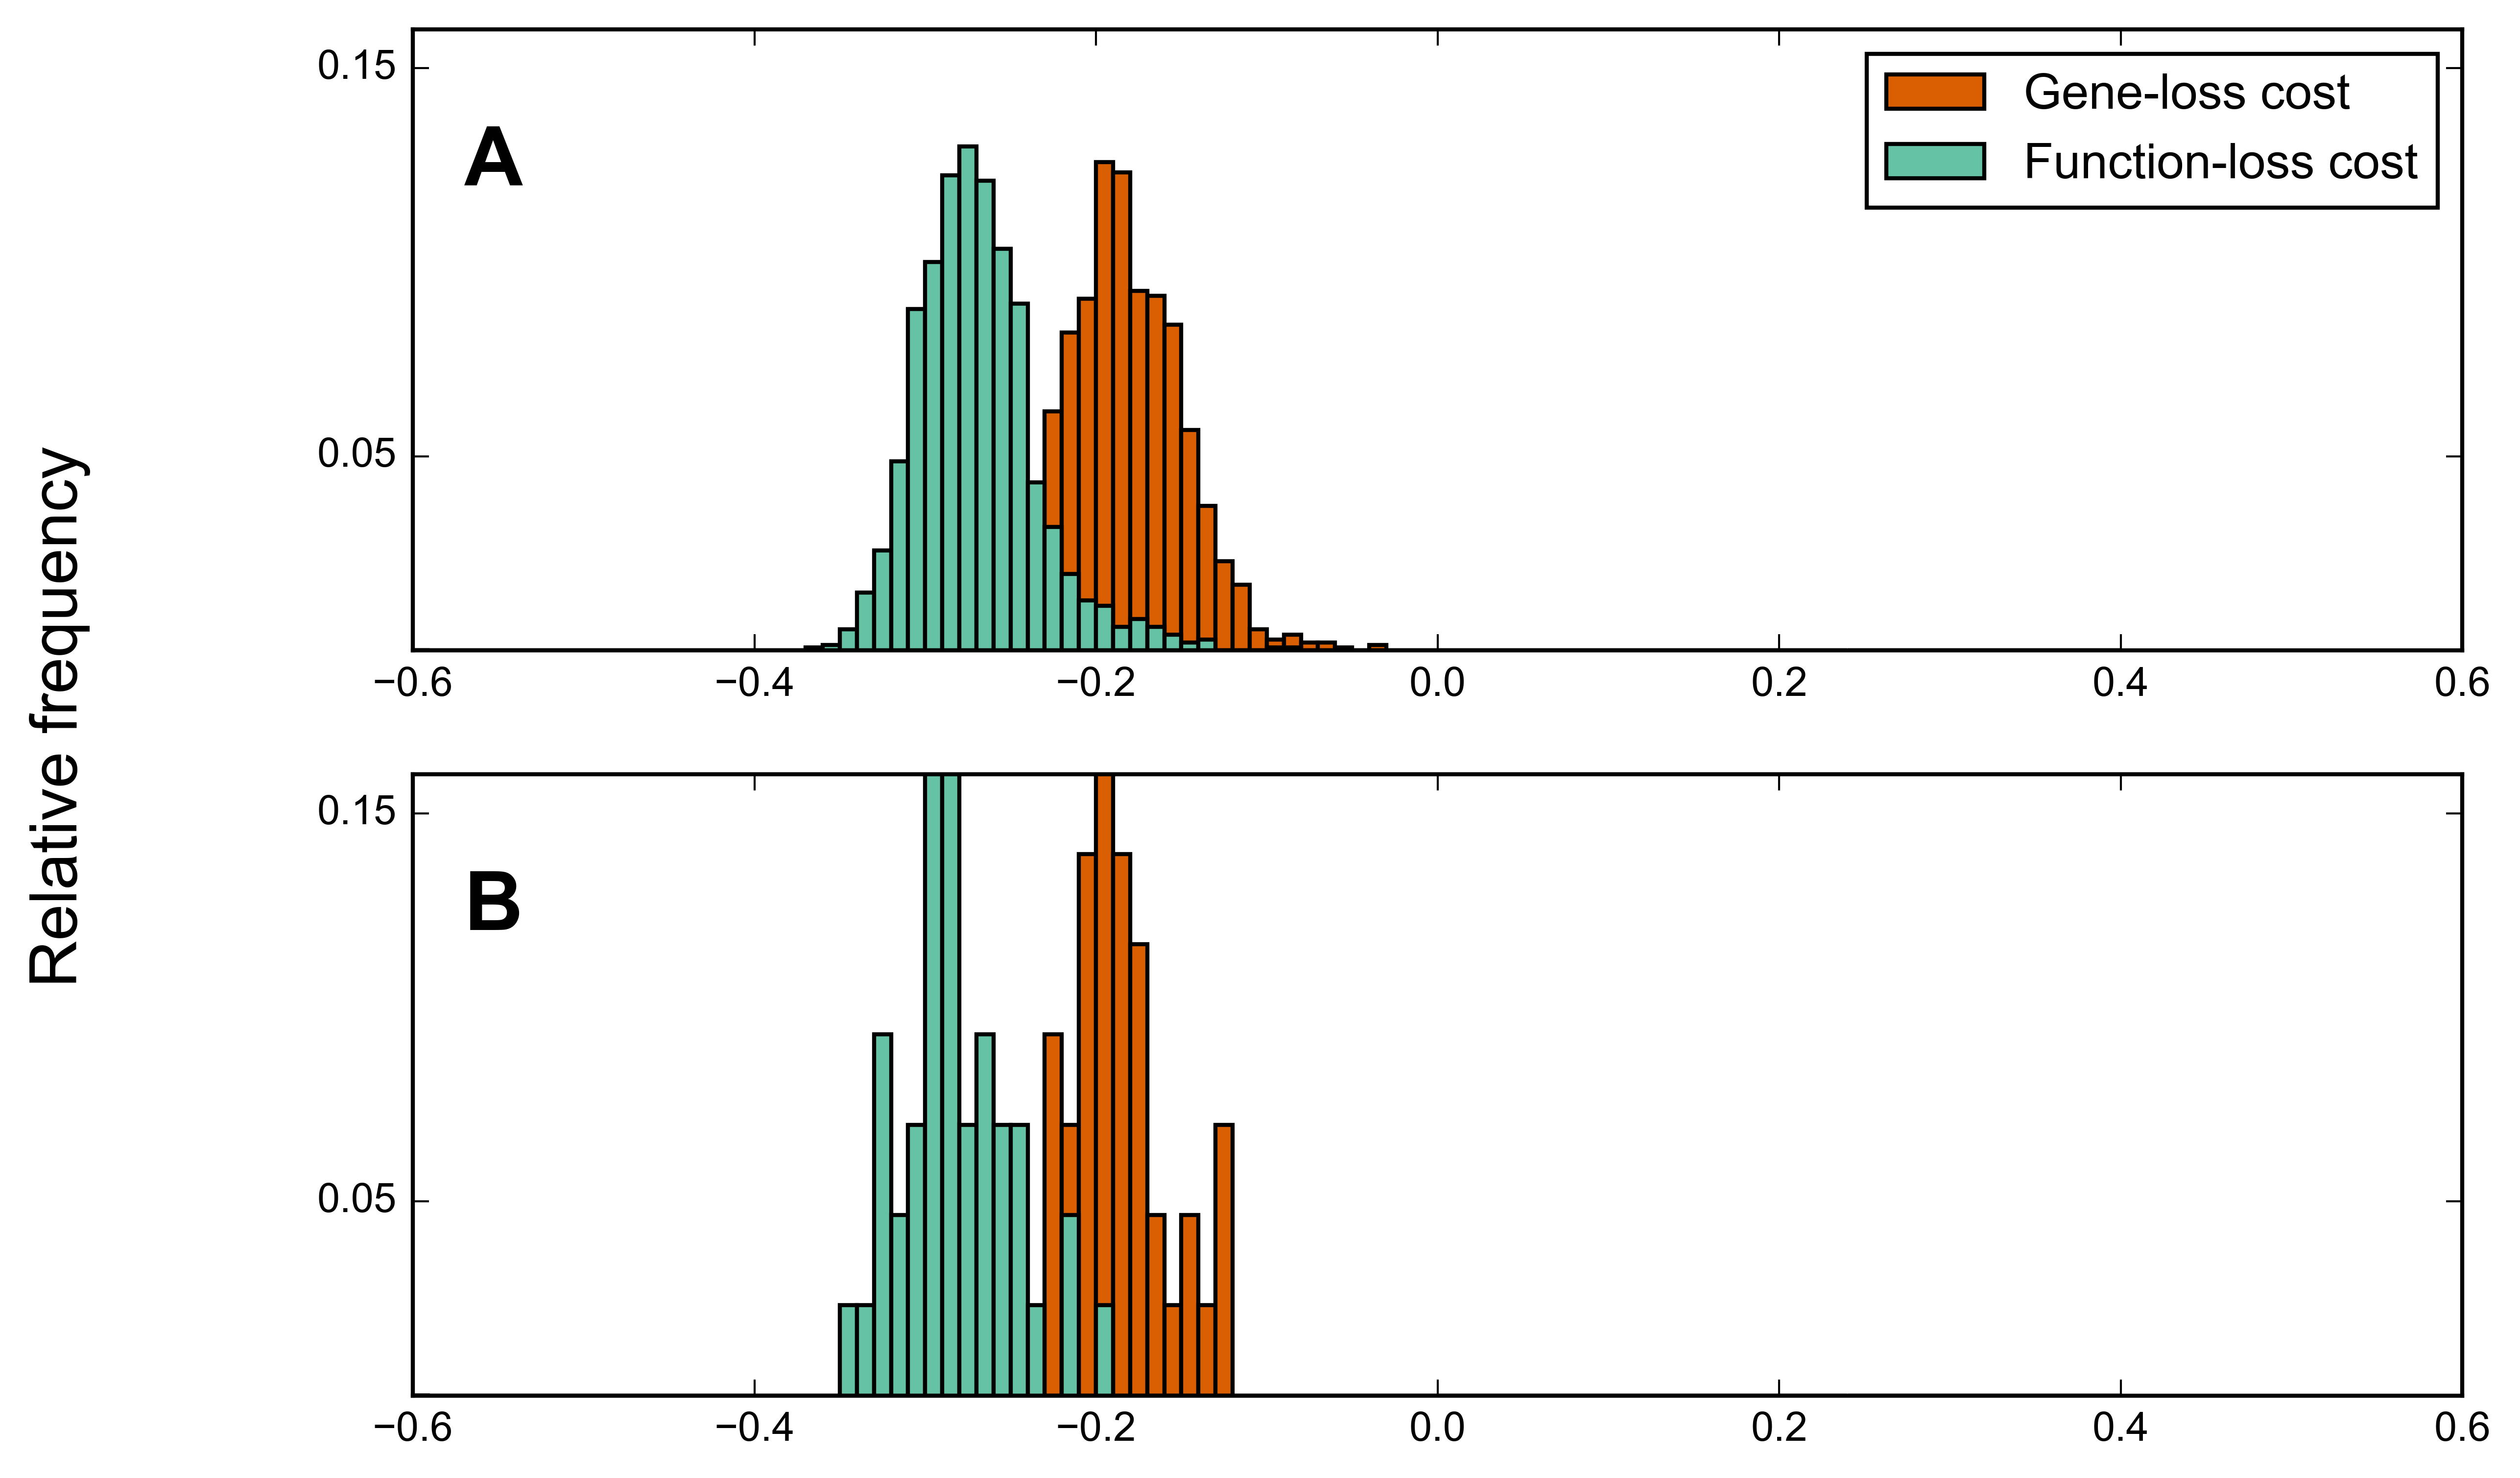

lowest correlation of ammonium with a carbon source is: -0.267234352725 for ('(S)-lactate', 'ammonium')
highest correlation of ammonium with a carbon source is: -0.121310647488 for ('maltose', 'ammonium')


In [24]:
"""Holding nitrogen source constant as ammonium,
investigate the spread of correlations of the carbon sources."""
ammoniumIndices = [i for i, m in enumerate(minimalMedia) if m[1] == 'ammonium']
rhosGLCammonium = [rhosGLC[i] for i in ammoniumIndices]
rhosFLCammonium = [rhosFLC[i] for i in ammoniumIndices]
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(9, 6)
correlation_histograms(ax[0], rhosGLC, rhosFLC, drawLegend=True, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[1], rhosGLCammonium, rhosFLCammonium, drawXlabel=False, 
                       drawYlabel=False)
ax[0].text(-0.57, 0.12, 'A', fontweight='bold', fontsize=20)
ax[1].text(-0.57, 0.12, 'B', fontweight='bold', fontsize=20)
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=16)
plt.show()
print 'lowest correlation of ammonium with a carbon source is:',
print min(rhosGLCammonium), 'for', minimalMedia[ammoniumIndices[np.argmin(rhosGLCammonium)]]
print 'highest correlation of ammonium with a carbon source is:',
print max(rhosGLCammonium), 'for', minimalMedia[ammoniumIndices[np.argmax(rhosGLCammonium)]]

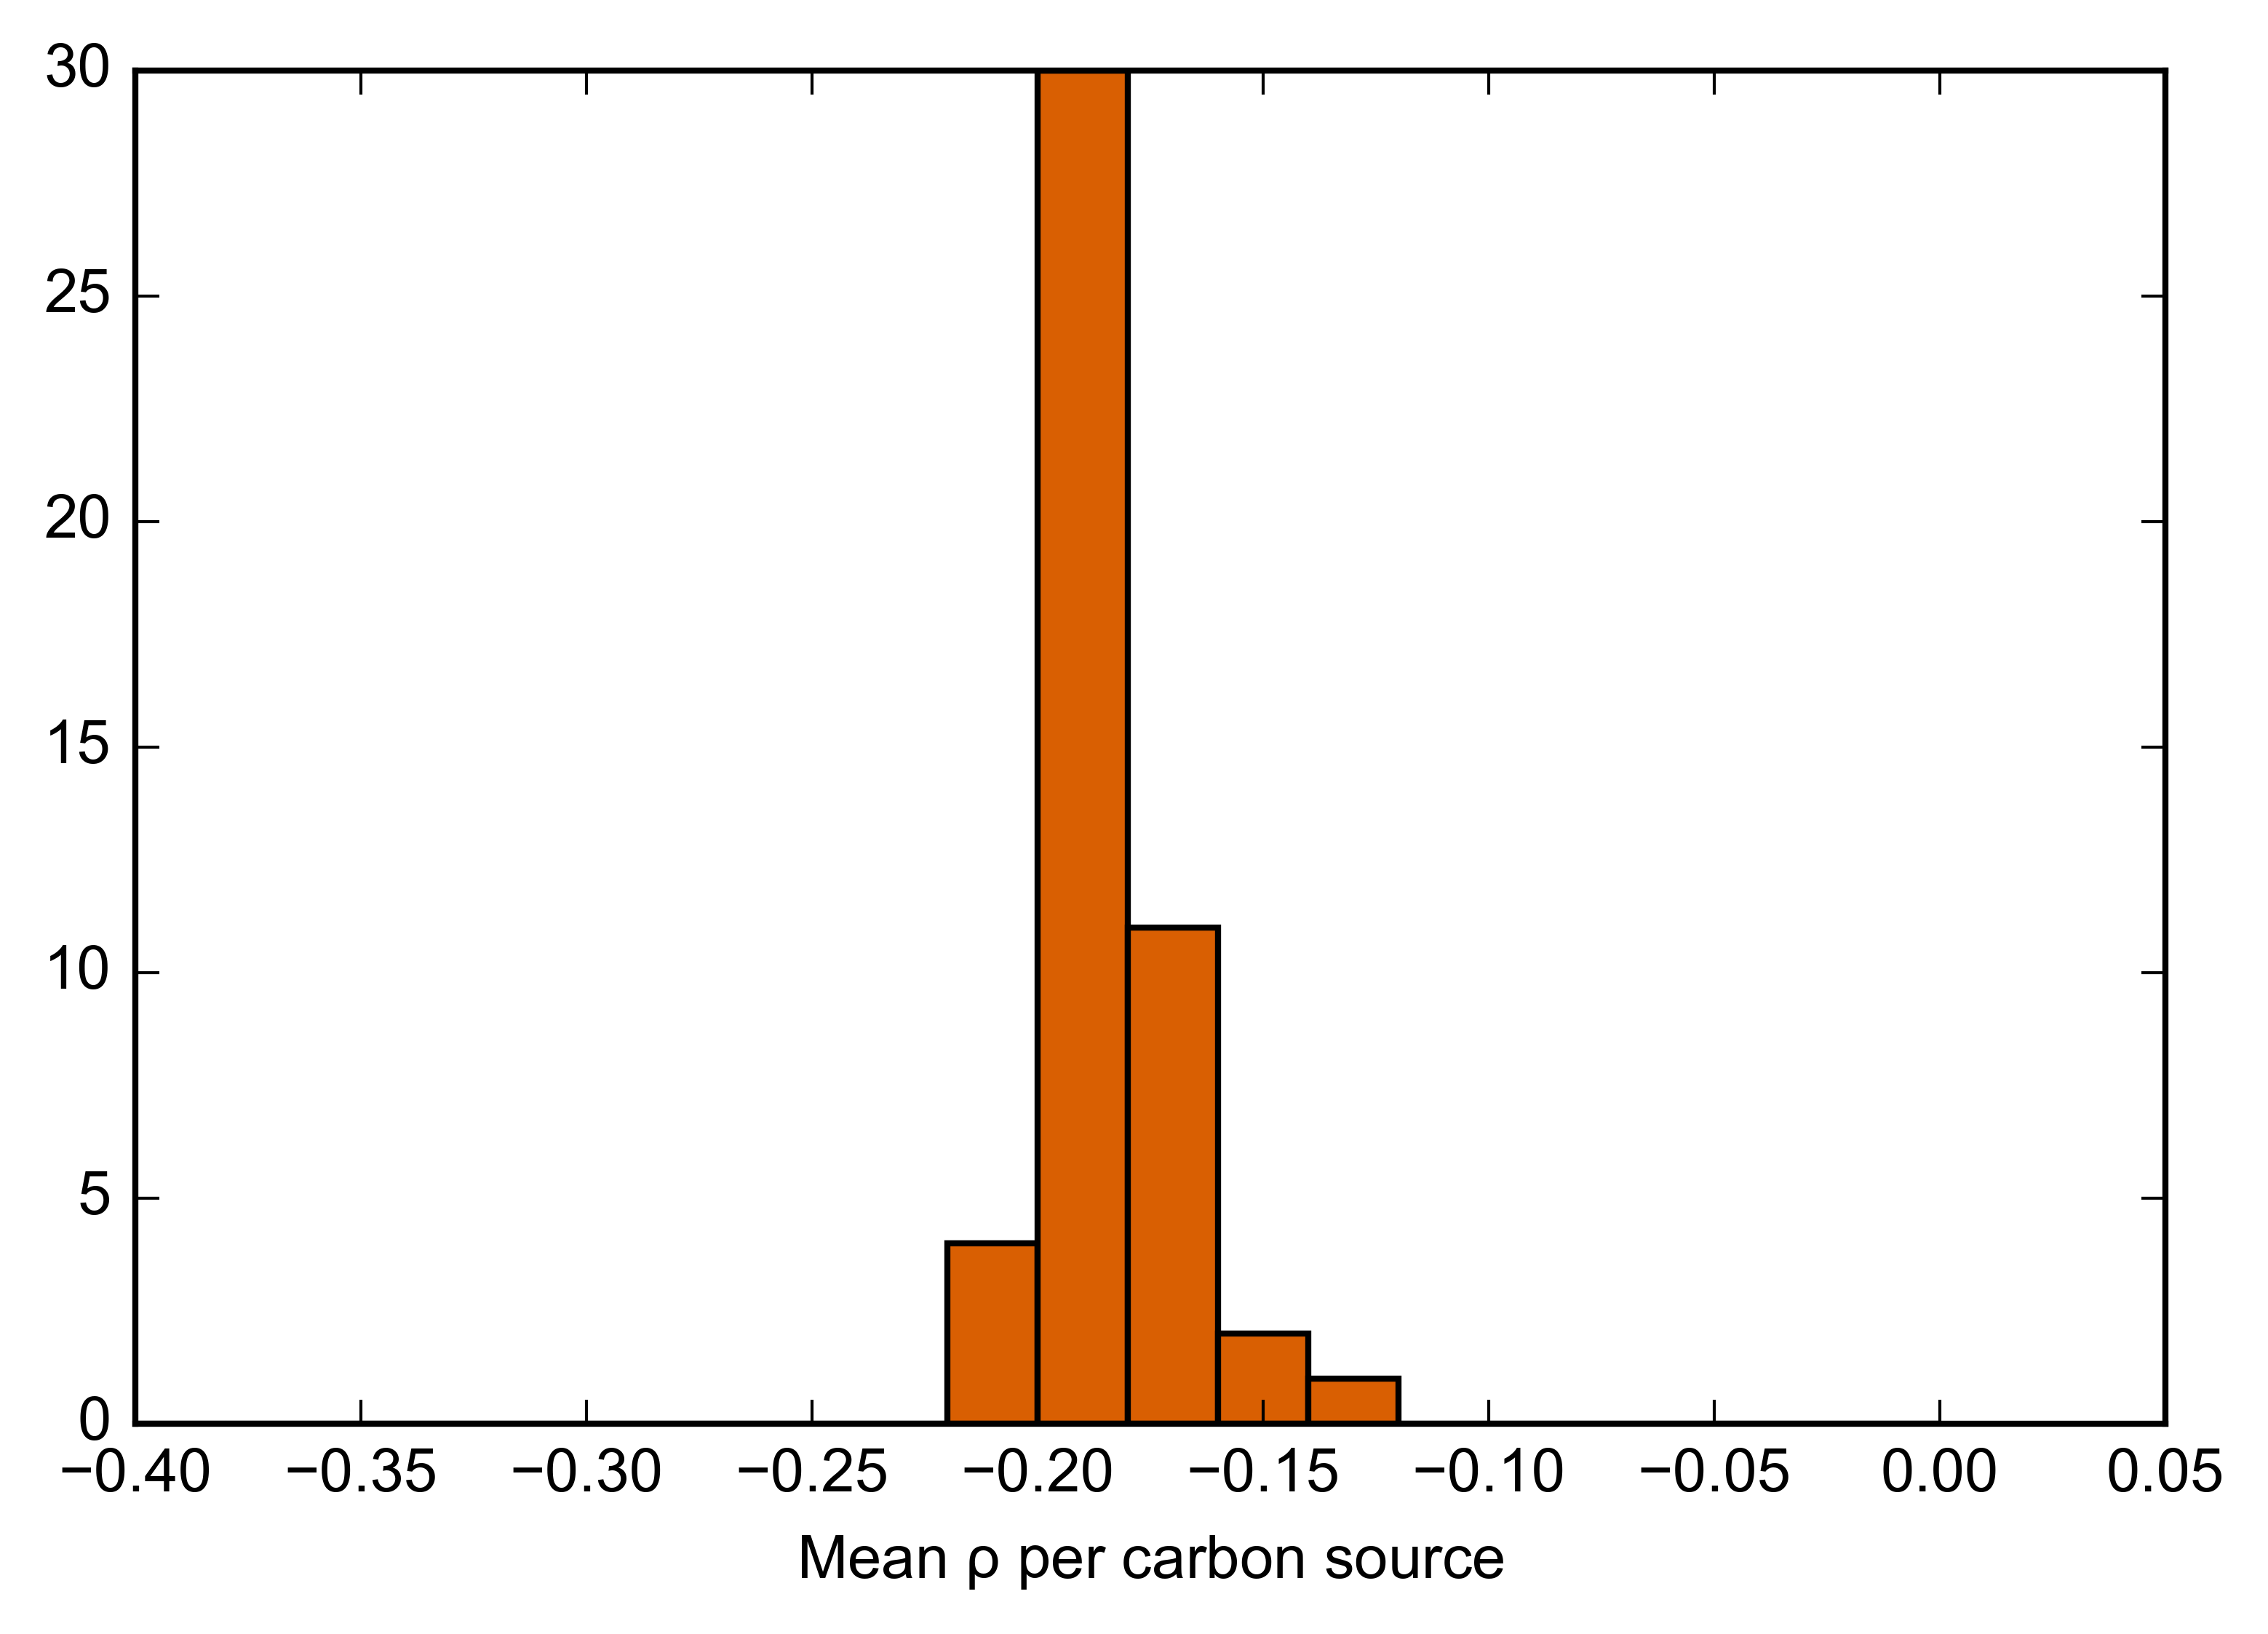

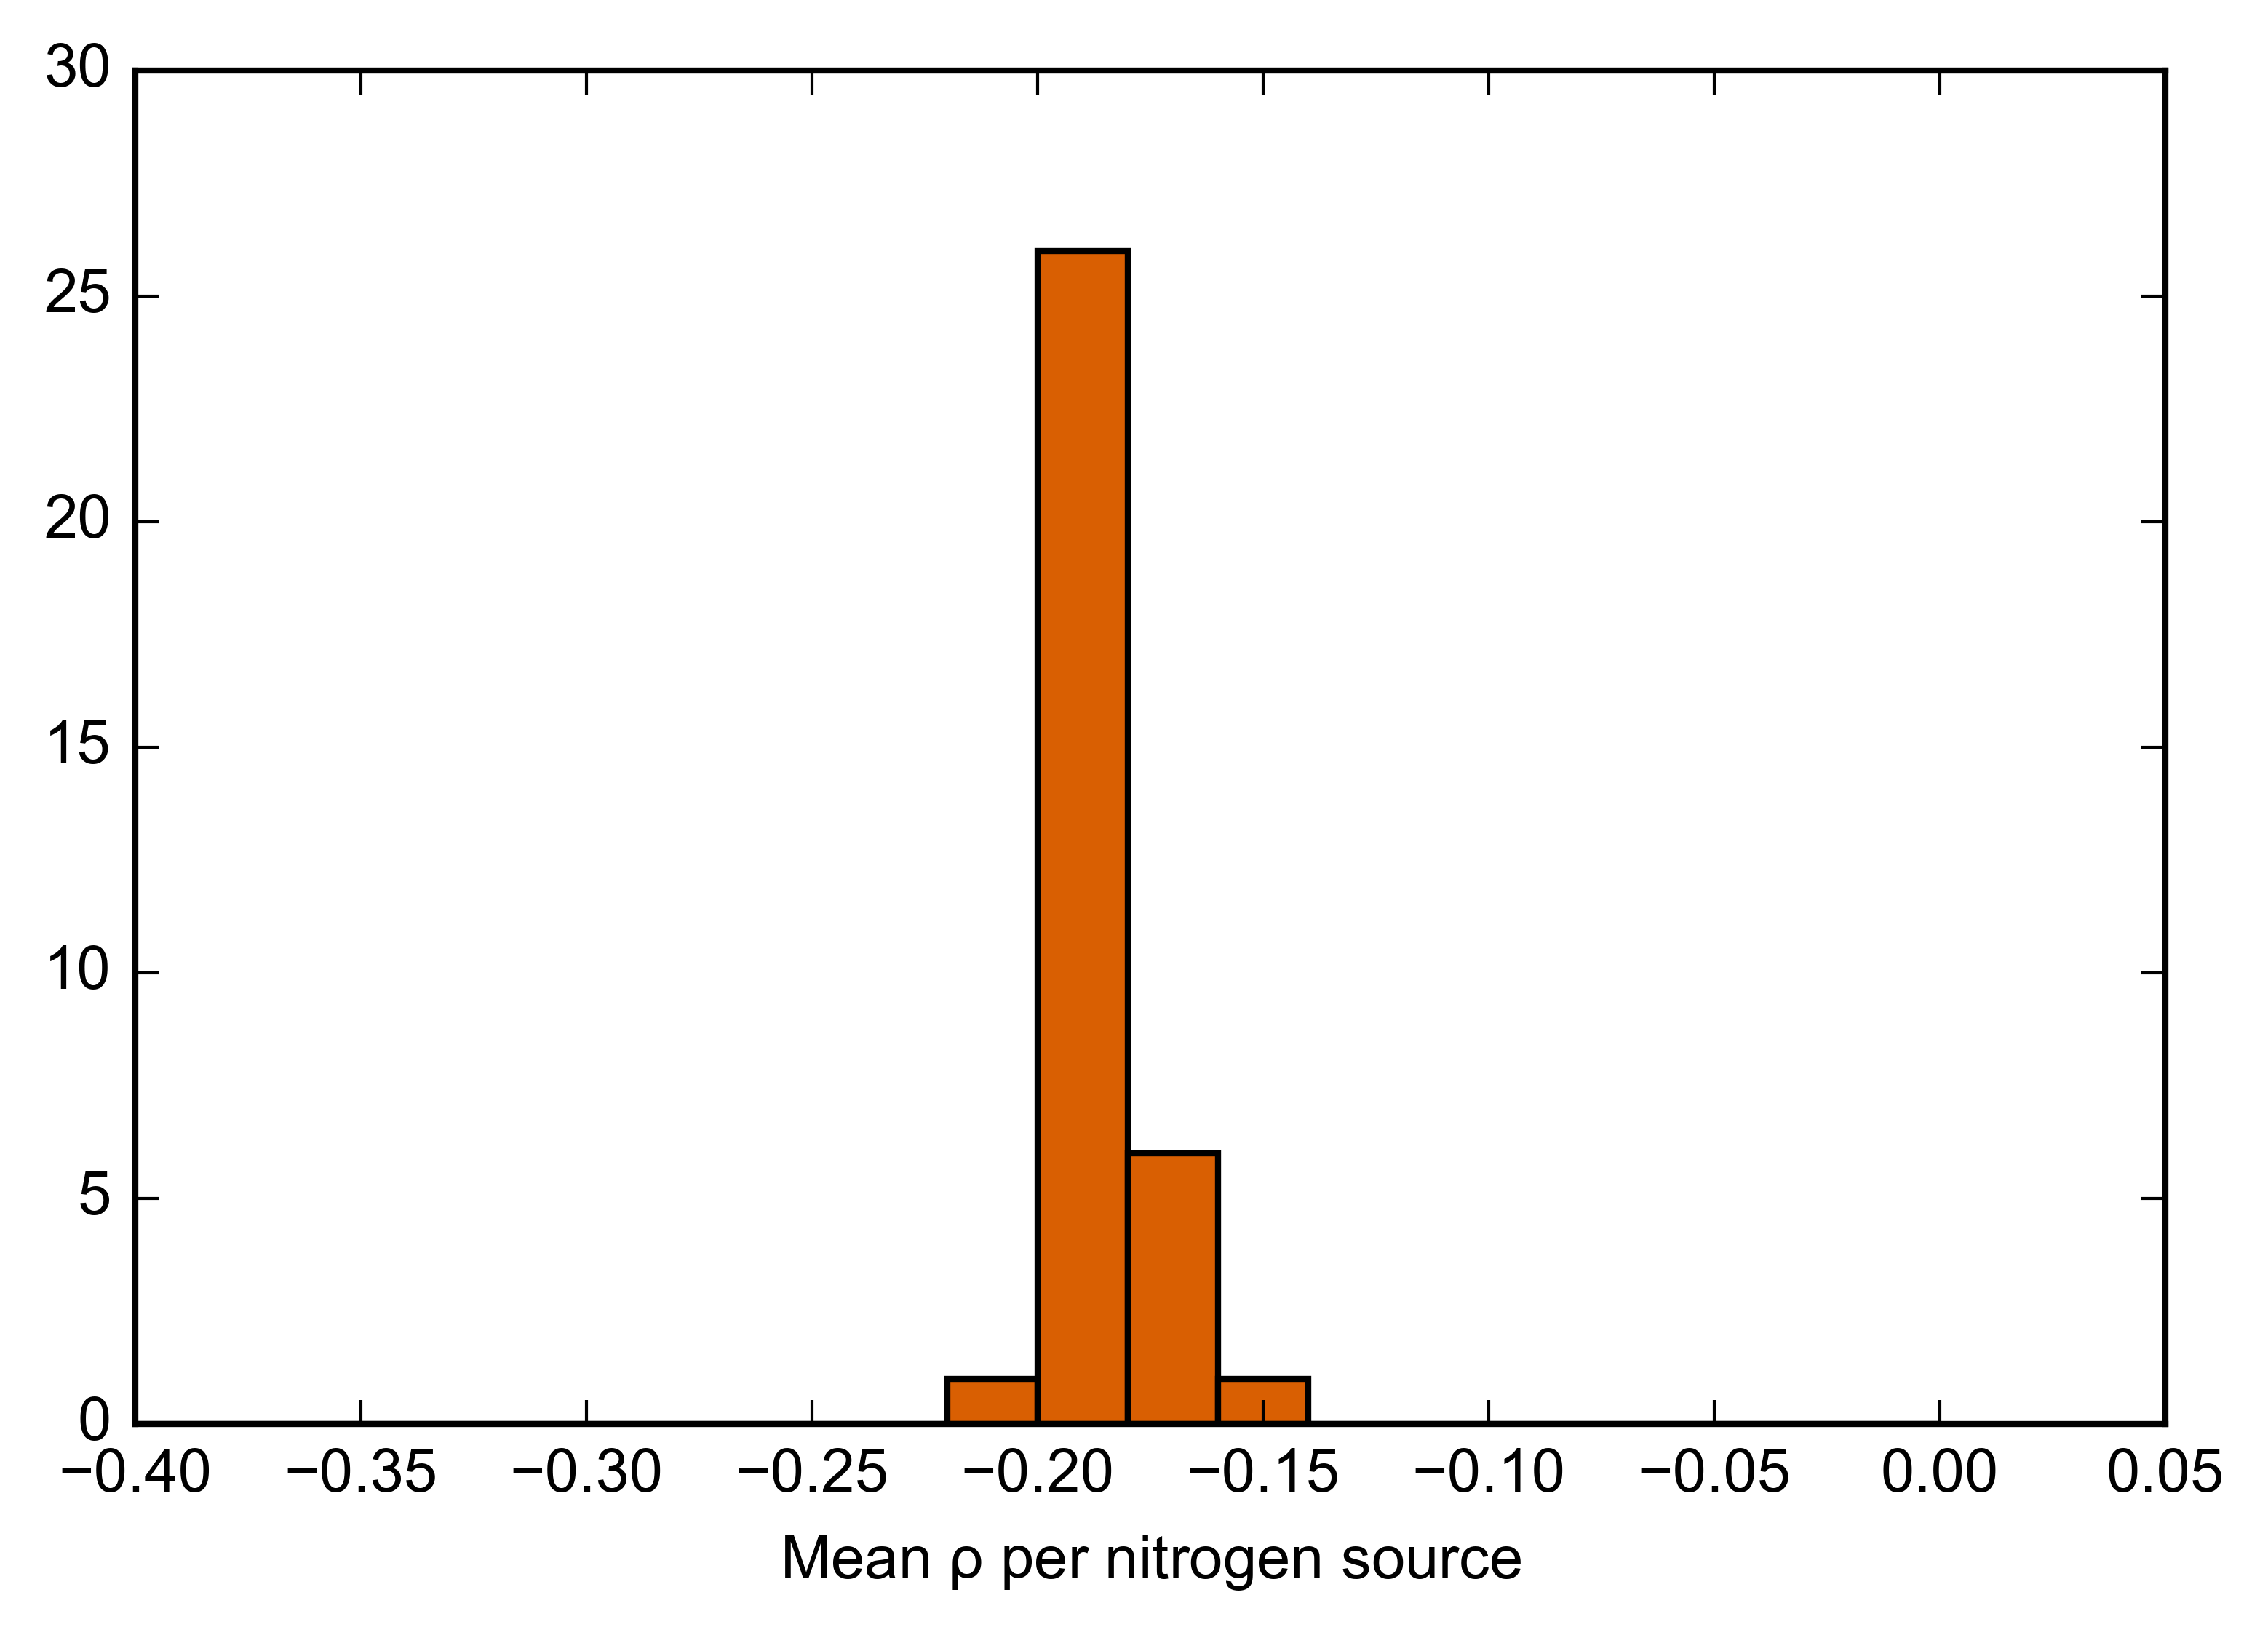

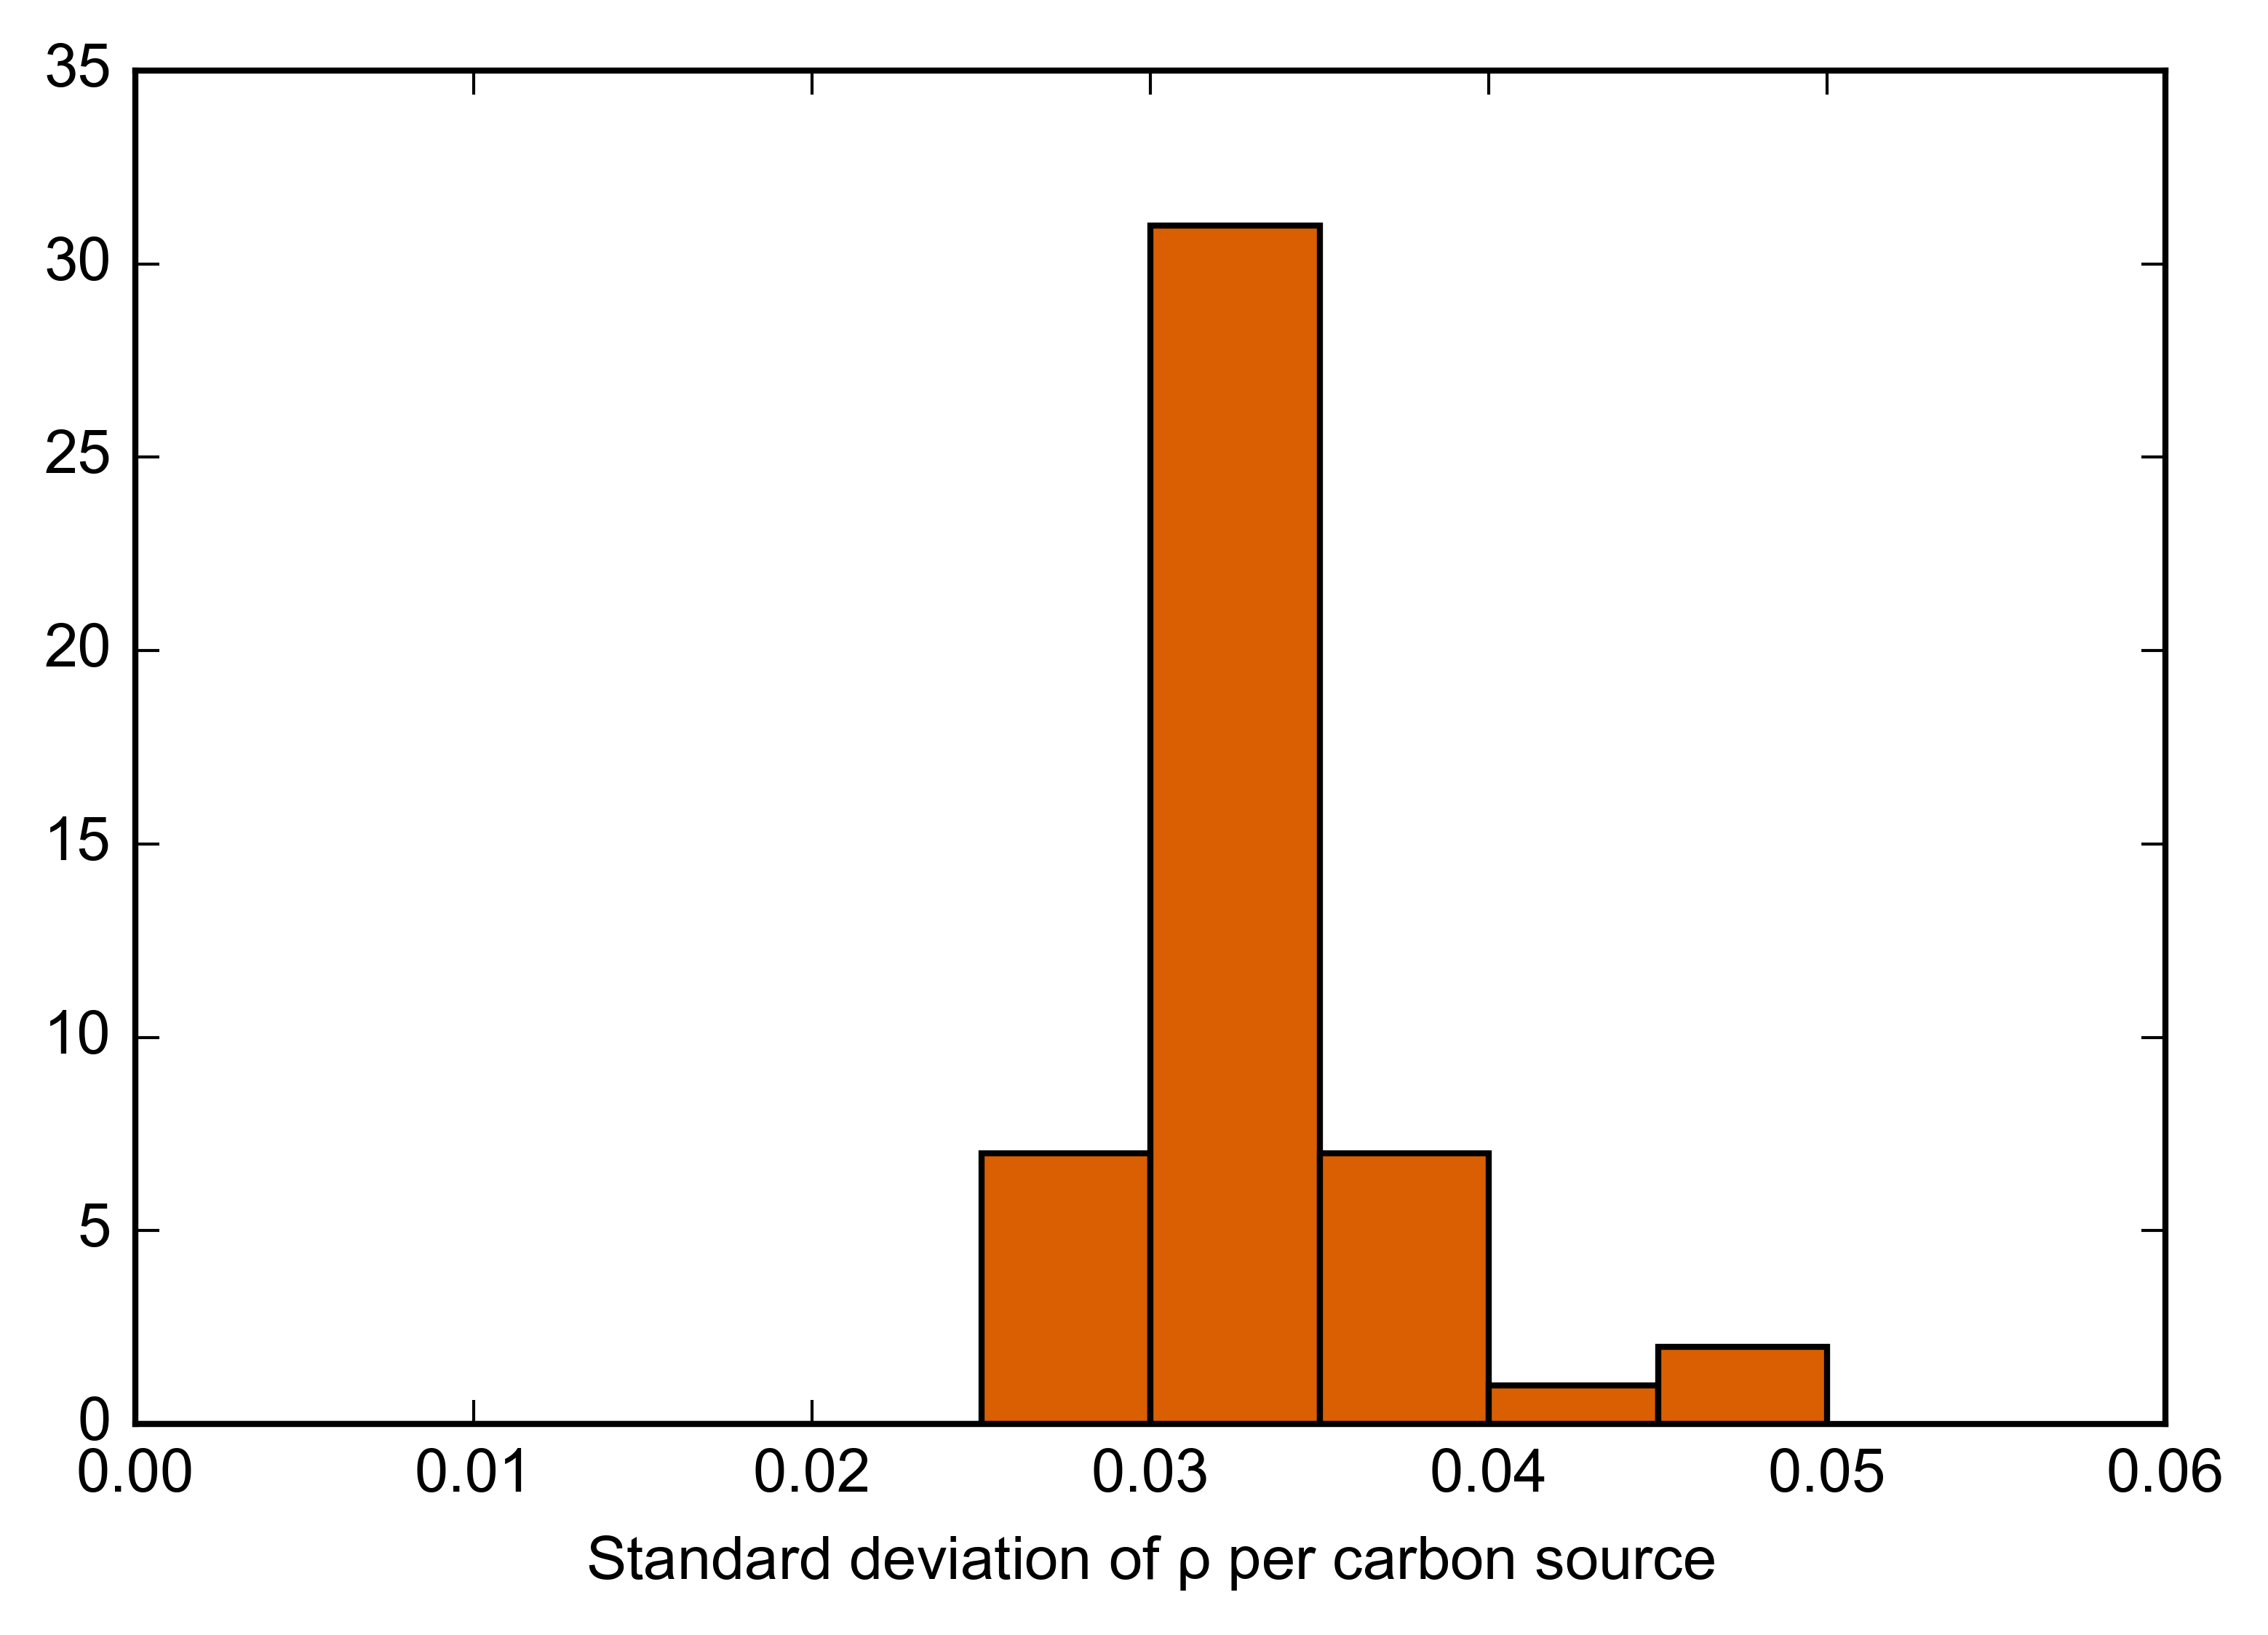

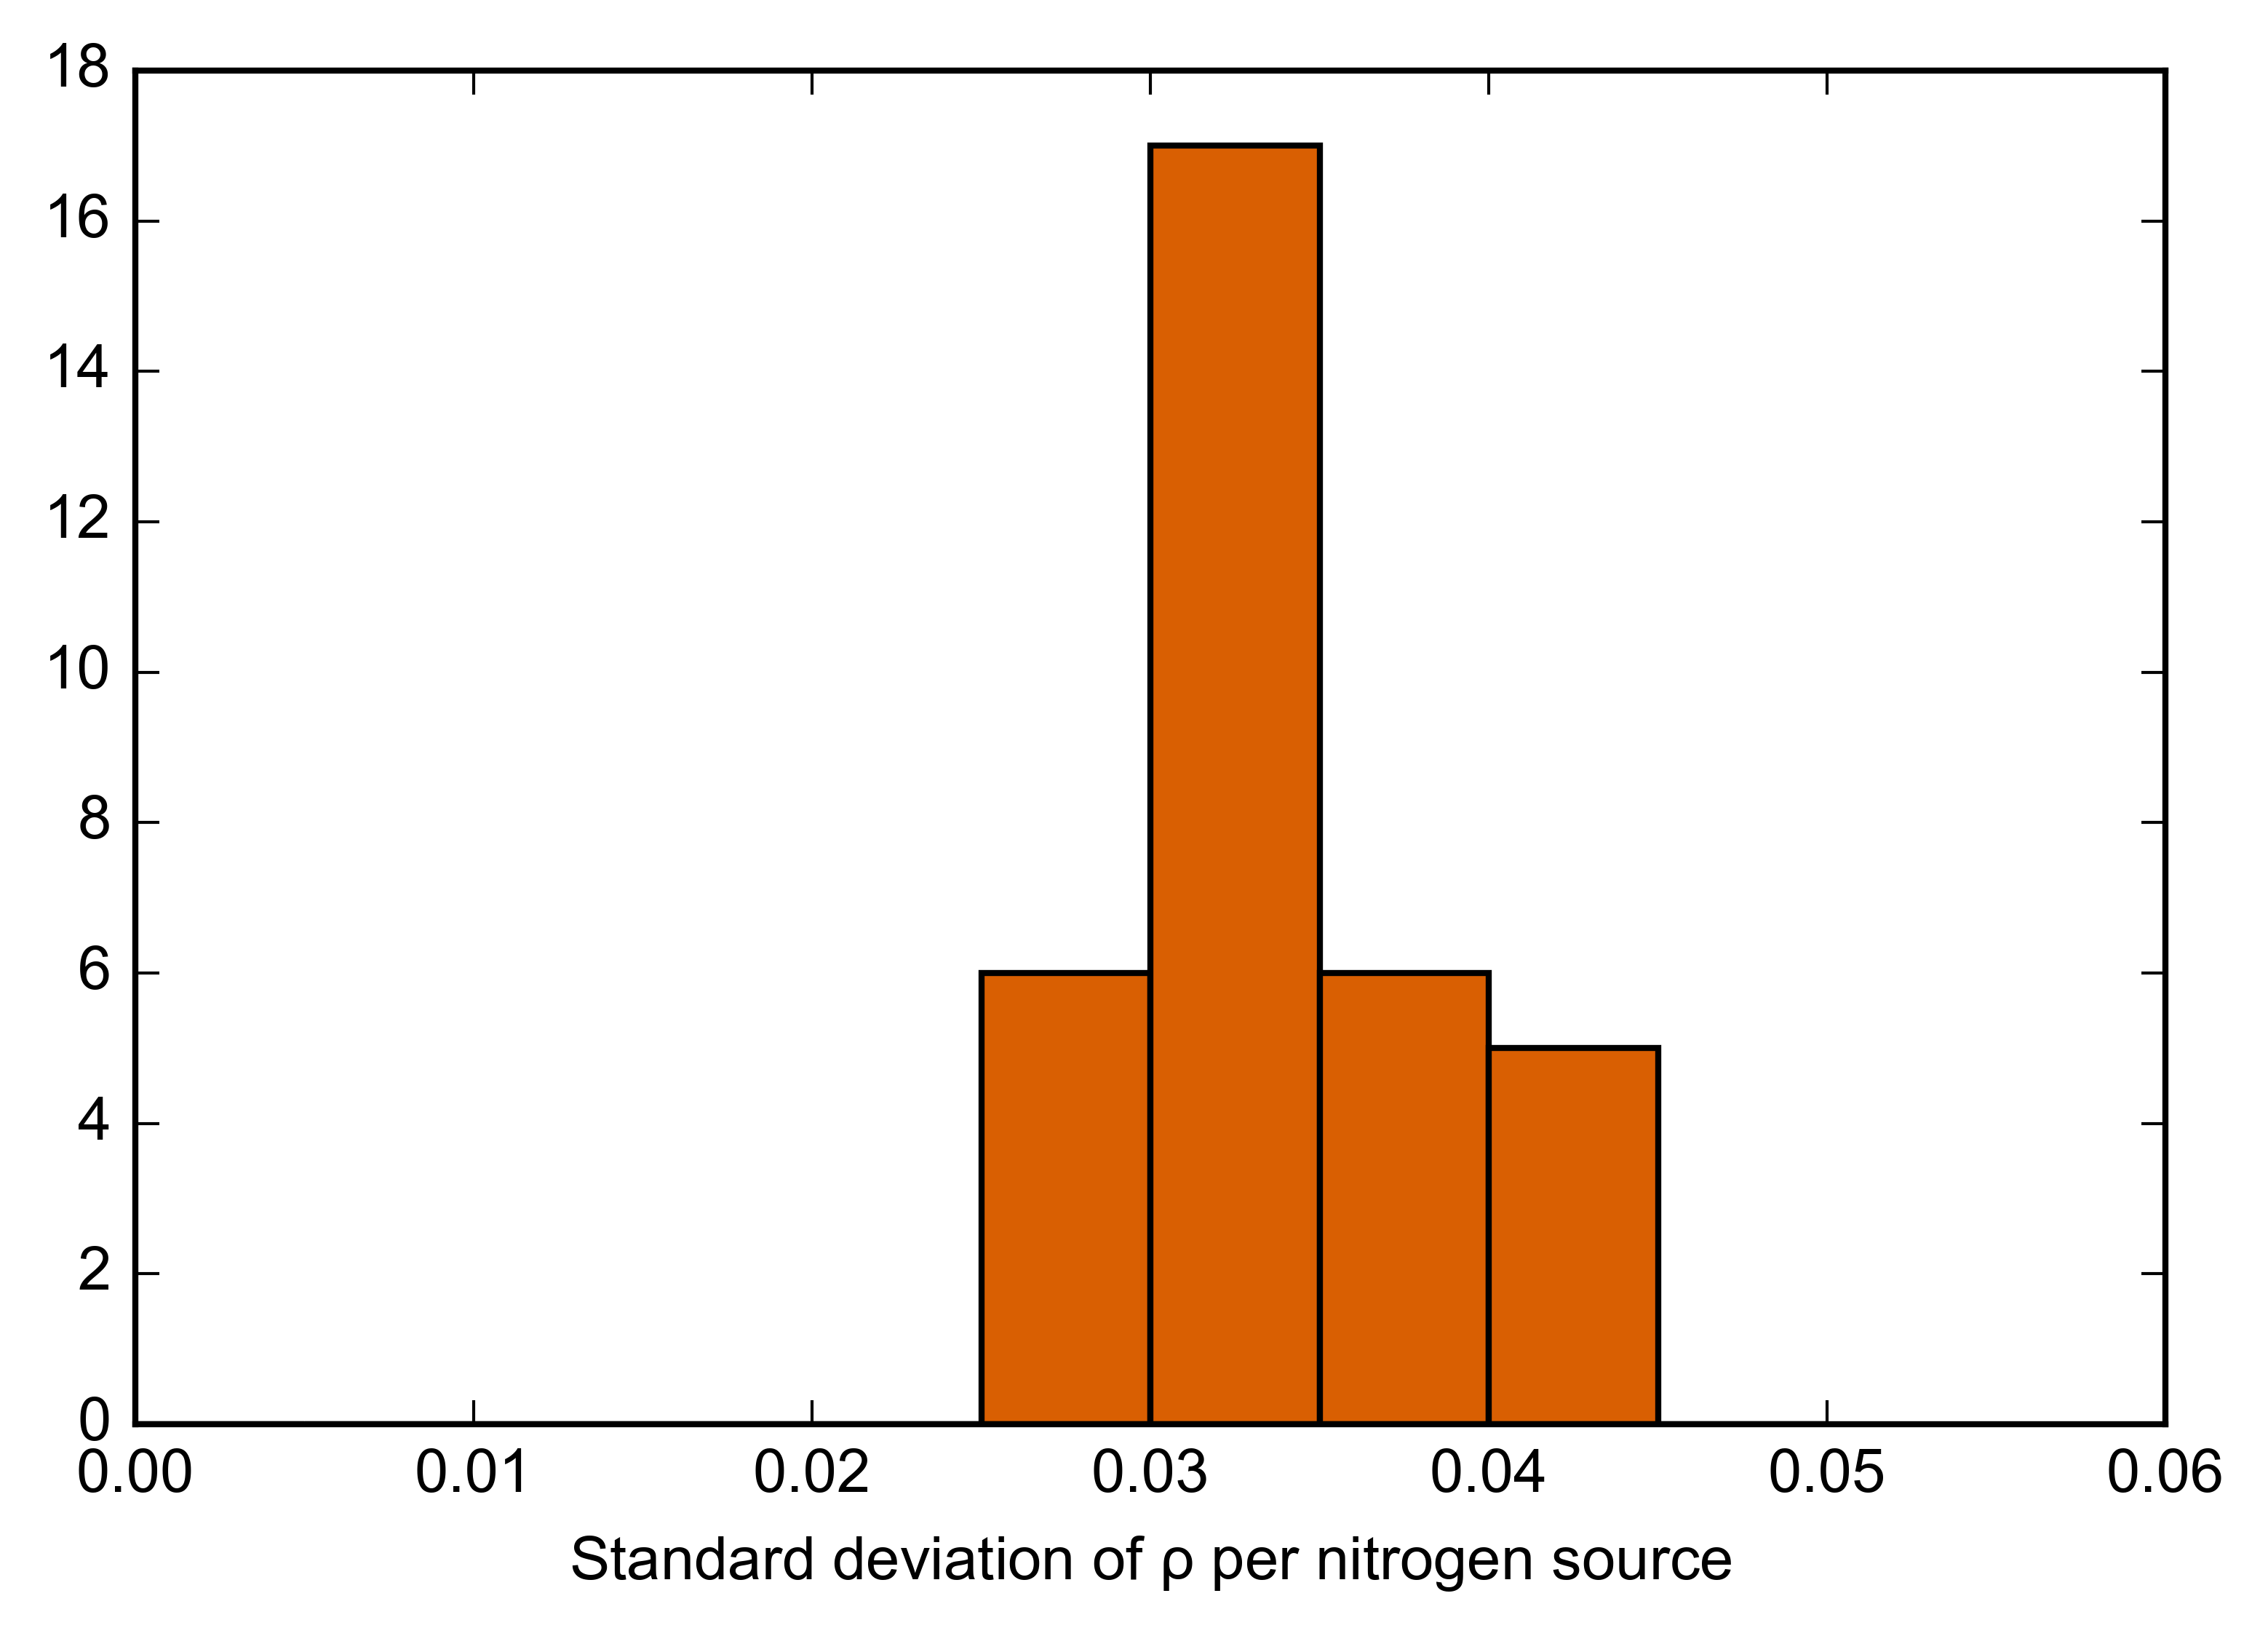

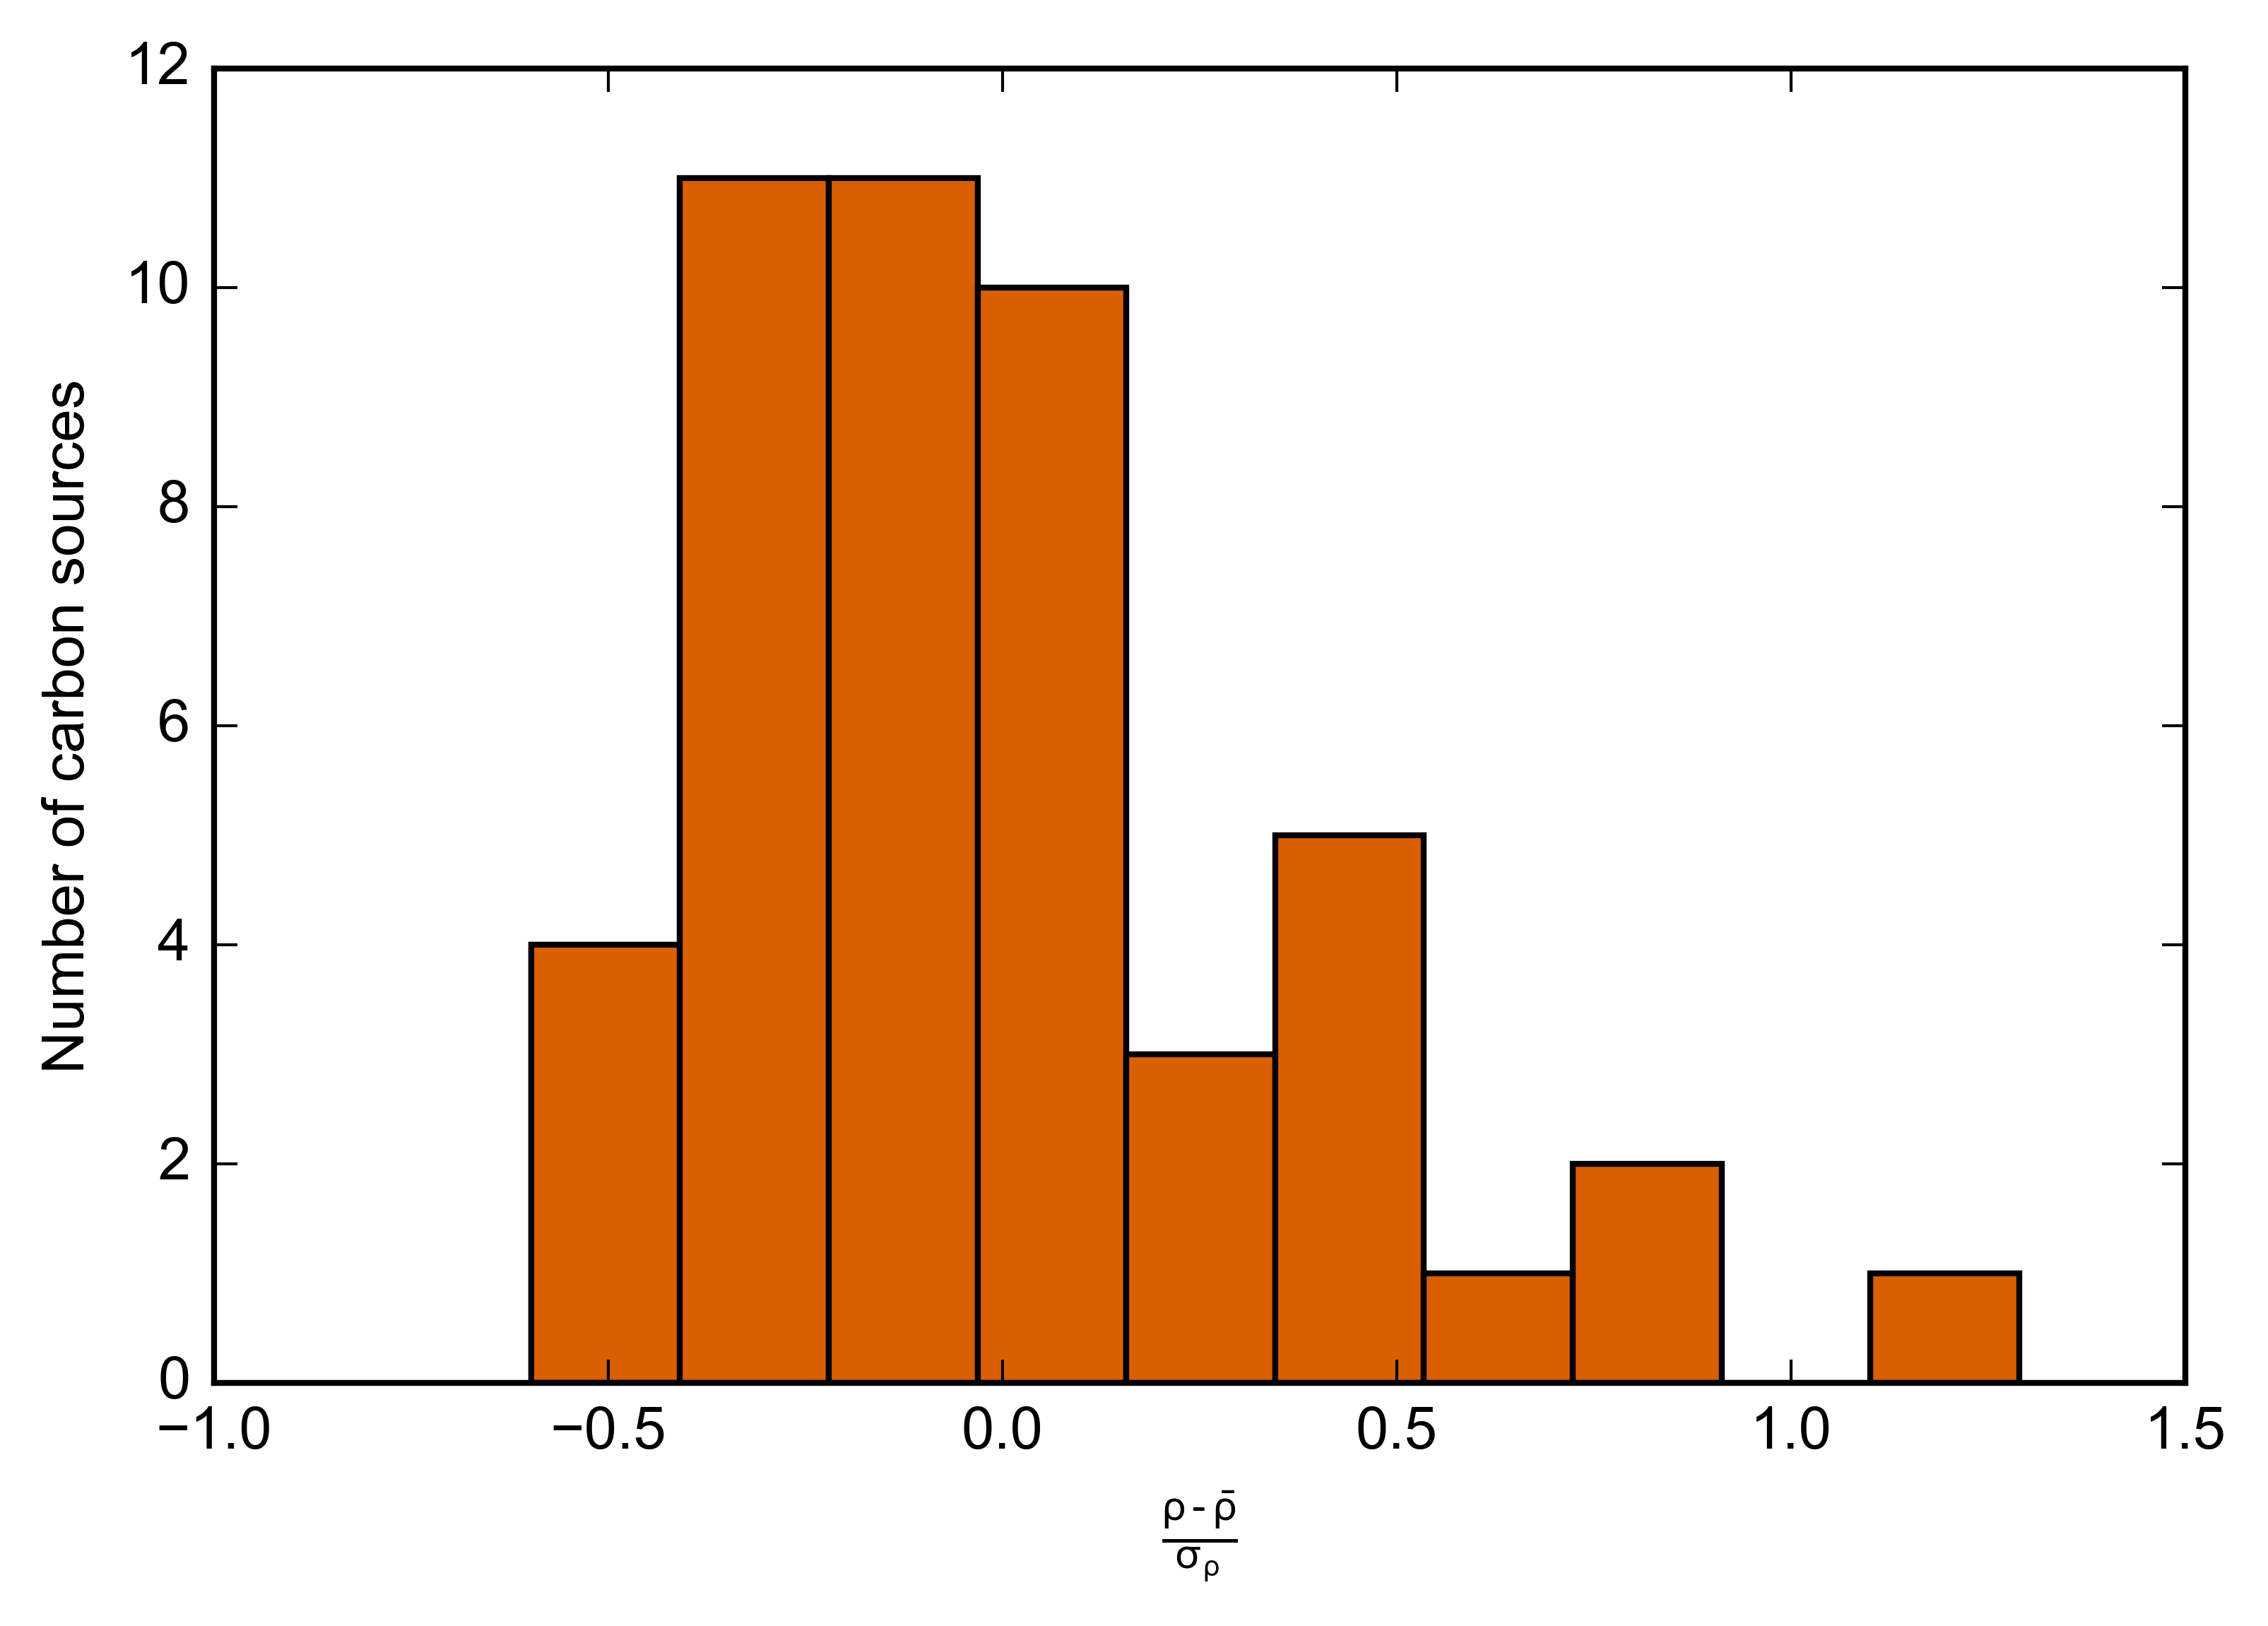

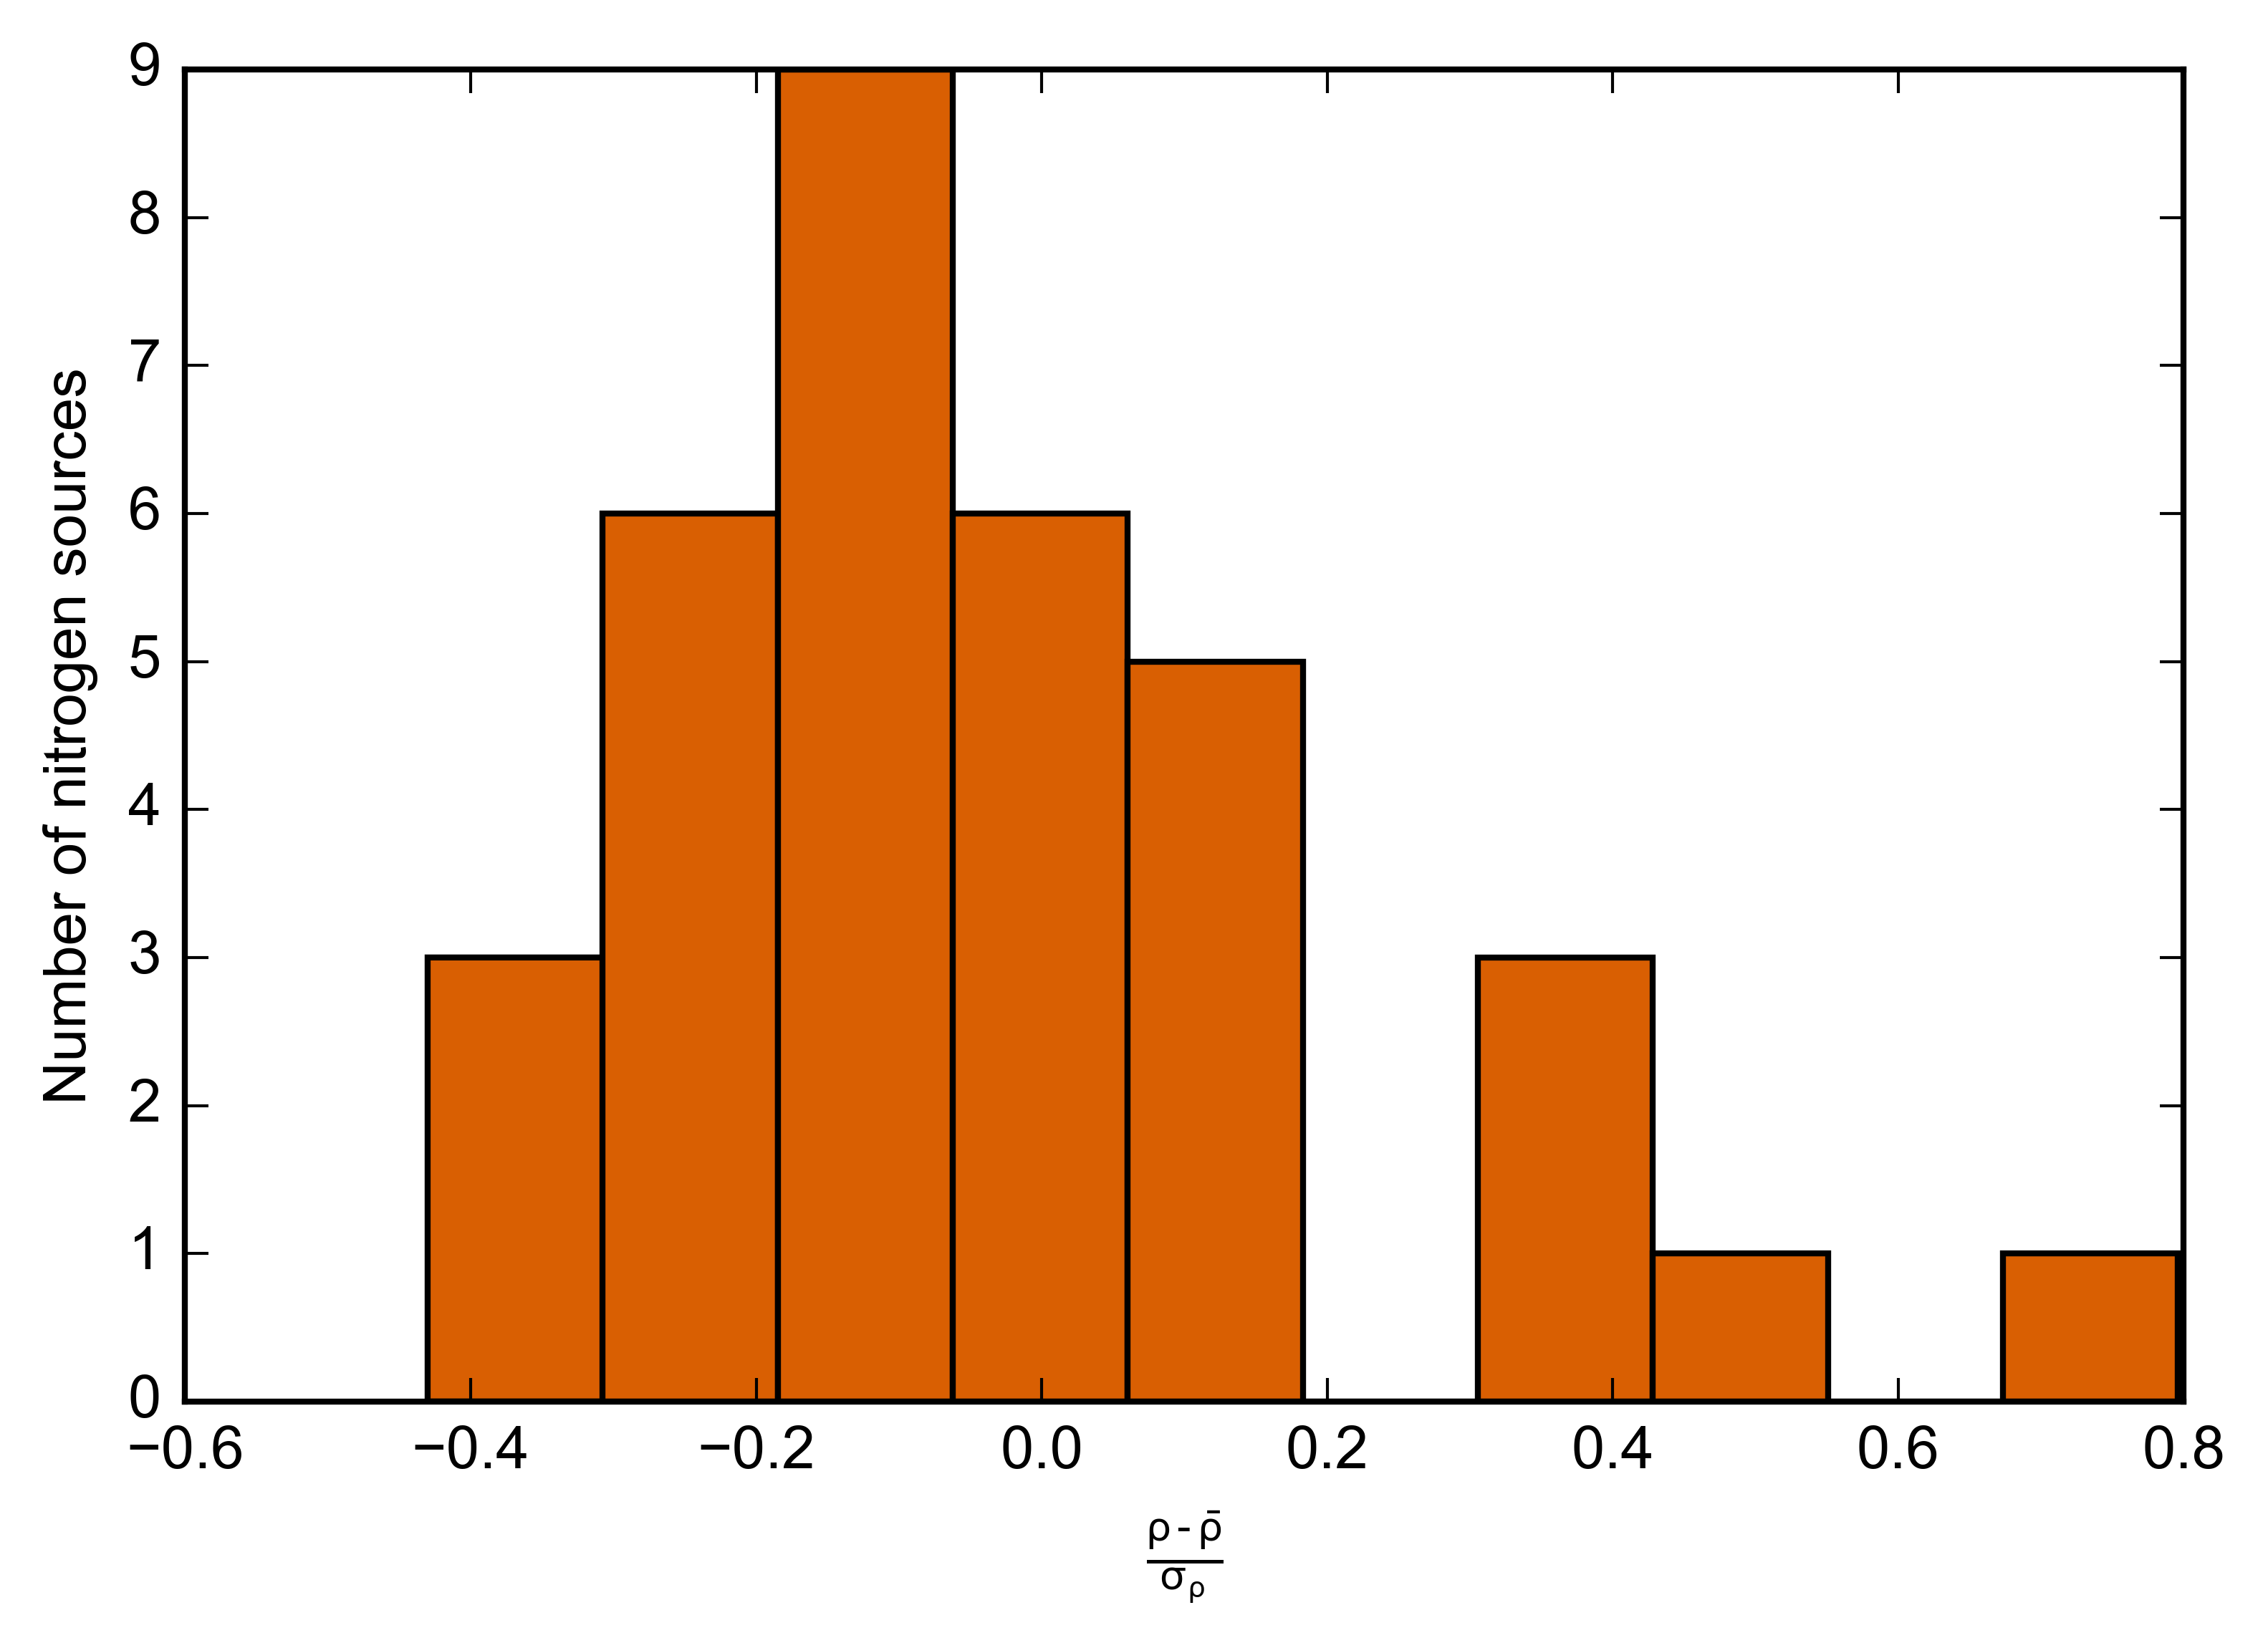

mean rho: -0.19
std rho: 0.04
lowest carbon source mean rho: -0.21
std: 0.03
for: pyruvate
pval: 6.69e-02


In [25]:
"""Investigate the individual nutrients to see if there are any outliers."""
carbonSources = list(set([c for c, n in minimalMedia]))
nitrogenSources = list(set([n for c, n in minimalMedia]))
avrgRhoPerCsource = []
stdPerCsource = []
avrgRhoPerNsource = []
stdPerNsource = []
pValsCarbon = []
pValsNitrogen = []
for carbonSource in carbonSources:
    indices = [i for i, (c, n) in enumerate(minimalMedia) if c == carbonSource]
    rhosSubset = [rhosGLC[i] for i in indices]
    otherRhos = [rhosGLC[i] for i in range(len(rhosGLC)) if i not in indices]
    pValsCarbon.append(ranksums(rhosSubset, otherRhos)[1] * len(set(carbonSources).union(set(nitrogenSources))))
    avrgRhoPerCsource.append(np.mean(rhosSubset))
    stdPerCsource.append(np.std(rhosSubset))
for nitrogenSource in nitrogenSources:
    indices = [i for i, (c, n) in enumerate(minimalMedia) if n == nitrogenSource]
    rhosSubset = [rhosGLC[i] for i in indices]
    avrgRhoPerNsource.append(np.mean(rhosSubset))
    stdPerNsource.append(np.std(rhosSubset))
    pValsNitrogen.append(ranksums(rhosSubset, otherRhos)[1] * len(set(carbonSources).union(set(nitrogenSources))))
plt.hist(avrgRhoPerCsource, range=(-0.4, 0.0), bins=20, color='#d95f02')
plt.xlabel(r'Mean $\rho$ per carbon source')
plt.show()
plt.hist(avrgRhoPerNsource, range=(-0.4, 0.0), bins=20, color='#d95f02')
plt.xlabel(r'Mean $\rho$ per nitrogen source')
plt.show()
plt.hist(stdPerCsource, range=(0., 0.05), bins=10, color='#d95f02')
plt.xlabel(r'Standard deviation of $\rho$ per carbon source')
plt.show()
plt.hist(stdPerNsource, range=(0., 0.05), bins=10, color='#d95f02')
plt.xlabel(r'Standard deviation of $\rho$ per nitrogen source')
plt.show()
normalizedDiffsC = [(rho - np.mean(rhosGLC)) / np.std(rhosGLC) for rho in avrgRhoPerCsource]
plt.hist(normalizedDiffsC, color='#d95f02')
plt.xlabel(r'$\frac{\rho - \bar{\rho}}{\sigma_{\rho}}$')
plt.ylabel('Number of carbon sources')
plt.show()
normalizedDiffsN = [(rho - np.mean(rhosGLC)) / np.std(rhosGLC) for rho in avrgRhoPerNsource]
plt.hist(normalizedDiffsN, color='#d95f02')
plt.xlabel(r'$\frac{\rho - \bar{\rho}}{\sigma_{\rho}}$')
plt.ylabel('Number of nitrogen sources')
plt.show()
print 'mean rho: %.2f' % np.mean(rhosGLC)
print 'std rho: %.2f' % np.std(rhosGLC)
print 'lowest carbon source mean rho: %.2f' % min(avrgRhoPerCsource)
print 'std: %.2f' % stdPerCsource[np.argmin(normalizedDiffsC)]
print 'for:', carbonSources[np.argmin(avrgRhoPerCsource)]
print 'pval: %.2e' % pValsCarbon[np.argmin(avrgRhoPerCsource)]